# **Deep Generative Models: Variational Autoencoders and Generative Adversarial Networks**

# **CK Dataset**
In the following exercices, you will work with images extracted from the CK dataset: http://www.jeffcohn.net/wp-content/uploads/2020/02/Cohn-Kanade_Database.pdf.pdf

It contains gray-scale images of human faces.

The dataset is provided in the folder `Data/faces/` in `.mat` format. In the following we provide a Dataset class in pytorch to load images from this database.

In [1]:
# !pip install torchinfo # NOTE: Uncomment this in colab

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import scipy.io as sio

from torchvision.utils import make_grid
from math import sqrt
import imageio
import numpy as np
import math
# from google.colab import drive

In [3]:
# Mount Google Drive. NOTE: Uncomment this in colab
# drive.mount('/content/drive')
# %cd "/content/drive/MyDrive/DeepLearning/"

In [4]:
import MyTorchWrapper as mtw
from architectures import GenerativeModel, VAE, GAN


data_path = 'Data'
results_path = 'Results'
output_images_path = results_path + '/images'

save_figure = True  # Whether to save figures or not
show_figure = True
num_epochs = 2000 # For GAN training only
plot_every = 200 # During training, plot results every {plot_every} epochs. For GAN training only.

In [15]:
"""# Our global variables"""
device = mtw.get_torch_device(use_gpu=True, debug=True)
torch.manual_seed(10)
if device != torch.device("cpu"):
    dataloader_workers = 4 # The amount of processes used to load data in parallel. In case of doubt use 0.
else:
    dataloader_workers = 0
print(f"The dataloader will use {dataloader_workers} parallel workers.")

output_resolution = 64
num_val_images = 25 # Number of images to plot for validation

explore_dataset = True
train_vae = True
train_gan = True

load_gan_checkpoint = False

Device selected: cuda:0
The dataloader will use 4 parallel workers.


Create a data loader for the face images dataset

In [6]:
class FacesDB(torch.utils.data.Dataset):
    # Initialization method for the dataset
    def __init__(self, dataDir=data_path+'/faces/face_ims_64x64.mat', transform=None):
        mat_loaded = sio.loadmat(dataDir)
        self.data = mat_loaded['X']
        self.transform = transform

    # What to do to load a single item in the dataset ( read image )
    def __getitem__(self, index):
        data = self.data[:, :, 0, index]
        data = Image.fromarray(data, mode='L')
        # Apply a trasnformaiton to the image if it is indicated in the initalizer
        if self.transform is not None:
            data = self.transform(data)

        # return the image and the label
        return data

    # Return the number of images
    def __len__(self):
        return self.data.shape[3]


Create a `DataLoader` and visualize one image of the dataset

Size of 1 batch of images: torch.Size([256, 1, 64, 64])
Total number of images: 50000


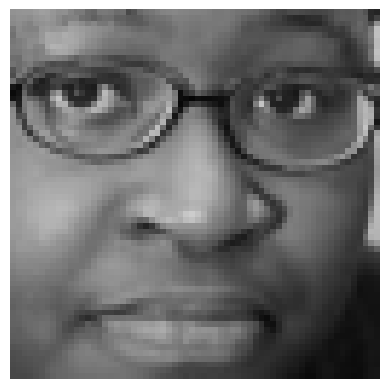

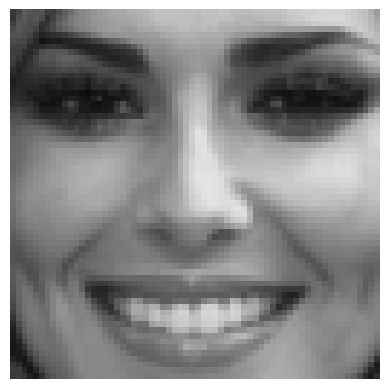

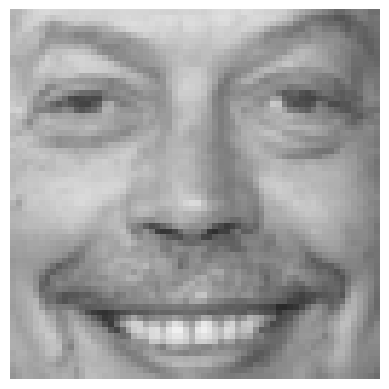

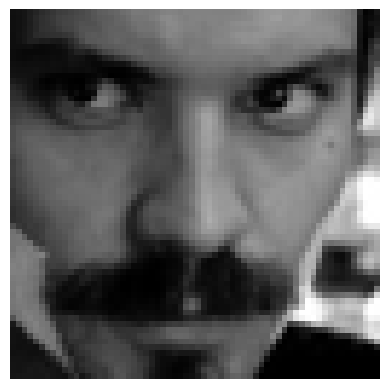

In [7]:
"""Create a `DataLoader` and visualize one image of the dataset"""
if explore_dataset:
    tr_exploration = transforms.Compose([transforms.ToTensor(), ])
    faces_db = FacesDB(data_path + '/faces/face_ims_64x64.mat', tr_exploration)
    exploration_loader = torch.utils.data.DataLoader(
        dataset=faces_db, batch_size=256, shuffle=True, pin_memory=True)
    
    # Print input images shape
    images = next(iter(exploration_loader))
    print("Size of 1 batch of images:", images.shape)
    print("Total number of images:", len(faces_db))

    # Mini-batch images
    for i in range(4):
        images = next(iter(exploration_loader))
        image = images[0, :, :, :].repeat(3, 1, 1)
        plt.imshow(image.permute(1, 2, 0).squeeze().numpy())
        plt.axis('off')
        plt.show()


In [16]:
tr_training = transforms.Compose([
    transforms.Resize((output_resolution, output_resolution)),
    transforms.ToTensor(),  # convert image to pytorch tensor [0..,1]
])


# Initialize the dataset
train_faces = FacesDB(data_path+'/faces/face_ims_64x64.mat', tr_training)
train_batch_size = math.ceil(len(train_faces) / 20) # TODO: Modify according to PC used

# Class to iterate over the dataset (DataLoader)
train_loader = torch.utils.data.DataLoader(
    dataset=train_faces,
    batch_size = train_batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=dataloader_workers,
)

test_loader = torch.utils.data.DataLoader(
    dataset=train_faces,
    batch_size=num_val_images,
    shuffle=False
)

# Ex. 1

1. Following the example of the MNIST, train a VAE with the images we have provided for the CK dataset.

2. For every two epochs during training:

    2.1. Visualize a set of reconstructed images and compute the reconstruction error over the whole dataset

    2.2. Generate and show a set of images from random noise z.

    2.3. Visualize a set of generated images by interpolating over the latent space z.

    2.4 Discuss the different visualizations by analysing their relation with the evolution of the reconstruction loss and the KL regularization term.

In [9]:
def kl_divergence(z_mean, z_log_var):
    kl_loss = 0.5 * torch.sum((torch.exp(z_log_var) + z_mean**2 - 1.0 - z_log_var), axis=1)
    return kl_loss.mean()

def plot_reconstructed_images(vae, test_loader, epoch):
    test_images = next(iter(test_loader))
    test_images = test_images.to(device)
    # Get reconstructed test images with the VAE
    _, z_mean, _ = vae(test_images)
    x_rec = vae.decoder(z_mean)

    figure, axes = plt.subplots(2, 1, figsize=(test_loader.batch_size * 2 + 2, test_loader.batch_size + 1))
    figure.suptitle(f"Reconstructed images at epoch {epoch}", fontsize=14, fontweight="bold")
    
    image_grid = make_grid(test_images.cpu(), nrow=test_loader.batch_size, padding=1, normalize = True)
    
    axes[0].imshow(image_grid.permute(1, 2, 0).detach().numpy())
    axes[0].set_title('Original Images')
    axes[0].axis("off")

    axes[1].set_title('Reconstructed Images')
    image_grid = make_grid(x_rec.cpu(), nrow=test_loader.batch_size, padding=1)
    axes[1].imshow(image_grid.permute(1, 2, 0).detach().numpy())
    axes[1].axis("off")

    if save_figure:
        plt.savefig(f"{output_images_path}/{vae.name}/reconstructed_images_e{epoch}.png", dpi=300)

    if not show_figure:
        plt.close()
    # plt.show()


def generate_images(model: GenerativeModel, epoch, n_samples=9, device="cpu"):    
    ### Generate random samples
    x_rec = model.sample(n_samples, device)

    # Show synthetic images
    padding = 0
    plt.figure(figsize= (n_samples + padding, n_samples + padding))
    plt.title(f"Generated images at epoch {epoch}", fontsize=14, fontweight="bold")
    image_grid = make_grid(x_rec.cpu(), nrow=math.ceil(sqrt(n_samples)), padding=padding)
    plt.imshow(image_grid.permute(1,2,0).detach().numpy())

    if save_figure:
        plt.savefig(f"{output_images_path}/{model.name}/{model.name}_generated_images_e{epoch}.png", dpi=300)

    if not show_figure:
        plt.close()
    # plt.show()


def generate_interpolated(model: GenerativeModel, epoch, n_samples=9, device='cpu'):
    ### Generate random samples
    n_iterpolations = 50 # Number of intermediate steps between init and final

    # Sample a set of pairs z_init and z_final
    z_init = model.get_latent_space(n_samples=n_samples, device=device)*2
    z_final = model.get_latent_space(n_samples=n_samples, device=device)*2

    # Compute interpolations between z_init and z_final
    # and generate an image for each interpolation.
    interpolation_images = []
    for interp in range(0, n_iterpolations):
        interp_0_1 = float(interp) / (n_iterpolations-1)
        z = z_init * interp_0_1 + z_final * (1 - interp_0_1)
        x_rec = model.decode(z)
        image_grid = make_grid(x_rec.cpu(), nrow=math.ceil(sqrt(n_samples)), padding=1)
        image_grid = image_grid.permute(1, 2, 0).detach().numpy()
        # save the generated images in a list
        interpolation_images.append((image_grid * 255.0).astype(np.uint8))

    # Concatenate the inversion of the list to generate a "loop" animation
    interpolation_images += interpolation_images[::-1]

    # Generate and visualize a give showing the interpolation results.
    imname = f"{output_images_path}/interpolations/{model.name}/ck_e{epoch}.gif"
    fps = 50
    duration = (1000 * 1/fps)
    imageio.mimsave(imname, interpolation_images, duration = duration)

    # with open(imname,'rb') as f:
    #     display(Image(data=f.read(), format='png',width=512,height=512))


In [10]:
def train_VAE(vae: VAE, train_loader, test_loader, optimizer, kl_weight=0.001, num_epochs=10, device='cpu', plot_every=2):
    vae.train()  # Set the model in train mode
    vae.to(device)
    total_step = len(train_loader)
    losses_list = []
    kl_list = []
    # Use mean-squared error to compare the original and reconstruct the images
    criterion = nn.MSELoss()

    # Iterate over epochs
    for epoch in range(1, num_epochs + 1):
        # Iterate the dataset
        rec_loss_avg = 0
        kl_loss_avg = 0
        nBatches = 0
        for i, images in enumerate(train_loader):
            # Get batch of samples and labels
            images = images.to(device)

            # Forward pass (get encoder variables and reconstructed images)
            x_rec, z_mean, z_log_var = vae(images)

            # Reconstruction loss (x,x_rec)
            reconstruction_loss = criterion(x_rec, images)
            # Compute KL divergecnes KL( N(mu_x,sigma_x) || N(0,I))
            kl_loss = kl_divergence(z_mean, z_log_var)

            # Backward and optimize reconstruction loss and kl regularization
            optimizer.zero_grad()
            # we use a weight to balance the importance of the KL loss
            loss = reconstruction_loss + kl_loss * kl_weight
            loss.backward()
            optimizer.step()

            rec_loss_avg += reconstruction_loss.cpu().item()
            kl_loss_avg += kl_loss.cpu().item()

            nBatches += 1
            if (i + 1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Rec. Loss: {:.4f}, KL Loss: {:.4f}'
                      .format(epoch, num_epochs, i+1, total_step, rec_loss_avg / nBatches, kl_loss_avg / nBatches))

        # Visualize the images every two training epochs
        if epoch % plot_every == 0:
            vae.eval()
            plot_reconstructed_images(vae, test_loader, epoch)
            generate_images(vae, epoch, n_samples=test_loader.batch_size, device=device)
            generate_interpolated(vae, epoch, n_samples=test_loader.batch_size, device=device)
            vae.train()
            
        print('Epoch [{}/{}], Step [{}/{}], Rec. Loss: {:.4f}, KL Loss: {:.4f}'
              .format(epoch, num_epochs, i + 1, total_step, rec_loss_avg / nBatches, kl_loss_avg / nBatches))
        losses_list.append(rec_loss_avg / nBatches)
        kl_list.append(kl_loss_avg / nBatches)
        # save trained model
        torch.save(vae.state_dict(), f"{results_path}/{vae.name}_ck.ckpt")

    return losses_list, kl_list


#################### Training VAE ####################
Epoch [1/100], Step [20/20], Rec. Loss: 0.0459, KL Loss: 4.3326
Epoch [2/100], Step [20/20], Rec. Loss: 0.0336, KL Loss: 4.4662
Epoch [3/100], Step [20/20], Rec. Loss: 0.0278, KL Loss: 4.6664
Epoch [4/100], Step [20/20], Rec. Loss: 0.0251, KL Loss: 4.7120
Epoch [5/100], Step [20/20], Rec. Loss: 0.0238, KL Loss: 4.7691
Epoch [6/100], Step [20/20], Rec. Loss: 0.0229, KL Loss: 4.7560
Epoch [7/100], Step [20/20], Rec. Loss: 0.0222, KL Loss: 4.7212
Epoch [8/100], Step [20/20], Rec. Loss: 0.0217, KL Loss: 4.7558
Epoch [9/100], Step [20/20], Rec. Loss: 0.0212, KL Loss: 4.7079
Epoch [10/100], Step [20/20], Rec. Loss: 0.0206, KL Loss: 4.6682
Epoch [11/100], Step [20/20], Rec. Loss: 0.0202, KL Loss: 4.6525
Epoch [12/100], Step [20/20], Rec. Loss: 0.0197, KL Loss: 4.6074
Epoch [13/100], Step [20/20], Rec. Loss: 0.0193, KL Loss: 4.5909
Epoch [14/100], Step [20/20], Rec. Loss: 0.0188, KL Loss: 4.5859
Epoch [15/100], Step [20/20], Rec. Loss: 0.0

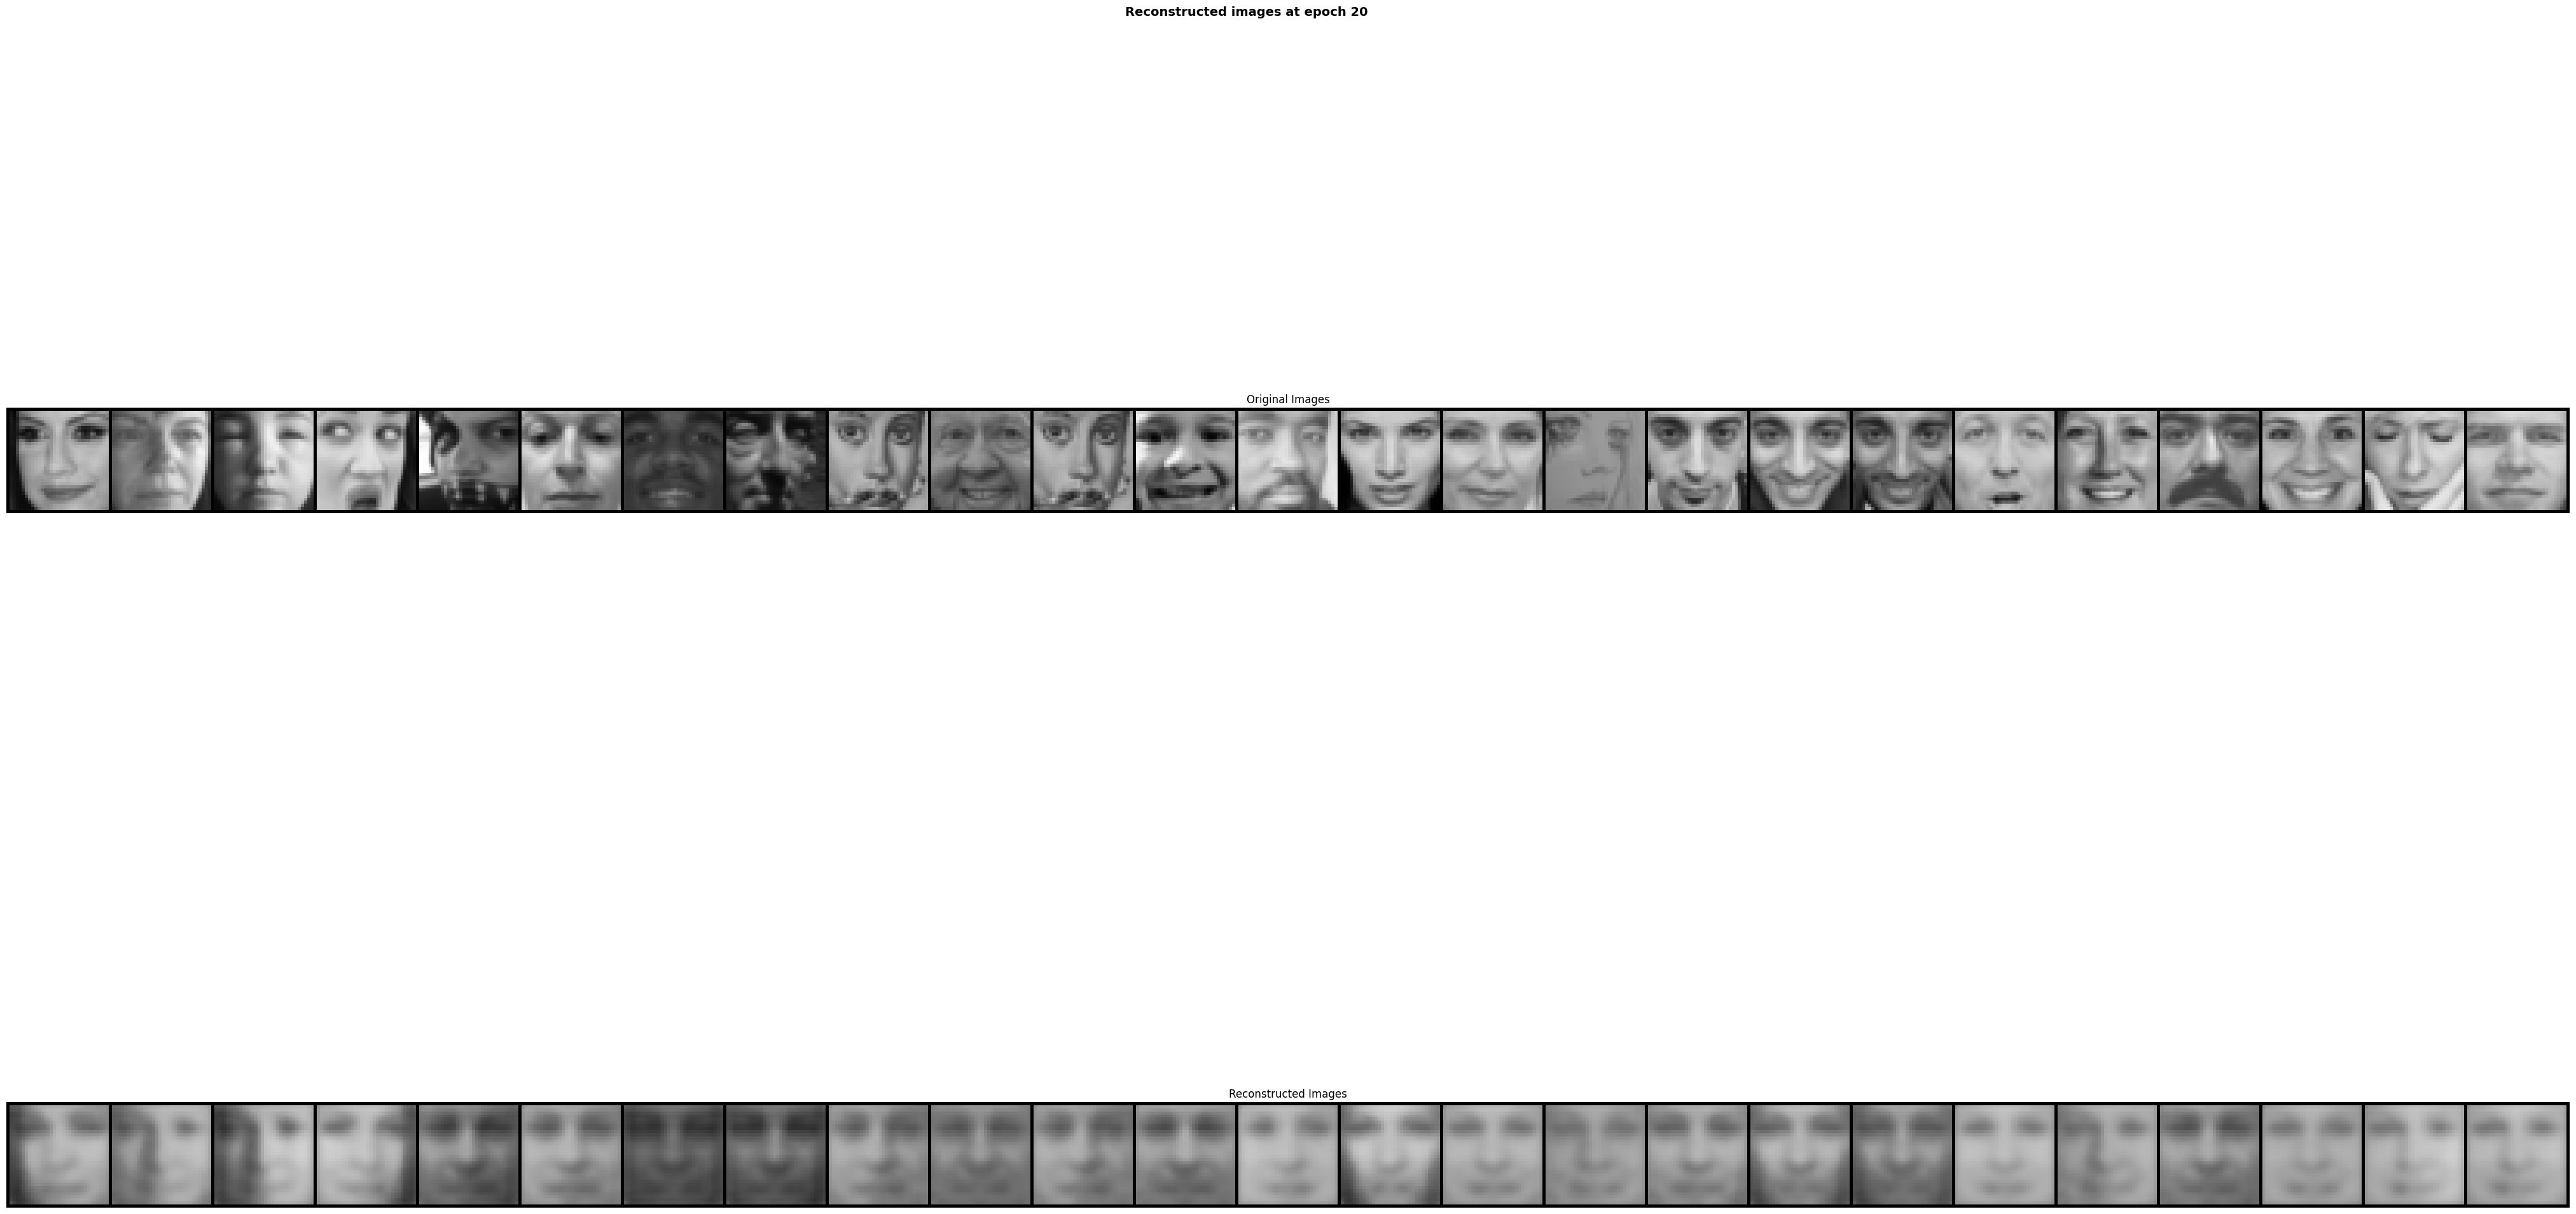

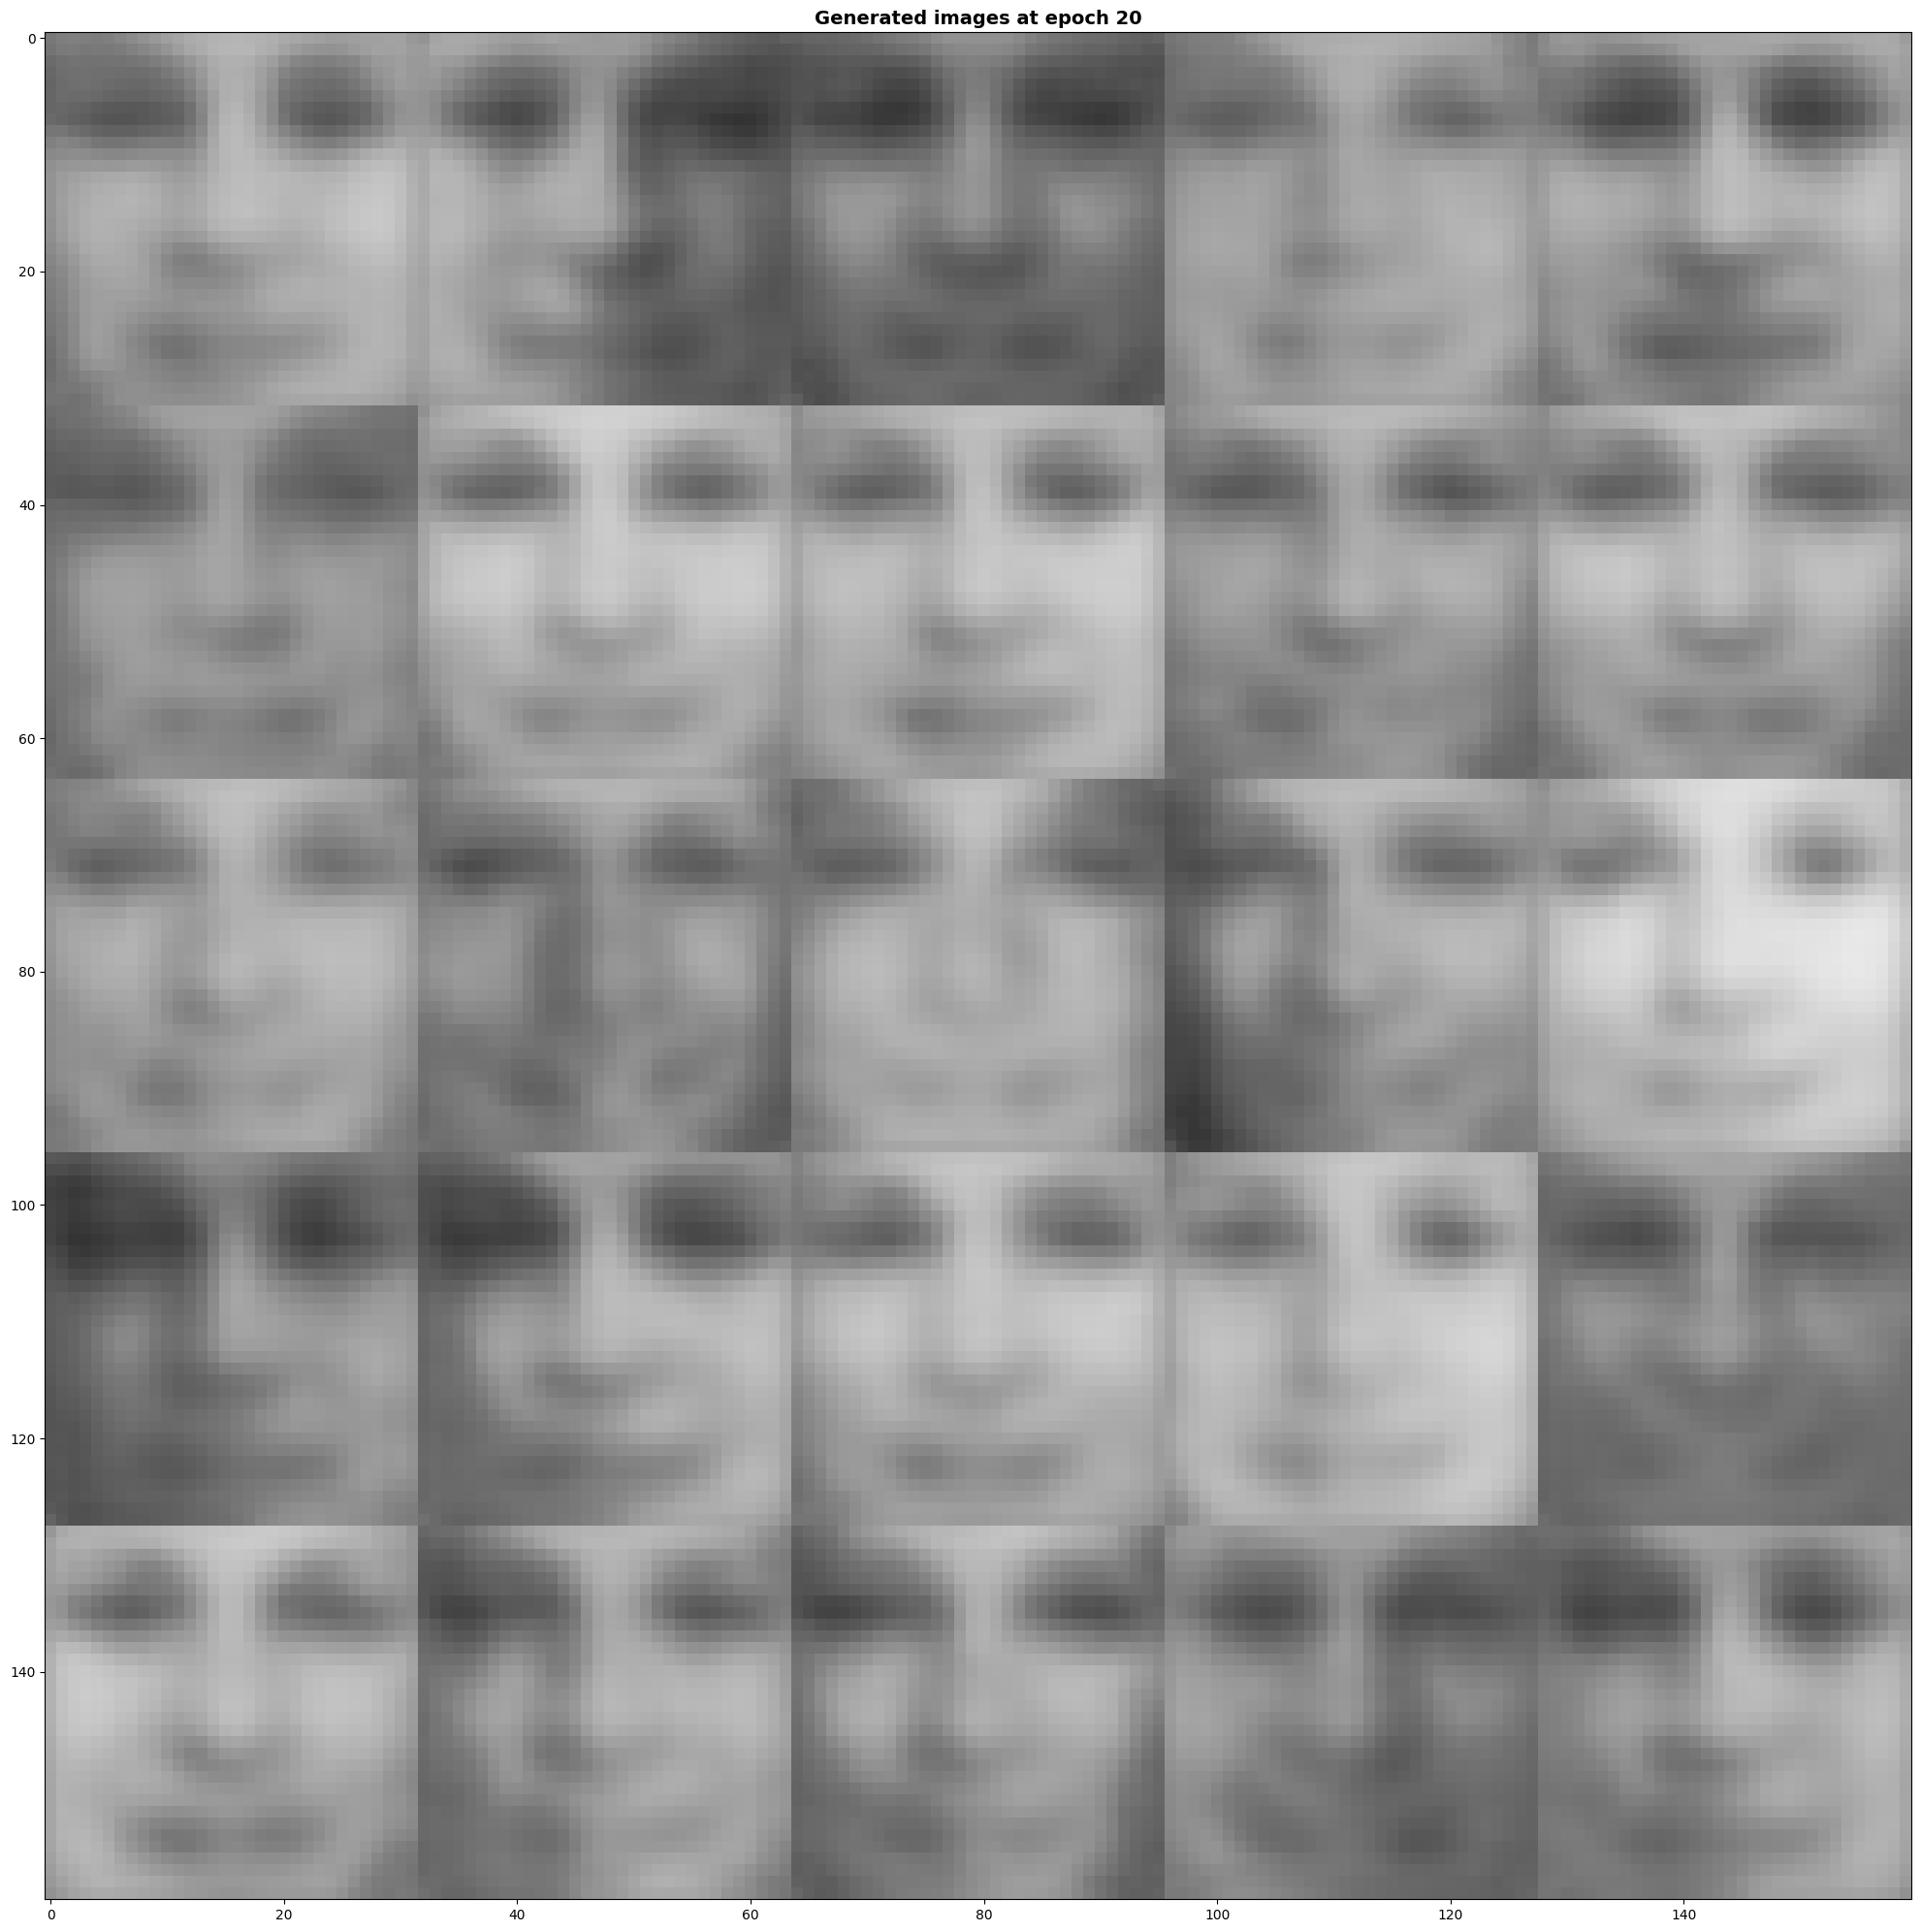

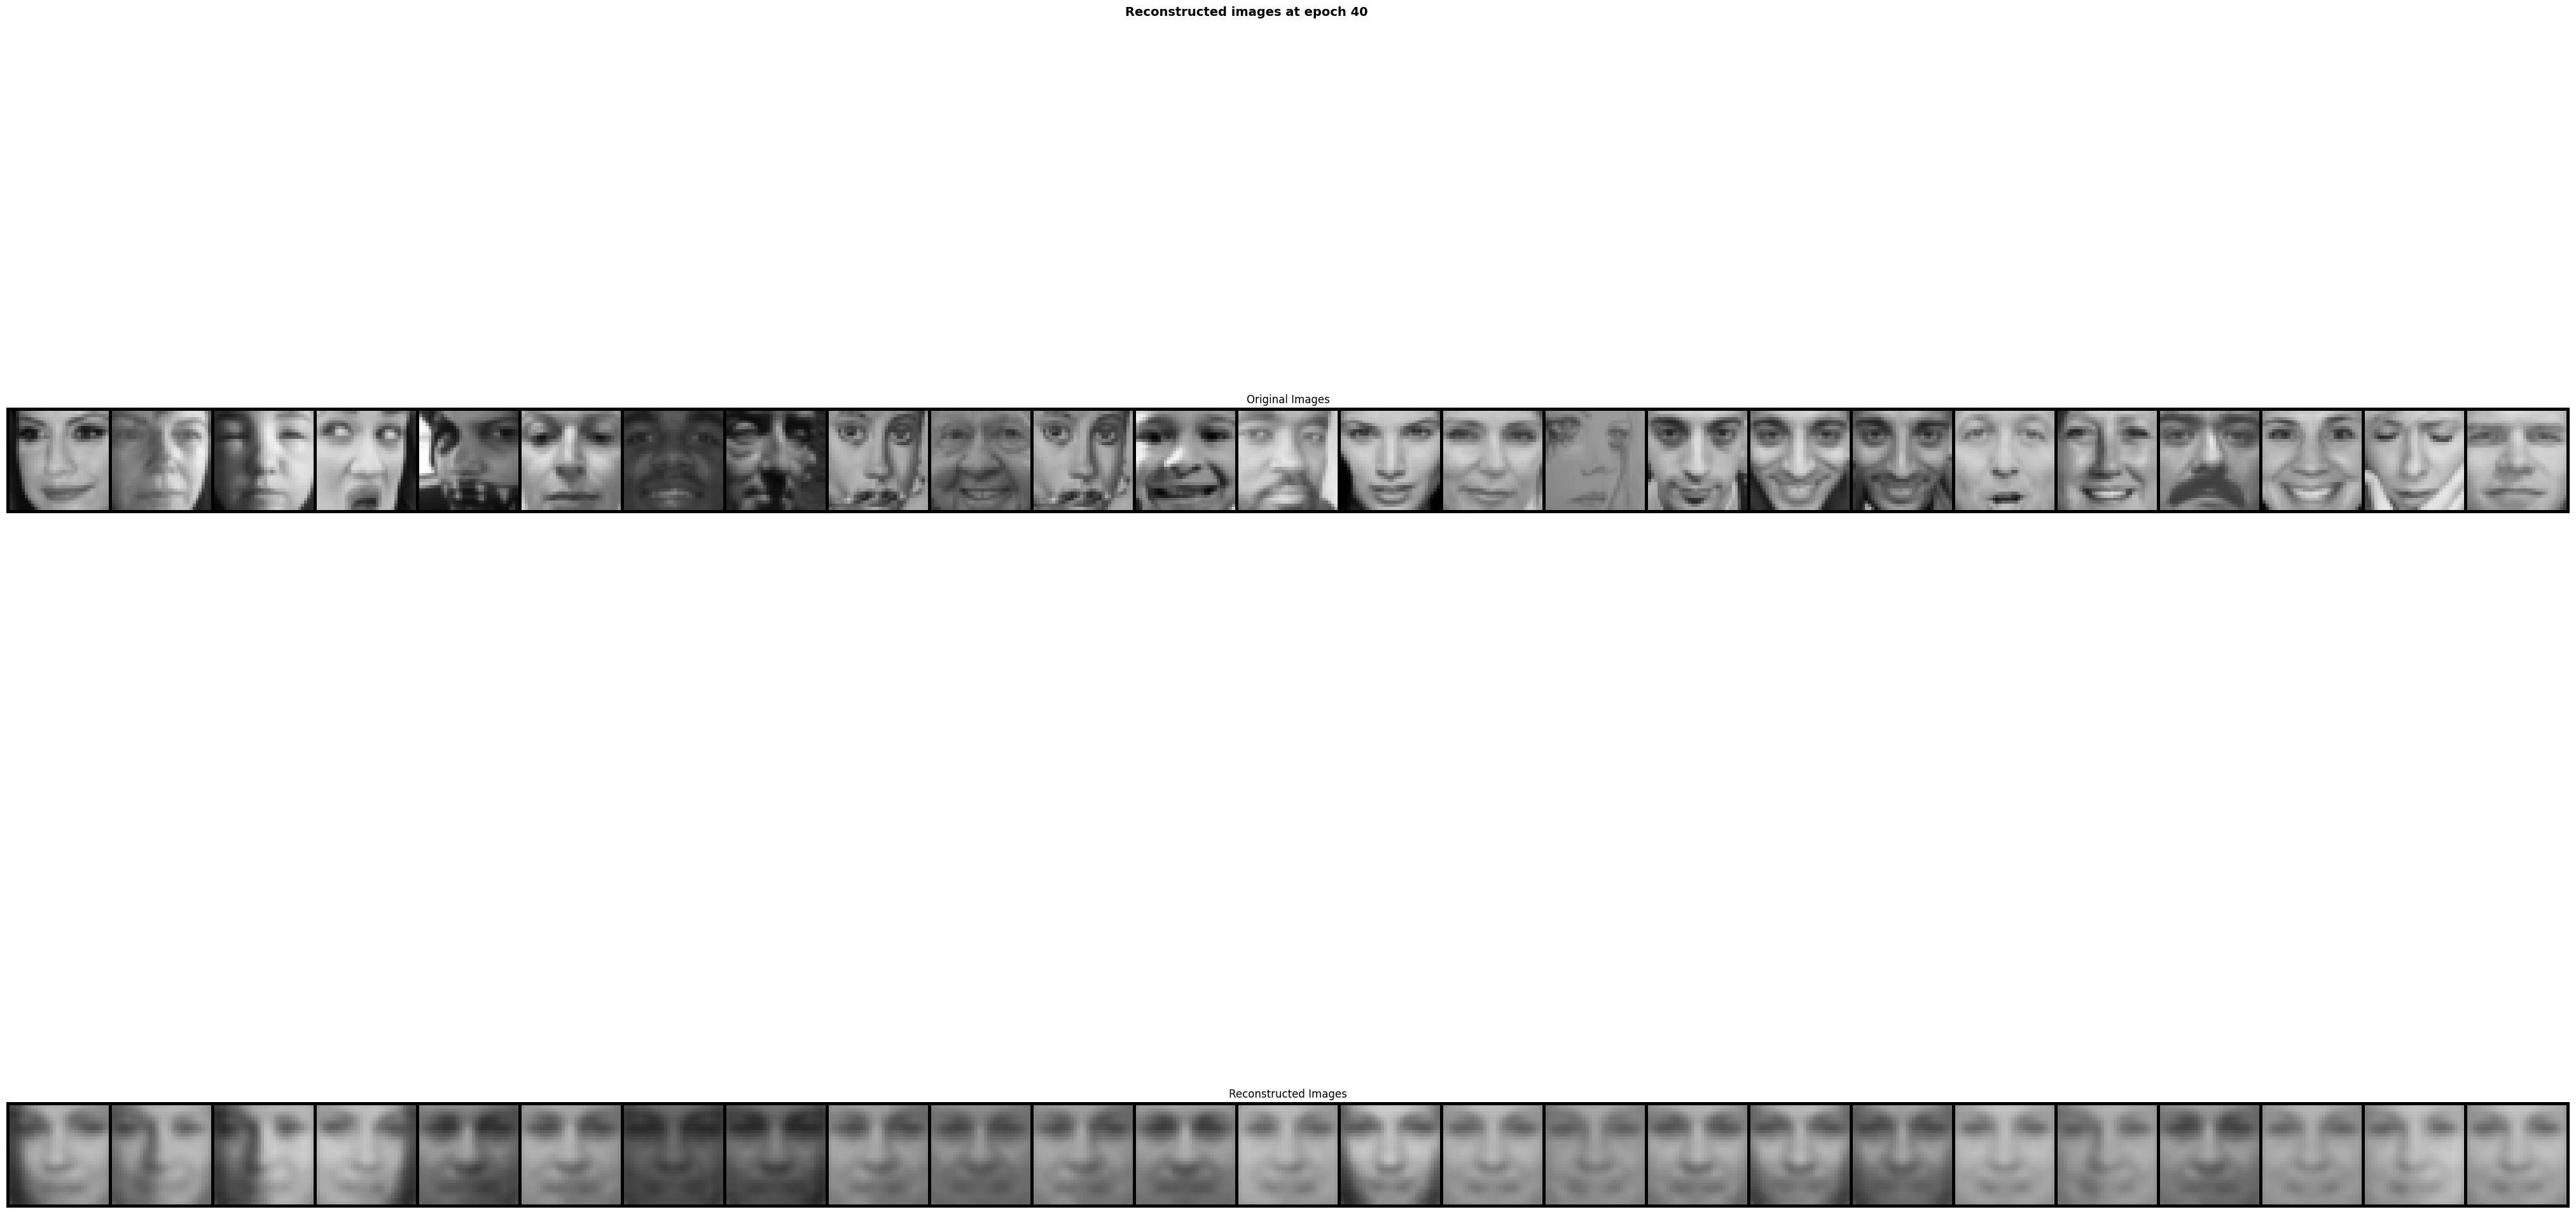

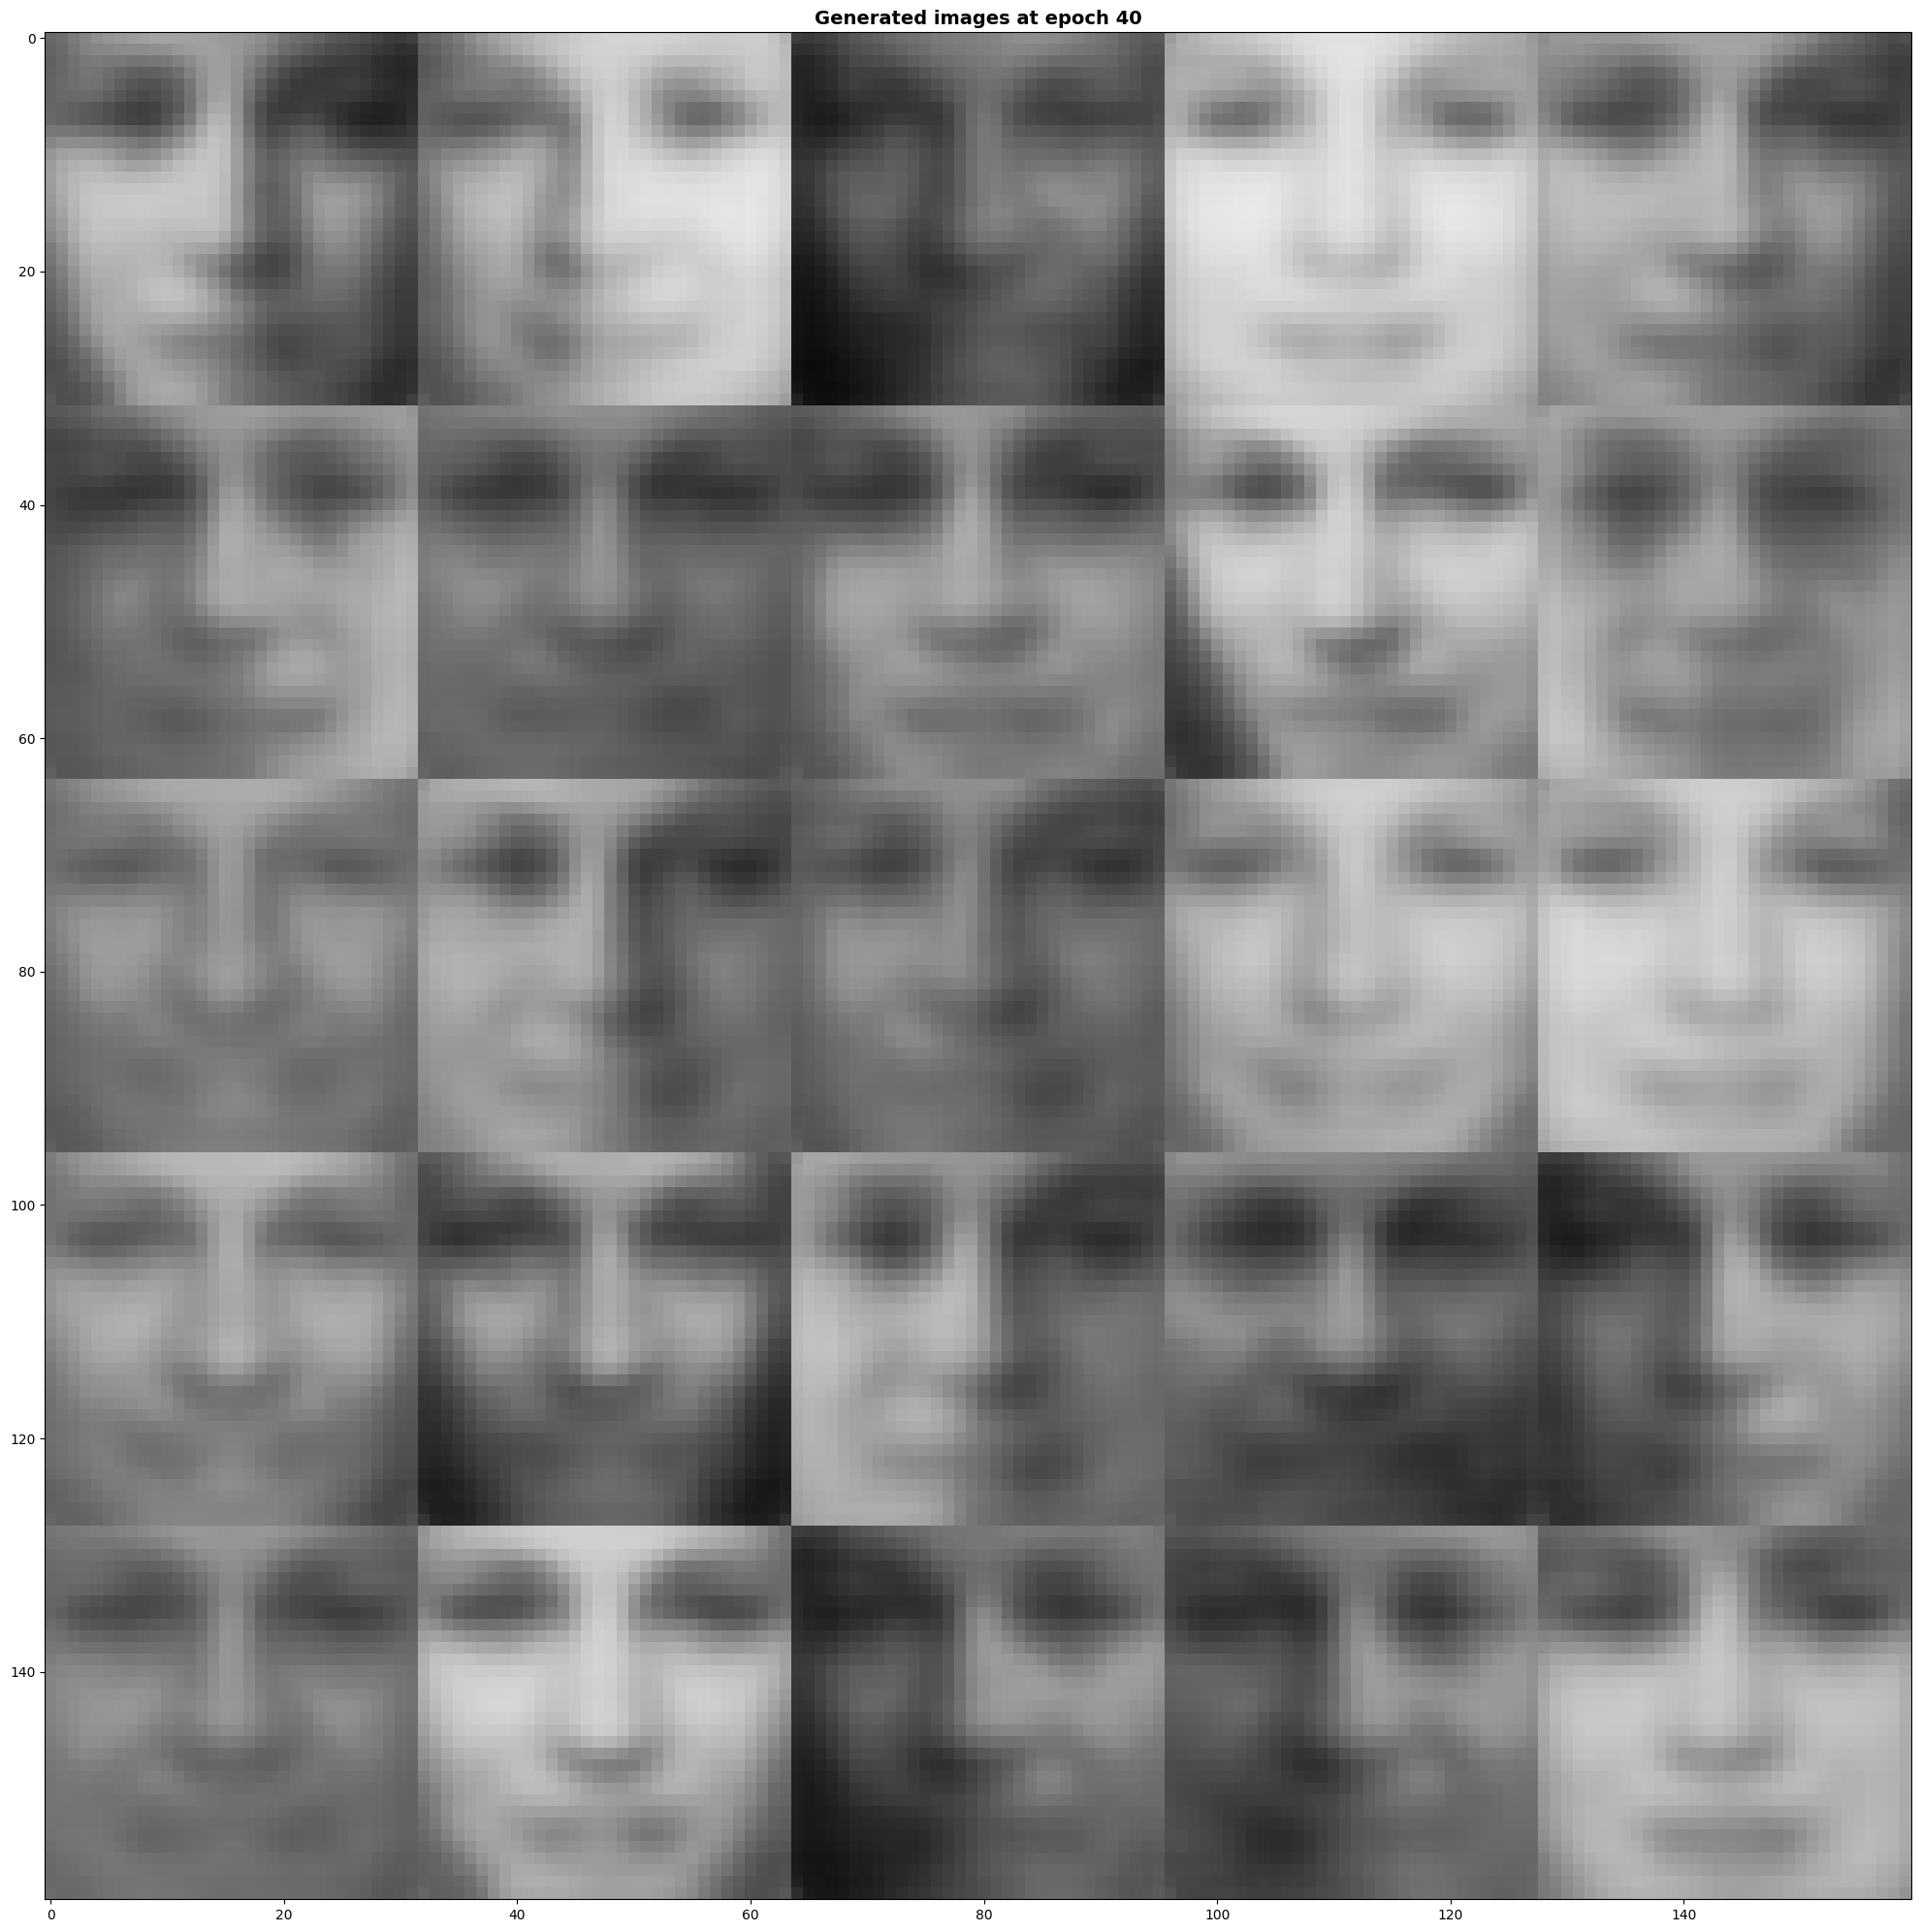

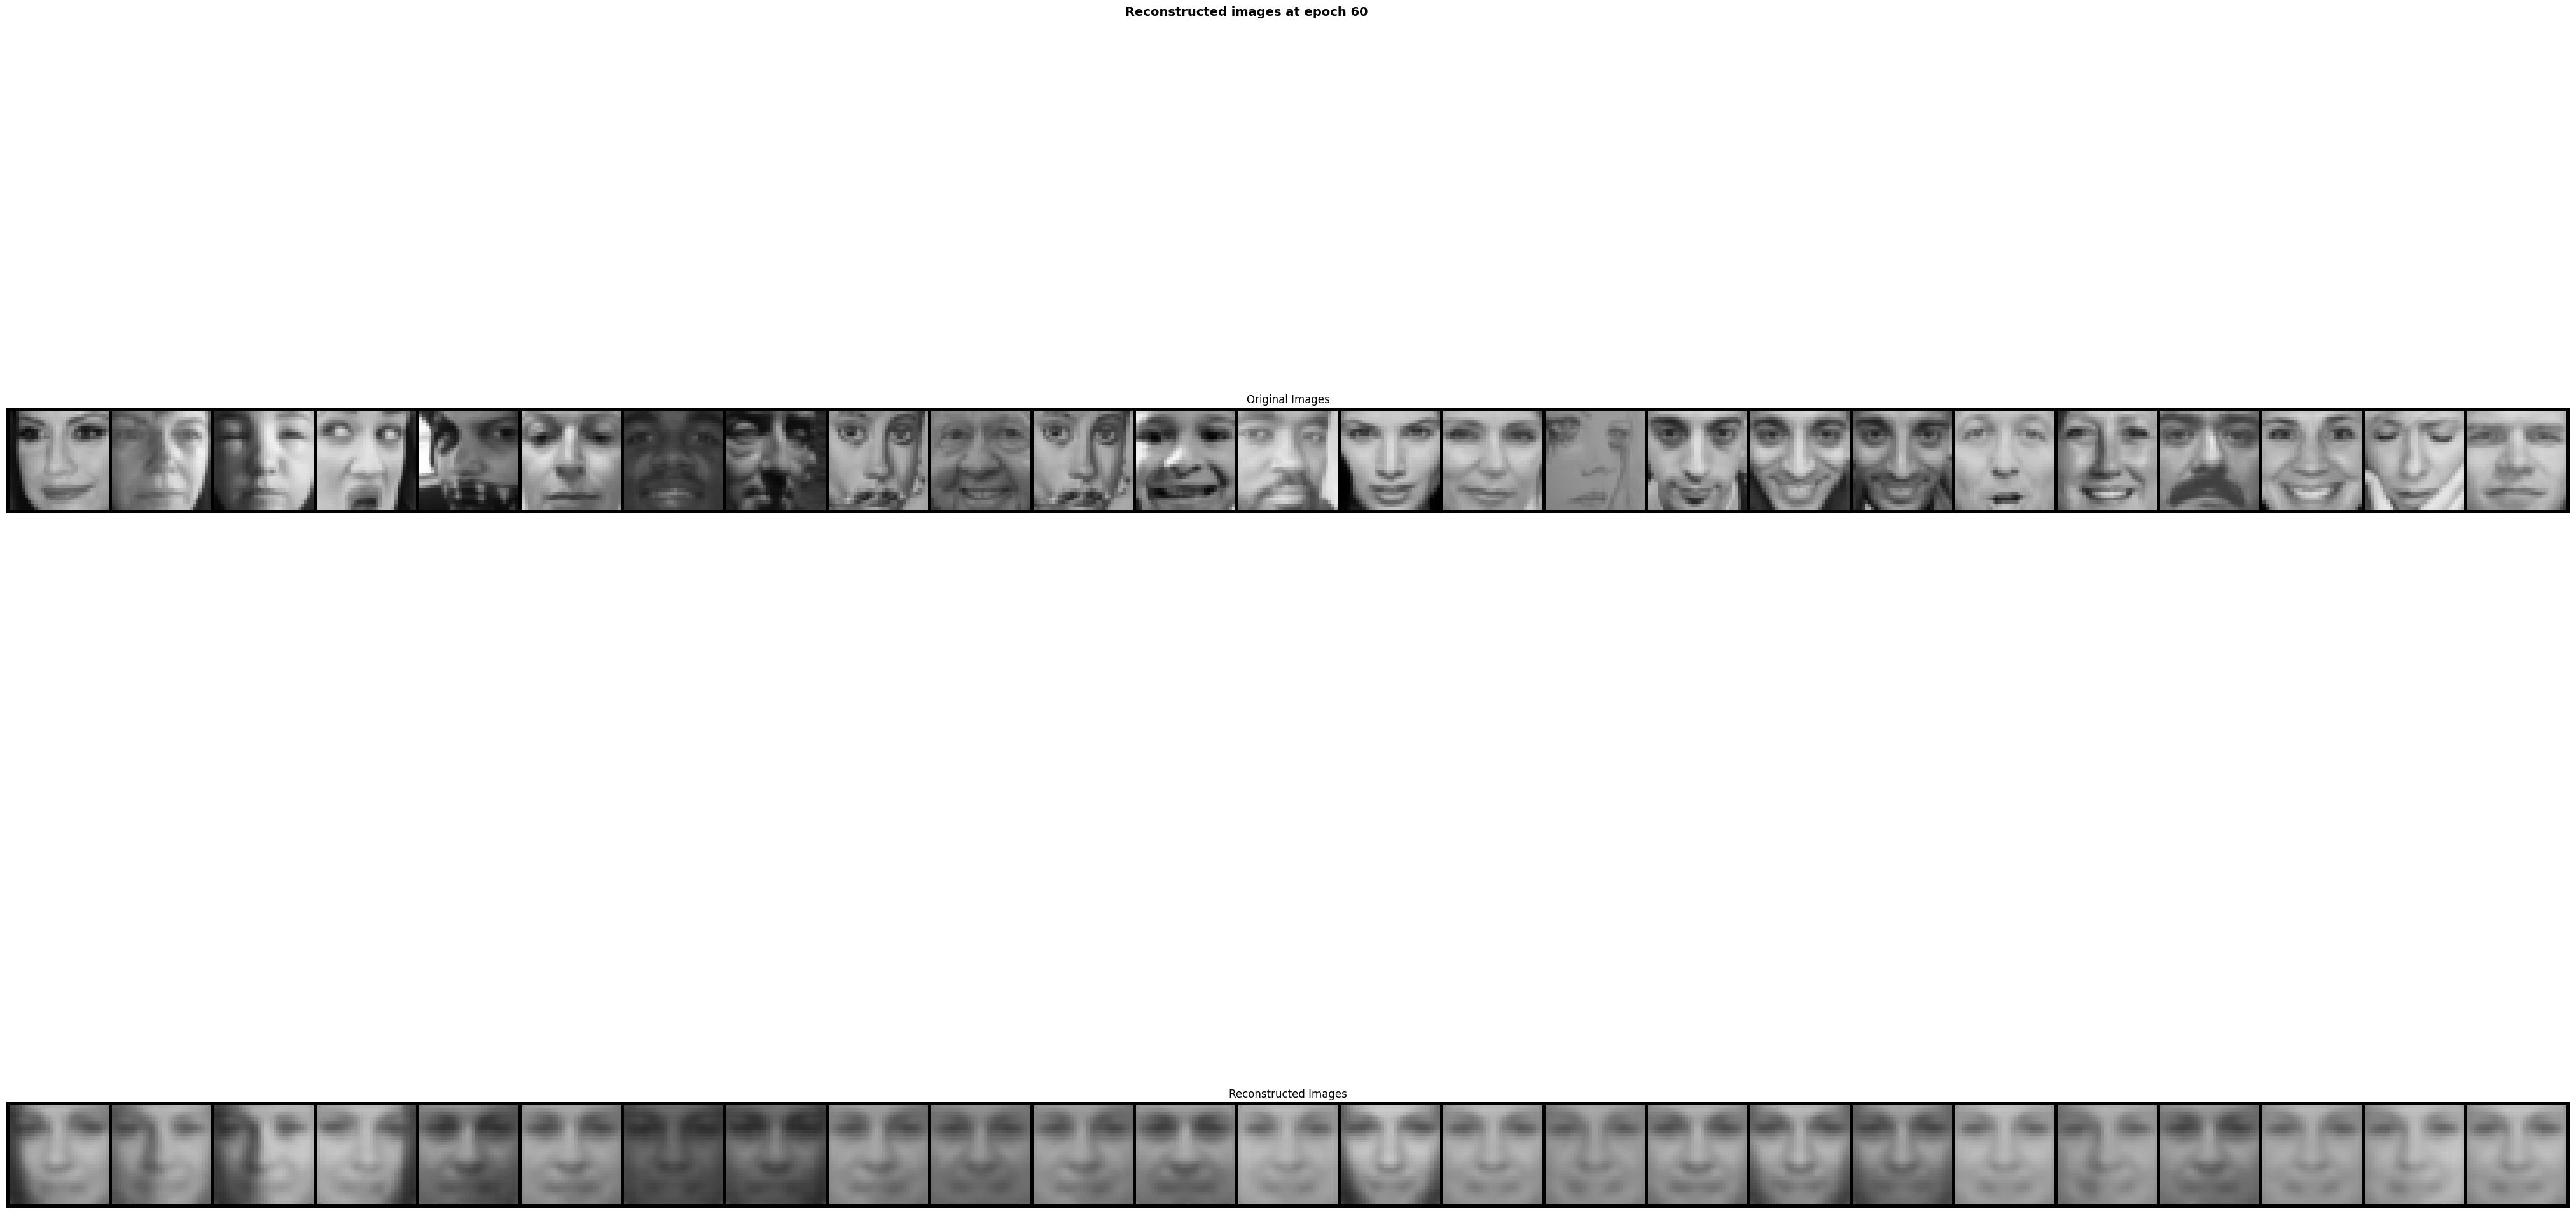

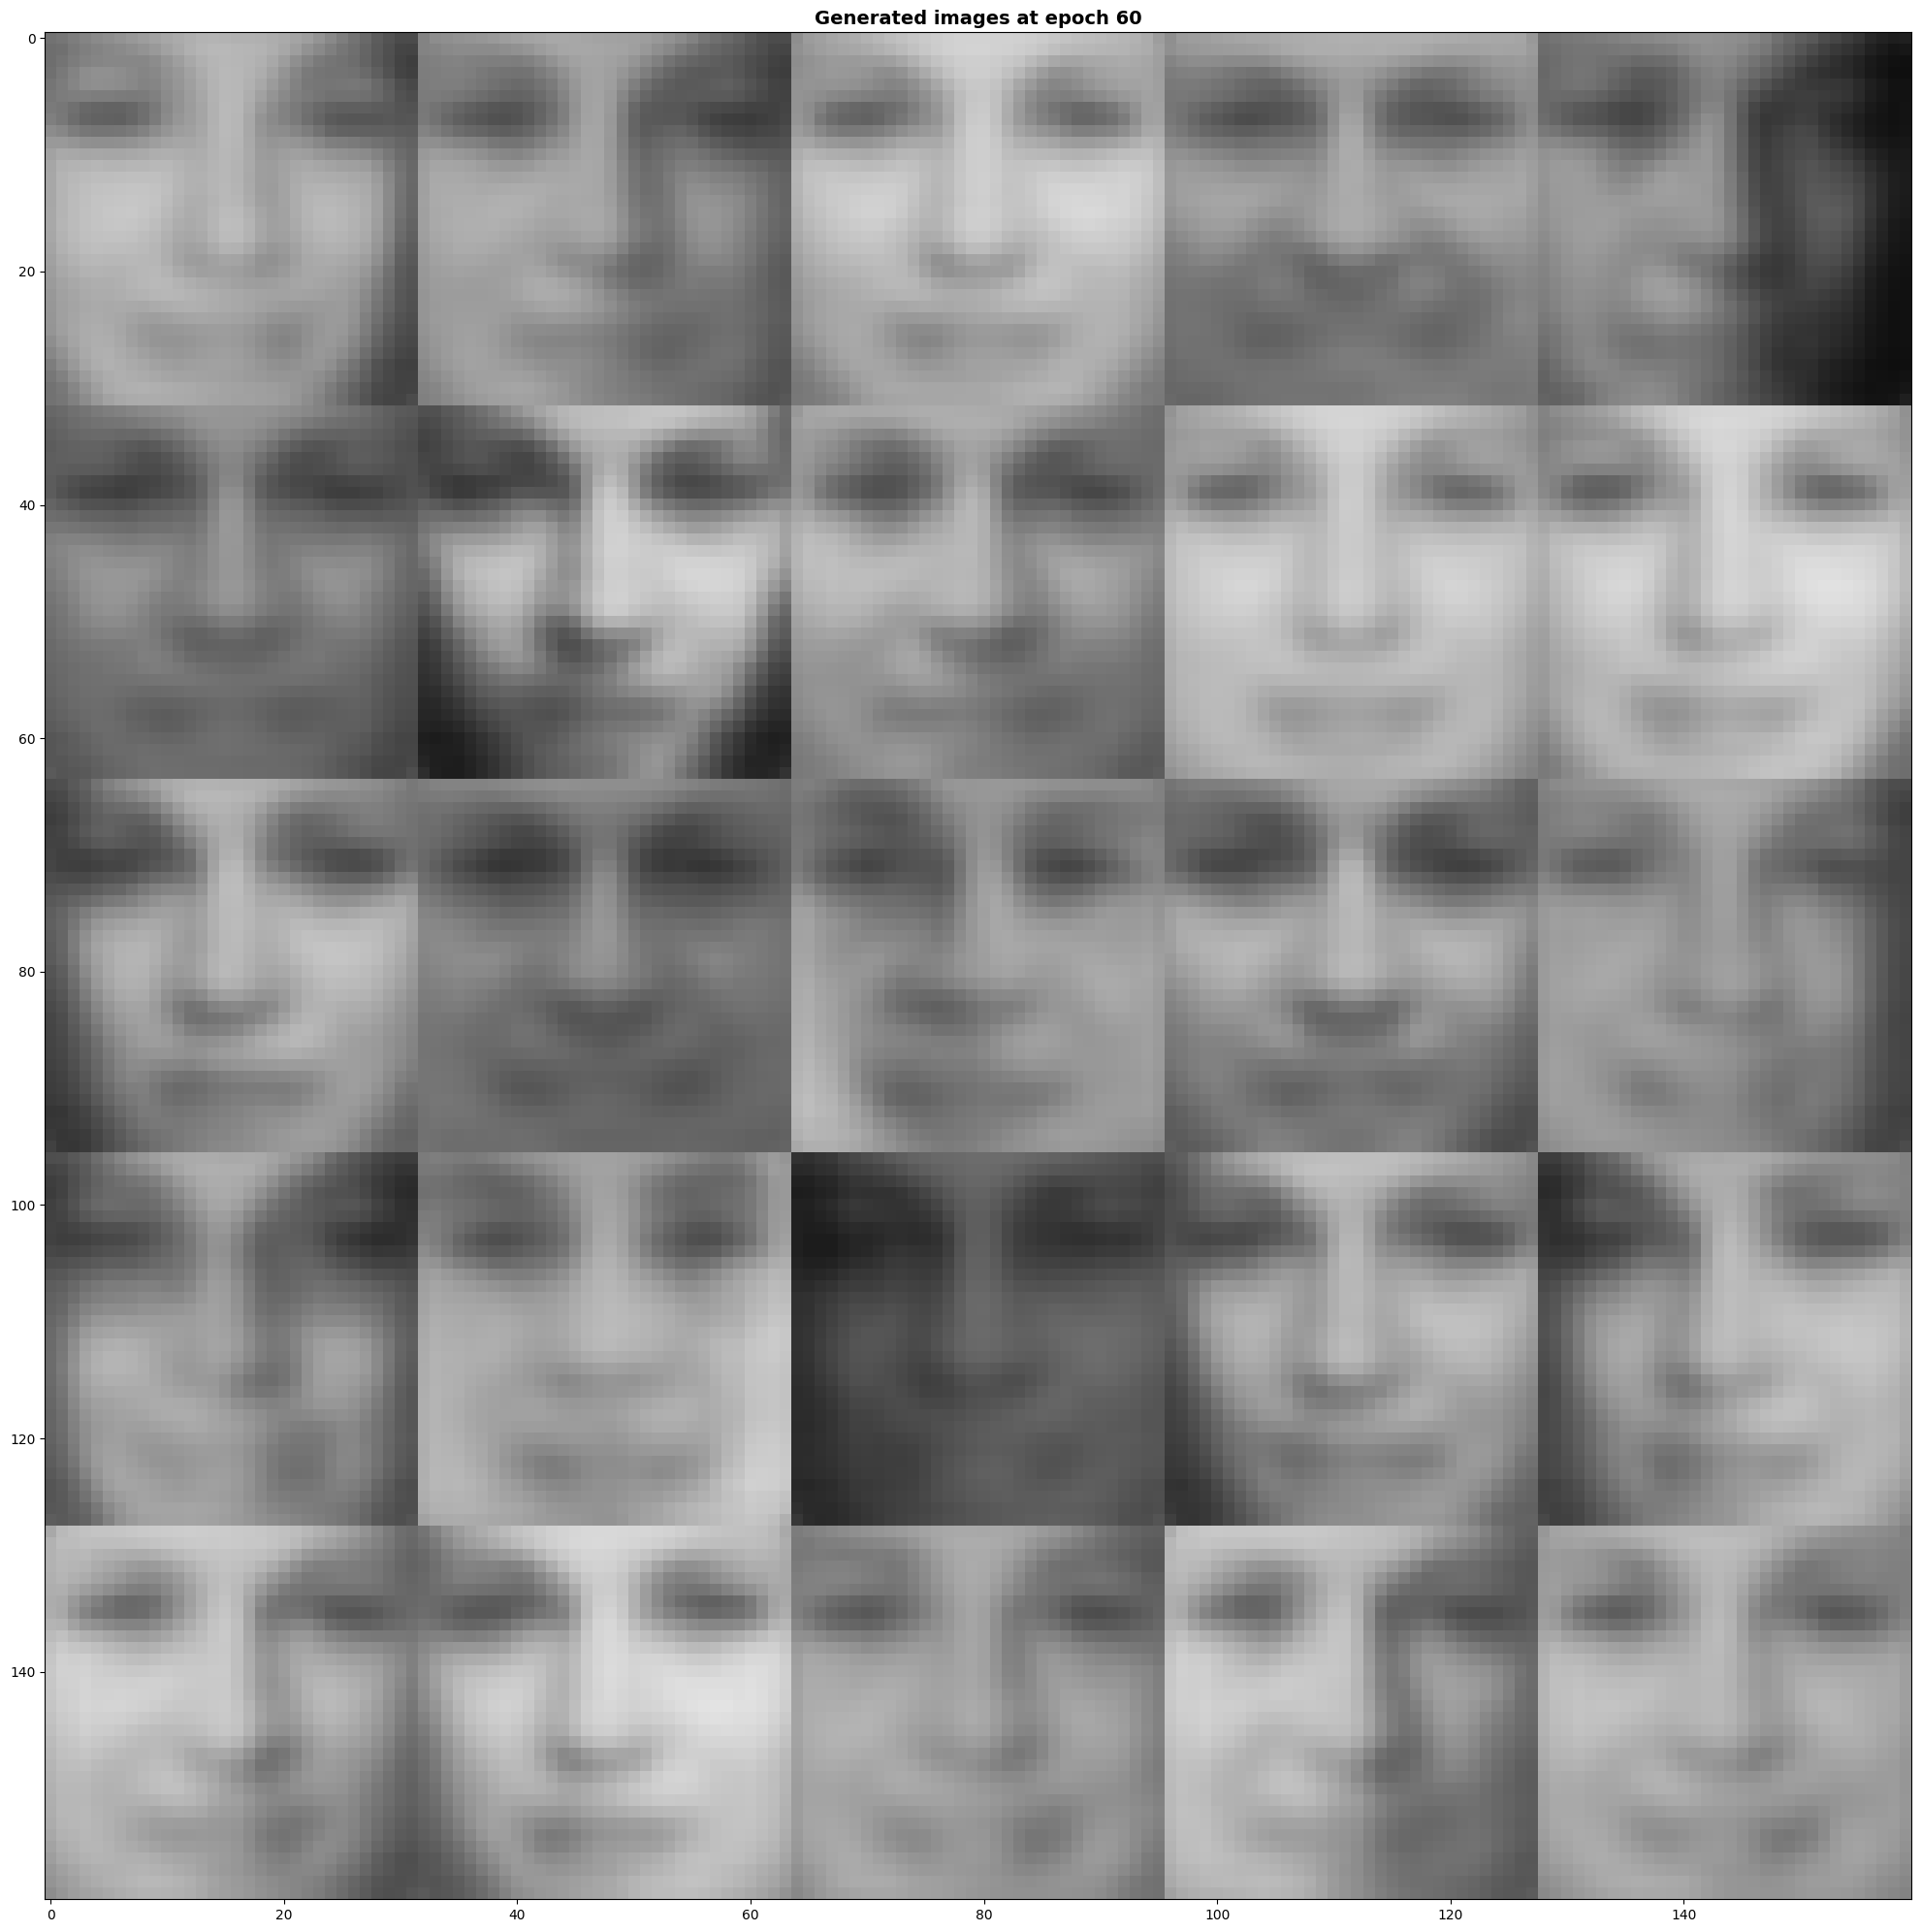

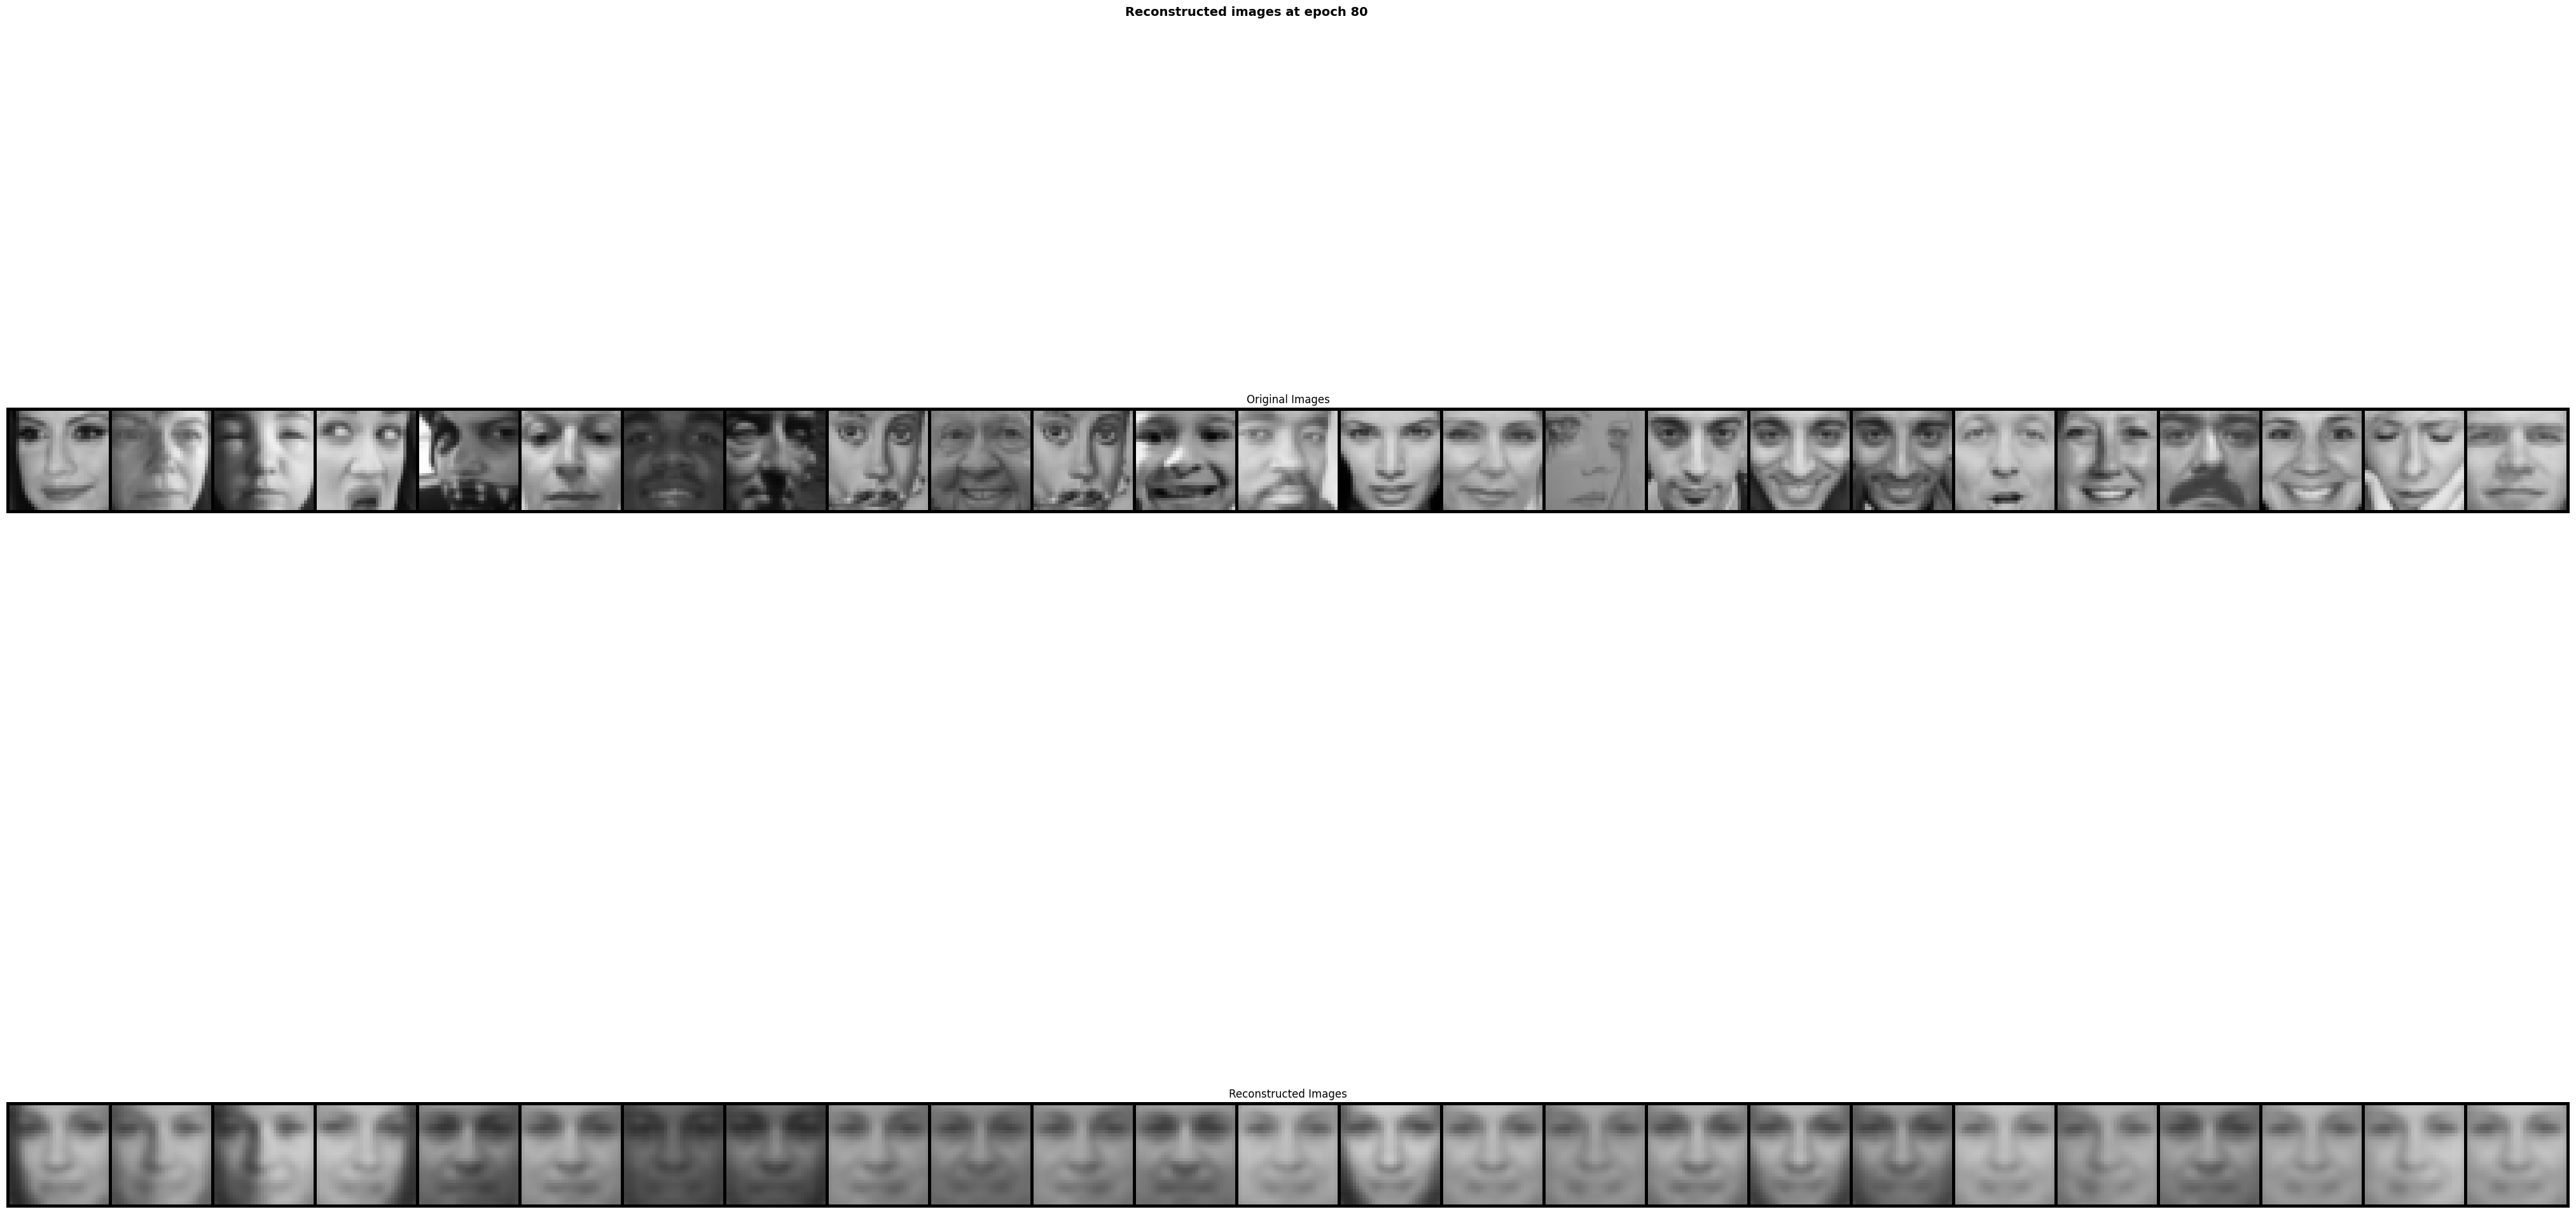

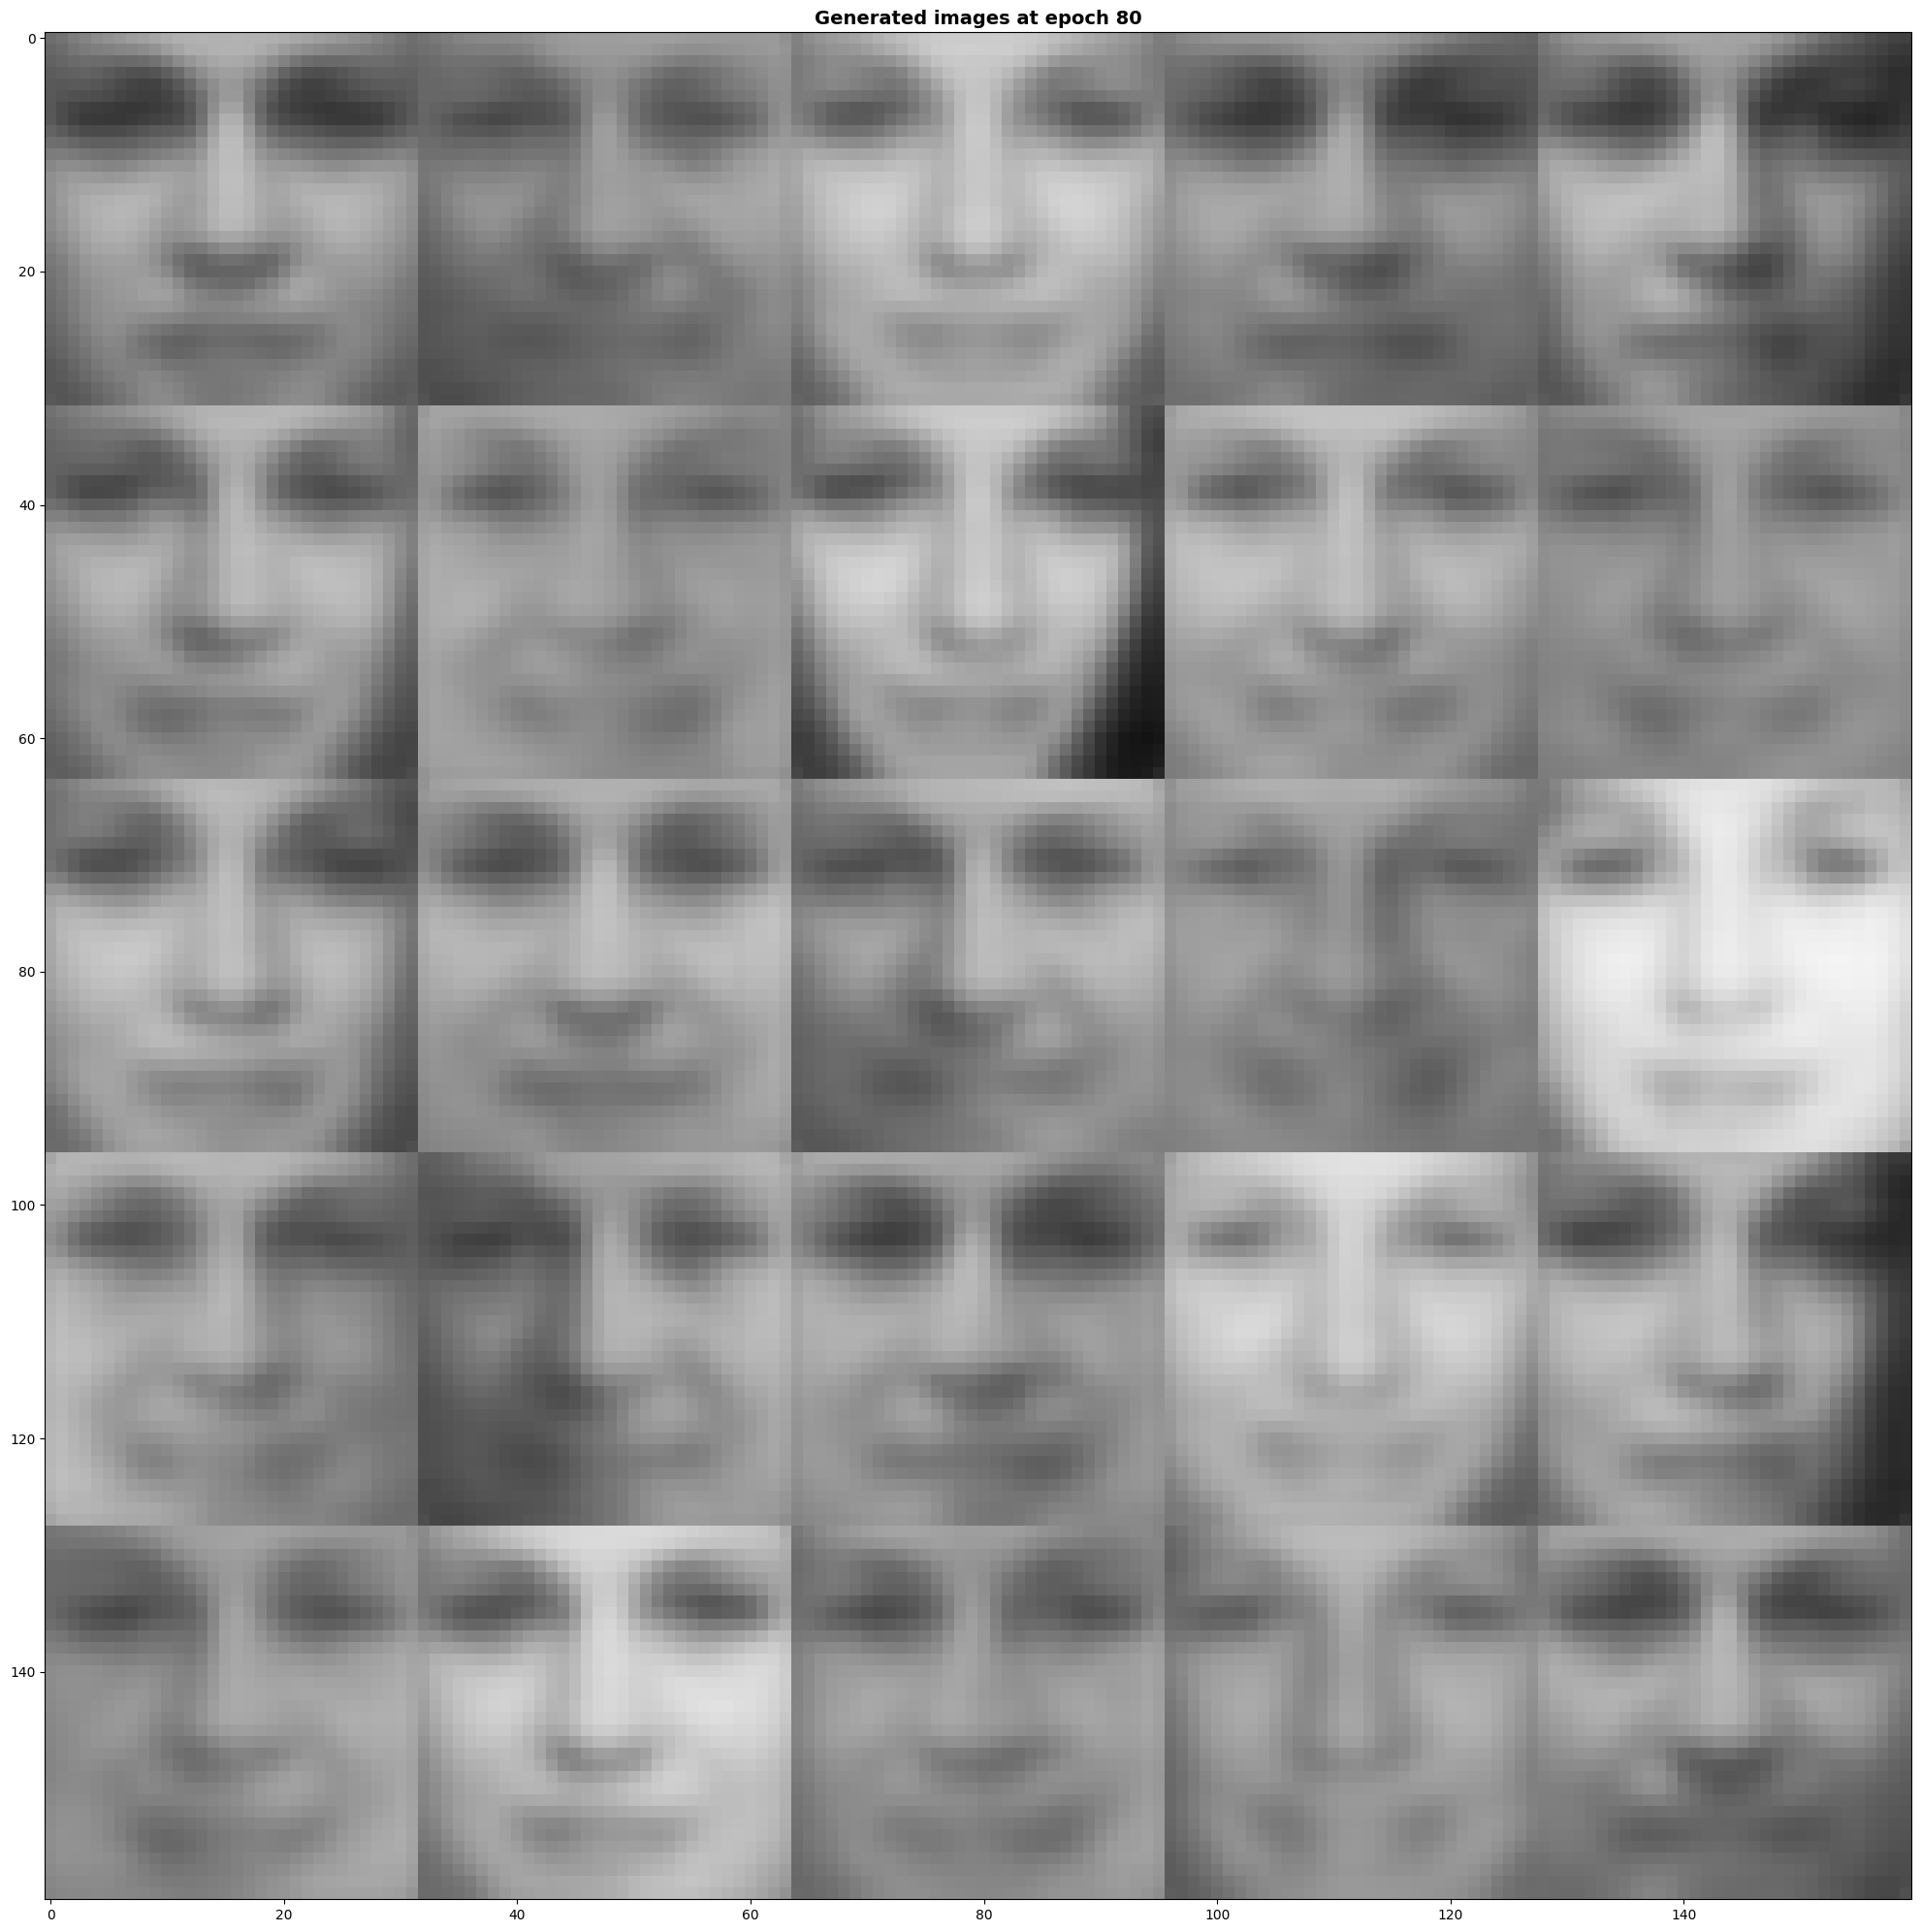

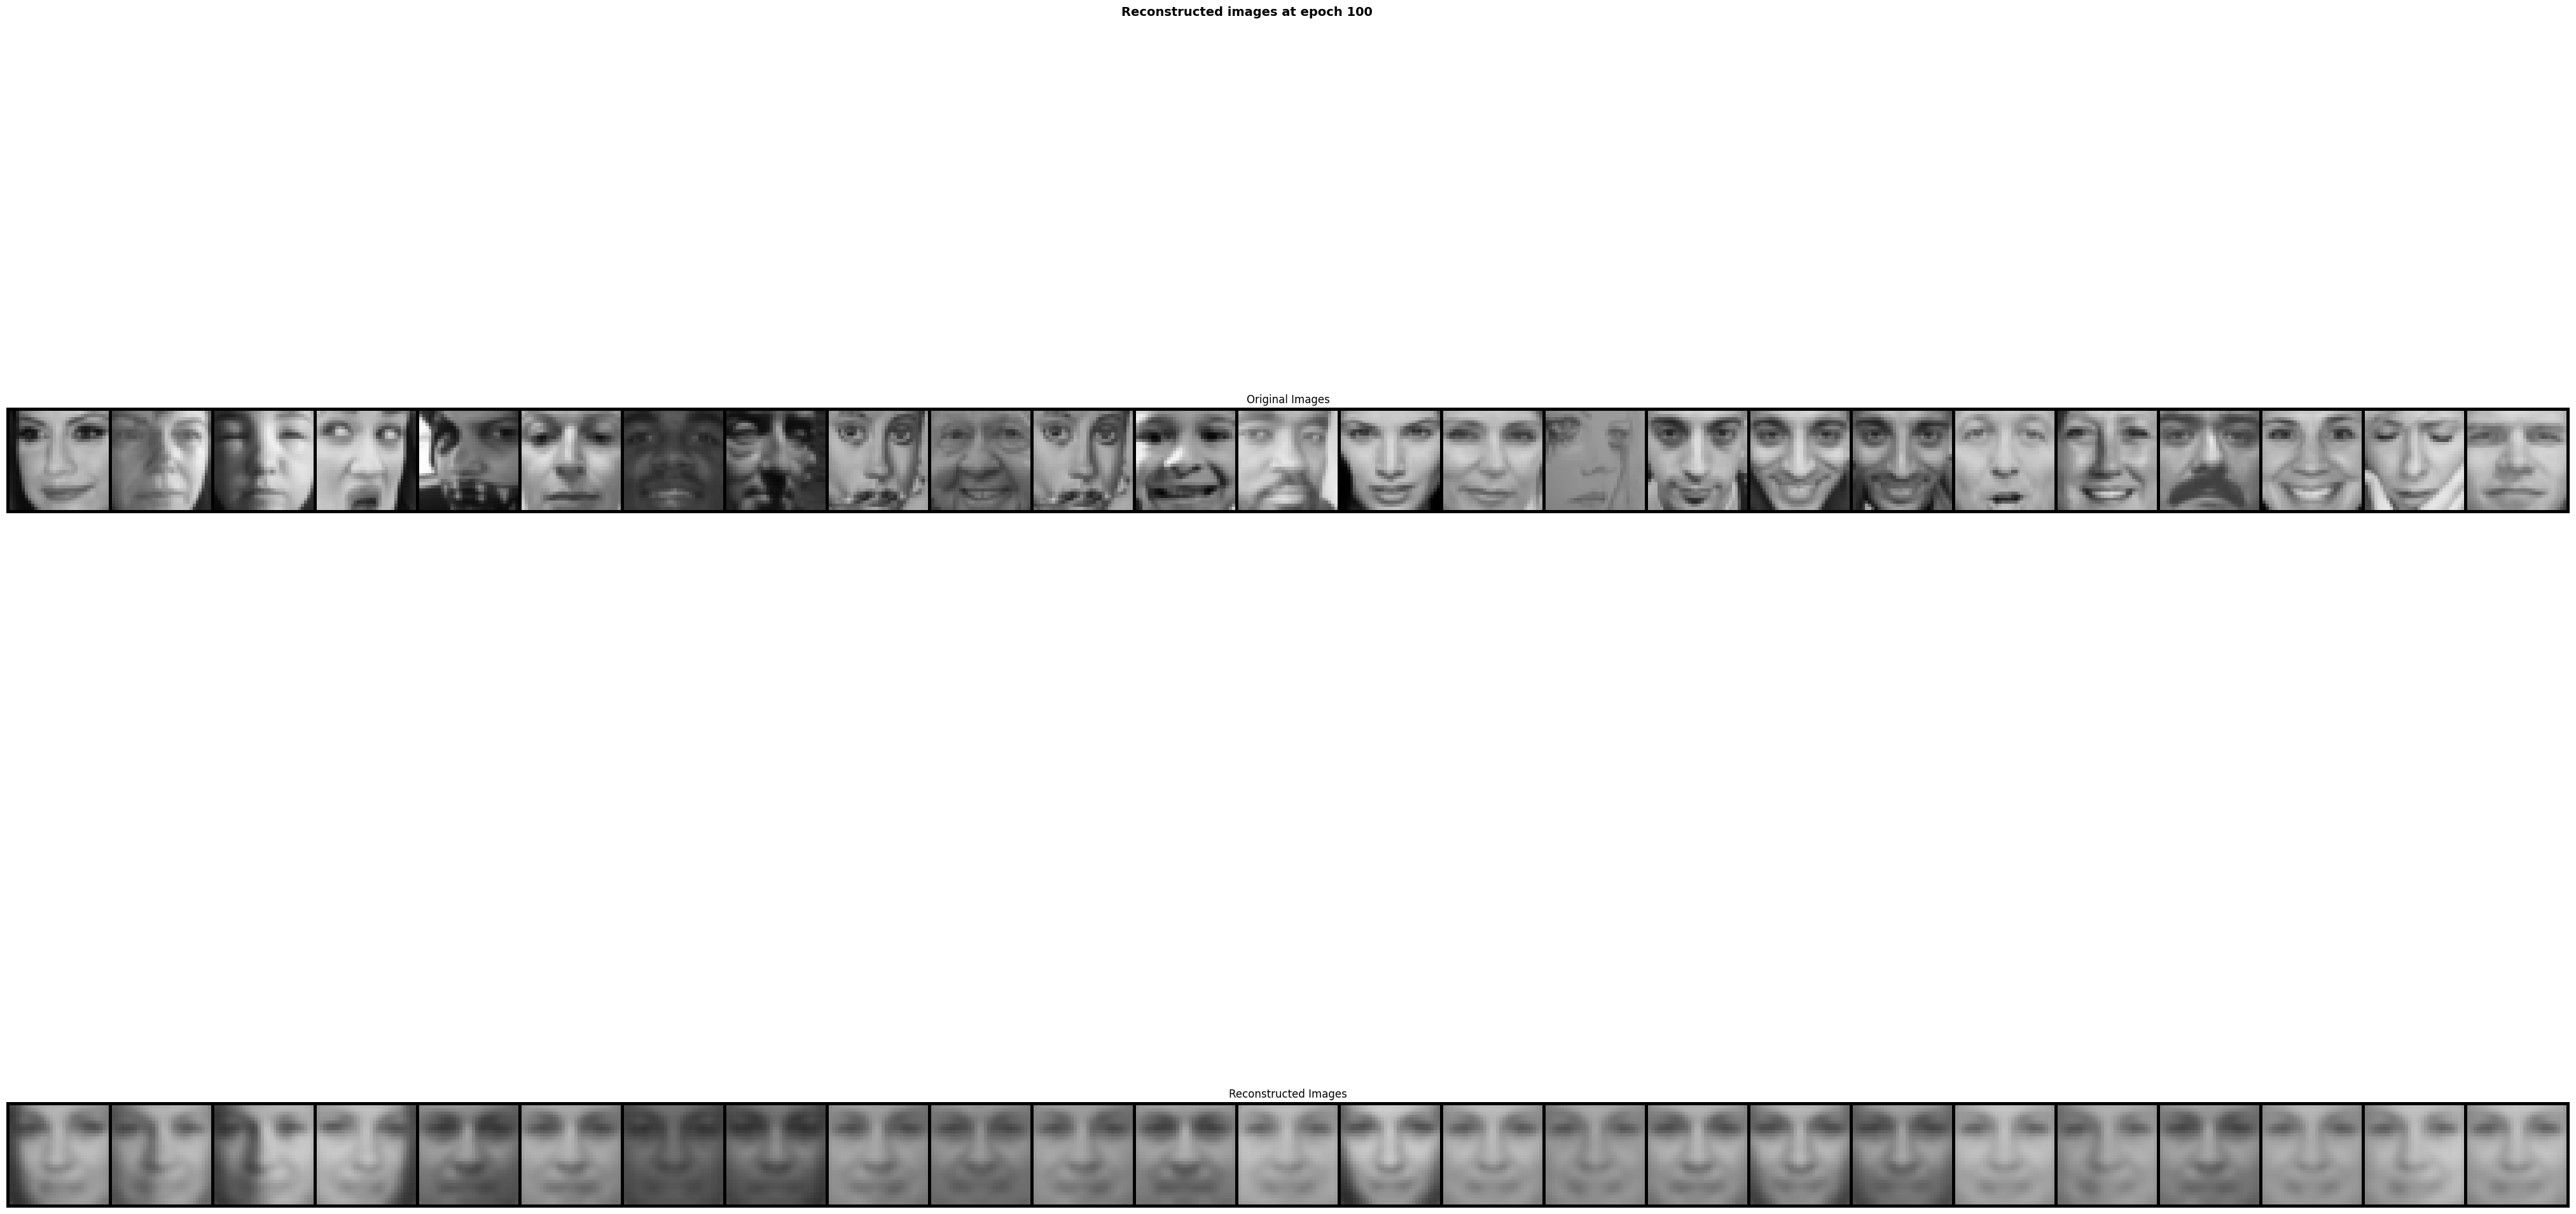

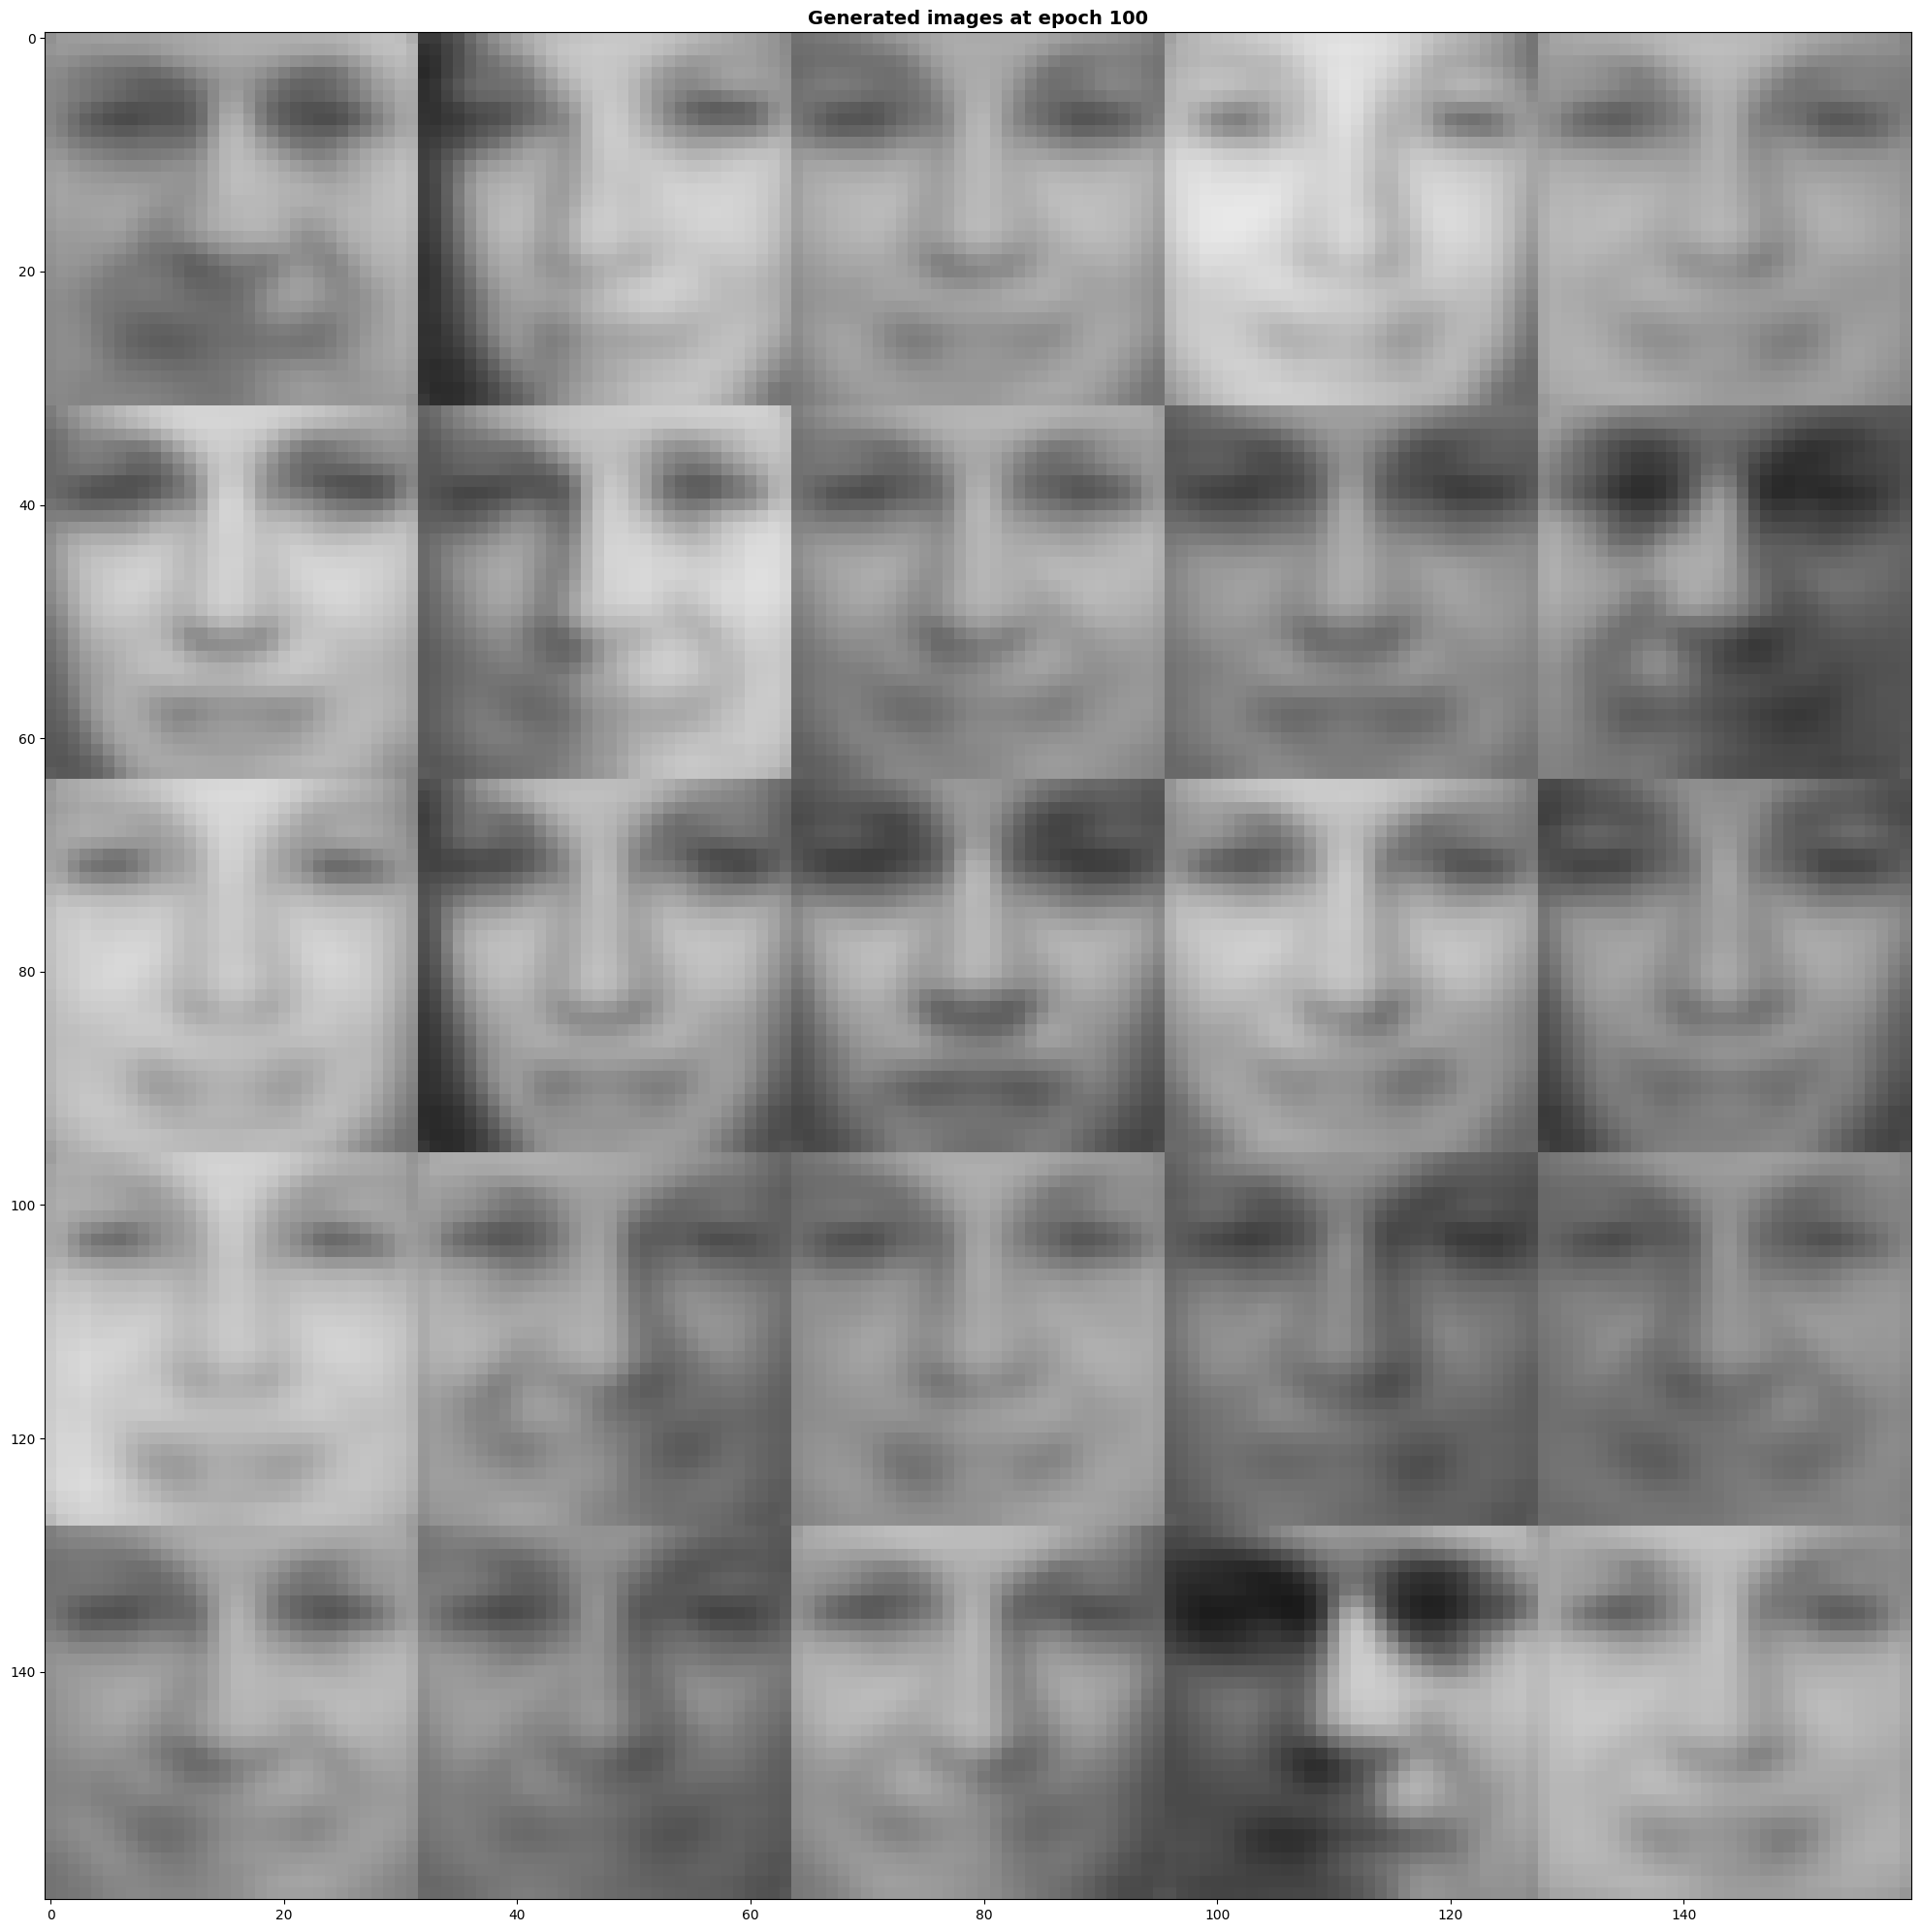

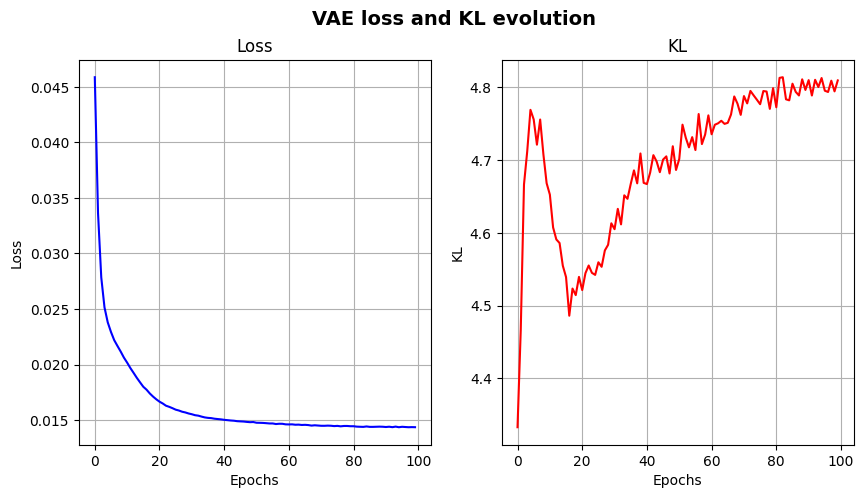

In [11]:
if train_vae:
    assert output_resolution == 32, "Using an image resolution of 64x64 requires a change in architectures/"
    
    vae = VAE(out_features=output_resolution)
    kl_weight = 0.001
    learning_rate = .0005
    # We use Adam optimizer which is tipically used in VAEs and GANs
    optimizer = torch.optim.Adam(vae.parameters(),lr = learning_rate, weight_decay=1e-5)

    print("#################### Training VAE ####################")
    loss_list, kl_list = train_VAE(vae, train_loader, test_loader, optimizer, kl_weight=kl_weight,
                        num_epochs=100, device=device, plot_every=20)

    figure, axes = plt.subplots(1, 2, figsize=(10, 5))
    figure.suptitle("VAE loss and KL evolution", fontsize=14, fontweight="bold")
    axes[0].set_title("Loss")
    axes[1].set_title("KL")
    axes[0].plot(loss_list, color="blue")
    axes[1].plot(kl_list, color="red")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("KL")
    axes[0].grid()
    axes[1].grid()

    if save_figure:
        plt.savefig(f"{results_path}/vae_loss_evolution.png", dpi=300)

    if not show_figure:
        plt.close()


# Ex. 2

1. Following the example of the MNIST , train a GAN with the images we have provided for the CK dataset.

2. For every two epochs during training:

    2.1. Generate and show a set of images from random noise z.

    2.2. Visualize a set of generated images by interpolating over the latent space z.

    2.3 Discuss the different visualizations by analysing their relation between their quality and the evolution of the discriminator and generator losses.

**Compare the results with the ones obtained with VAEs**.

In [12]:
class TrainController:
    def __init__(self, gan: GAN, train_disc_for=1, train_gen_for=1) -> None:
        assert(train_disc_for >= 1 and train_gen_for >=1)
        self.gan = gan
        self.train_disc_for = train_disc_for
        self.train_gen_for = train_gen_for
        self.counter = 0
    
    
    def is_train_generator(self) -> bool:
        train_generator = (self.counter % (self.train_gen_for + self.train_disc_for)) >= self.train_disc_for

        # # NOTE: Do not use this, strangely the results become much worse 
        # if train_generator:
        #     self.gan.generator.train()
        #     self.gan.discriminator.eval()
        # else:
        #     self.gan.generator.eval()
        #     self.gan.discriminator.train()

        self.counter += 1
        return train_generator

In [13]:
# GAN Train function. We have a generator and discriminator models and their respective optimizers.
def train_GAN(gan: GAN, train_loader, optimizer_gen, optimizer_disc,
              num_epochs=10, device='cpu', plot_every=2):
    gan.train()
    gan = gan.to(device)

    total_step = len(train_loader)
    disc_losses_list = []
    gen_losses_list = []
    
    controller = TrainController(gan, train_disc_for=1, train_gen_for=1)
    
    # Iterate over epochs
    for epoch in range(1, num_epochs + 1):
        # Decide whether to train the generator or the discriminator for the next epoch
        update_generator = controller.is_train_generator()

        # Iterate the dataset
        disc_loss_avg = 0
        gen_loss_avg = 0
        nBatches = 0

        for i, real_images in enumerate(train_loader):
            # Get batch of samples and labels
            real_images = real_images.to(device)
            n_images = real_images.shape[0]

            # Forward pass
            # Generate random images with the generator
            fake_images = gan.sample(n_images, device=device)
            
            # Use the discriminator to obtain the probabilties for real and generate imee
            prob_real = gan.discriminator(real_images)
            prob_fake = gan.discriminator(fake_images)
            
            # Generator loss
            gen_loss = -torch.log(prob_fake).mean()
            # Discriminator loss
            disc_loss = -0.5 * (torch.log(prob_real) + torch.log(1 - prob_fake)).mean()

            
            # We are going to update the discriminator and generator parameters alternatively at each iteration
            if update_generator:
                optimizer_gen.zero_grad()
                gen_loss.backward() # Necessary to not erase intermediate variables needed for computing disc_loss gradient
                optimizer_gen.step()
            else:           
                optimizer_disc.zero_grad()
                disc_loss.backward()
                optimizer_disc.step()

            disc_loss_avg += disc_loss.cpu().item()
            gen_loss_avg += gen_loss.cpu().item()

            nBatches += 1        
            # if (i+1) % 200 == 0:
            #     trained_module = "generator" if update_generator else "discriminator"
            #     print('Epoch [{}/{}], Step [{}/{}], Gen. Loss: {:.4f}, Disc Loss: {:.4f}, Trained module: {}' 
            #            .format(epoch, num_epochs, i+1, total_step, gen_loss.cpu().item(), disc_loss.cpu().item(), trained_module))
                
        # Visualize the images every two training epochs
        if epoch % plot_every == 0:
            gan.eval()
            n_samples = num_val_images # NOTE: num_val_images is a global variable
            generate_images(gan, epoch, n_samples, device=device)
            generate_interpolated(gan, epoch, n_samples, device=device)
            gan.train()

        # Print loss at the end of the epoch
        trained_module = "generator" if update_generator else "discriminator"
        print ('Epoch [{}/{}], Step [{}/{}], Gen. Loss: {:.4f}, Disc Loss: {:.4f}, Trained module: {}'
                       .format(epoch, num_epochs, i+1, total_step, gen_loss_avg / nBatches, disc_loss_avg / nBatches, trained_module))
    
        # Save model
        disc_losses_list.append(disc_loss_avg / nBatches)
        gen_losses_list.append(gen_loss_avg / nBatches)
        torch.save(gan.state_dict(), f"{results_path}/{gan.name}_ck.ckpt")
          
    return disc_losses_list, gen_losses_list



#################### Training GAN ####################
Epoch [1/2000], Step [20/20], Gen. Loss: 2.3627, Disc Loss: 0.2235, Trained module: discriminator
Epoch [2/2000], Step [20/20], Gen. Loss: 0.7122, Disc Loss: 0.9079, Trained module: generator
Epoch [3/2000], Step [20/20], Gen. Loss: 3.5114, Disc Loss: 0.2035, Trained module: discriminator
Epoch [4/2000], Step [20/20], Gen. Loss: 0.7717, Disc Loss: 1.0239, Trained module: generator
Epoch [5/2000], Step [20/20], Gen. Loss: 4.1665, Disc Loss: 0.1934, Trained module: discriminator
Epoch [6/2000], Step [20/20], Gen. Loss: 0.9753, Disc Loss: 0.8317, Trained module: generator
Epoch [7/2000], Step [20/20], Gen. Loss: 4.5620, Disc Loss: 0.1688, Trained module: discriminator
Epoch [8/2000], Step [20/20], Gen. Loss: 1.1751, Disc Loss: 0.7622, Trained module: generator
Epoch [9/2000], Step [20/20], Gen. Loss: 4.8456, Disc Loss: 0.1626, Trained module: discriminator
Epoch [10/2000], Step [20/20], Gen. Loss: 1.2614, Disc Loss: 0.8209, Trained 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [200/2000], Step [20/20], Gen. Loss: 0.3647, Disc Loss: 1.1917, Trained module: generator
Epoch [201/2000], Step [20/20], Gen. Loss: 2.2837, Disc Loss: 0.3149, Trained module: discriminator
Epoch [202/2000], Step [20/20], Gen. Loss: 0.3527, Disc Loss: 1.2392, Trained module: generator
Epoch [203/2000], Step [20/20], Gen. Loss: 2.2150, Disc Loss: 0.3319, Trained module: discriminator
Epoch [204/2000], Step [20/20], Gen. Loss: 0.3648, Disc Loss: 1.1904, Trained module: generator
Epoch [205/2000], Step [20/20], Gen. Loss: 2.2110, Disc Loss: 0.3252, Trained module: discriminator
Epoch [206/2000], Step [20/20], Gen. Loss: 0.3510, Disc Loss: 1.2283, Trained module: generator
Epoch [207/2000], Step [20/20], Gen. Loss: 2.2199, Disc Loss: 0.3292, Trained module: discriminator
Epoch [208/2000], Step [20/20], Gen. Loss: 0.3605, Disc Loss: 1.1883, Trained module: generator
Epoch [209/2000], Step [20/20], Gen. Loss: 2.1691, Disc Loss: 0.3297, Trained module: discriminator
Epoch [210/2000], St

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [400/2000], Step [20/20], Gen. Loss: 0.4030, Disc Loss: 1.1449, Trained module: generator
Epoch [401/2000], Step [20/20], Gen. Loss: 2.4753, Disc Loss: 0.3079, Trained module: discriminator
Epoch [402/2000], Step [20/20], Gen. Loss: 0.3832, Disc Loss: 1.1571, Trained module: generator
Epoch [403/2000], Step [20/20], Gen. Loss: 2.3166, Disc Loss: 0.3160, Trained module: discriminator
Epoch [404/2000], Step [20/20], Gen. Loss: 0.3943, Disc Loss: 1.1198, Trained module: generator
Epoch [405/2000], Step [20/20], Gen. Loss: 2.3509, Disc Loss: 0.3141, Trained module: discriminator
Epoch [406/2000], Step [20/20], Gen. Loss: 0.4211, Disc Loss: 1.0626, Trained module: generator
Epoch [407/2000], Step [20/20], Gen. Loss: 2.2185, Disc Loss: 0.3209, Trained module: discriminator
Epoch [408/2000], Step [20/20], Gen. Loss: 0.4122, Disc Loss: 1.0862, Trained module: generator
Epoch [409/2000], Step [20/20], Gen. Loss: 2.3665, Disc Loss: 0.3146, Trained module: discriminator
Epoch [410/2000], St

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [600/2000], Step [20/20], Gen. Loss: 0.4483, Disc Loss: 1.0159, Trained module: generator
Epoch [601/2000], Step [20/20], Gen. Loss: 2.7514, Disc Loss: 0.2642, Trained module: discriminator
Epoch [602/2000], Step [20/20], Gen. Loss: 0.4528, Disc Loss: 1.0393, Trained module: generator
Epoch [603/2000], Step [20/20], Gen. Loss: 2.5611, Disc Loss: 0.2783, Trained module: discriminator
Epoch [604/2000], Step [20/20], Gen. Loss: 0.4467, Disc Loss: 1.0237, Trained module: generator
Epoch [605/2000], Step [20/20], Gen. Loss: 2.6958, Disc Loss: 0.2729, Trained module: discriminator
Epoch [606/2000], Step [20/20], Gen. Loss: 0.4677, Disc Loss: 0.9931, Trained module: generator
Epoch [607/2000], Step [20/20], Gen. Loss: 2.5523, Disc Loss: 0.2771, Trained module: discriminator
Epoch [608/2000], Step [20/20], Gen. Loss: 0.4674, Disc Loss: 0.9772, Trained module: generator
Epoch [609/2000], Step [20/20], Gen. Loss: 2.7247, Disc Loss: 0.2636, Trained module: discriminator
Epoch [610/2000], St

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [800/2000], Step [20/20], Gen. Loss: 0.5777, Disc Loss: 0.8496, Trained module: generator
Epoch [801/2000], Step [20/20], Gen. Loss: 2.9026, Disc Loss: 0.2435, Trained module: discriminator
Epoch [802/2000], Step [20/20], Gen. Loss: 0.5422, Disc Loss: 0.9231, Trained module: generator
Epoch [803/2000], Step [20/20], Gen. Loss: 2.8074, Disc Loss: 0.2532, Trained module: discriminator
Epoch [804/2000], Step [20/20], Gen. Loss: 0.5035, Disc Loss: 0.9705, Trained module: generator
Epoch [805/2000], Step [20/20], Gen. Loss: 2.8949, Disc Loss: 0.2470, Trained module: discriminator
Epoch [806/2000], Step [20/20], Gen. Loss: 0.5183, Disc Loss: 0.9981, Trained module: generator
Epoch [807/2000], Step [20/20], Gen. Loss: 2.8152, Disc Loss: 0.2635, Trained module: discriminator
Epoch [808/2000], Step [20/20], Gen. Loss: 0.5435, Disc Loss: 0.9380, Trained module: generator
Epoch [809/2000], Step [20/20], Gen. Loss: 3.0180, Disc Loss: 0.2416, Trained module: discriminator
Epoch [810/2000], St

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [1000/2000], Step [20/20], Gen. Loss: 0.5199, Disc Loss: 0.9589, Trained module: generator
Epoch [1001/2000], Step [20/20], Gen. Loss: 3.1690, Disc Loss: 0.2392, Trained module: discriminator
Epoch [1002/2000], Step [20/20], Gen. Loss: 0.5454, Disc Loss: 0.9581, Trained module: generator
Epoch [1003/2000], Step [20/20], Gen. Loss: 3.0444, Disc Loss: 0.2462, Trained module: discriminator
Epoch [1004/2000], Step [20/20], Gen. Loss: 0.5196, Disc Loss: 0.9580, Trained module: generator
Epoch [1005/2000], Step [20/20], Gen. Loss: 3.1410, Disc Loss: 0.2402, Trained module: discriminator
Epoch [1006/2000], Step [20/20], Gen. Loss: 0.5327, Disc Loss: 0.9629, Trained module: generator
Epoch [1007/2000], Step [20/20], Gen. Loss: 3.0035, Disc Loss: 0.2447, Trained module: discriminator
Epoch [1008/2000], Step [20/20], Gen. Loss: 0.5045, Disc Loss: 0.9825, Trained module: generator
Epoch [1009/2000], Step [20/20], Gen. Loss: 3.1737, Disc Loss: 0.2394, Trained module: discriminator
Epoch [101

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [1200/2000], Step [20/20], Gen. Loss: 0.5263, Disc Loss: 1.0055, Trained module: generator
Epoch [1201/2000], Step [20/20], Gen. Loss: 3.2732, Disc Loss: 0.2390, Trained module: discriminator
Epoch [1202/2000], Step [20/20], Gen. Loss: 0.5641, Disc Loss: 0.9568, Trained module: generator
Epoch [1203/2000], Step [20/20], Gen. Loss: 3.2487, Disc Loss: 0.2340, Trained module: discriminator
Epoch [1204/2000], Step [20/20], Gen. Loss: 0.5253, Disc Loss: 1.0325, Trained module: generator
Epoch [1205/2000], Step [20/20], Gen. Loss: 3.2431, Disc Loss: 0.2398, Trained module: discriminator
Epoch [1206/2000], Step [20/20], Gen. Loss: 0.5881, Disc Loss: 0.9376, Trained module: generator
Epoch [1207/2000], Step [20/20], Gen. Loss: 3.1699, Disc Loss: 0.2429, Trained module: discriminator
Epoch [1208/2000], Step [20/20], Gen. Loss: 0.5309, Disc Loss: 0.9938, Trained module: generator
Epoch [1209/2000], Step [20/20], Gen. Loss: 3.1495, Disc Loss: 0.2440, Trained module: discriminator
Epoch [121

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [1400/2000], Step [20/20], Gen. Loss: 0.5654, Disc Loss: 0.9586, Trained module: generator
Epoch [1401/2000], Step [20/20], Gen. Loss: 3.3782, Disc Loss: 0.2322, Trained module: discriminator
Epoch [1402/2000], Step [20/20], Gen. Loss: 0.5688, Disc Loss: 0.9521, Trained module: generator
Epoch [1403/2000], Step [20/20], Gen. Loss: 3.2789, Disc Loss: 0.2308, Trained module: discriminator
Epoch [1404/2000], Step [20/20], Gen. Loss: 0.5658, Disc Loss: 0.9511, Trained module: generator
Epoch [1405/2000], Step [20/20], Gen. Loss: 3.3998, Disc Loss: 0.2257, Trained module: discriminator
Epoch [1406/2000], Step [20/20], Gen. Loss: 0.5886, Disc Loss: 0.9241, Trained module: generator
Epoch [1407/2000], Step [20/20], Gen. Loss: 3.2745, Disc Loss: 0.2318, Trained module: discriminator
Epoch [1408/2000], Step [20/20], Gen. Loss: 0.5901, Disc Loss: 0.9180, Trained module: generator
Epoch [1409/2000], Step [20/20], Gen. Loss: 3.3814, Disc Loss: 0.2244, Trained module: discriminator
Epoch [141

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [1600/2000], Step [20/20], Gen. Loss: 0.6057, Disc Loss: 0.9240, Trained module: generator
Epoch [1601/2000], Step [20/20], Gen. Loss: 3.4768, Disc Loss: 0.2234, Trained module: discriminator
Epoch [1602/2000], Step [20/20], Gen. Loss: 0.5863, Disc Loss: 0.9348, Trained module: generator
Epoch [1603/2000], Step [20/20], Gen. Loss: 3.5128, Disc Loss: 0.2231, Trained module: discriminator
Epoch [1604/2000], Step [20/20], Gen. Loss: 0.5988, Disc Loss: 0.9223, Trained module: generator
Epoch [1605/2000], Step [20/20], Gen. Loss: 3.5250, Disc Loss: 0.2223, Trained module: discriminator
Epoch [1606/2000], Step [20/20], Gen. Loss: 0.5820, Disc Loss: 0.9379, Trained module: generator
Epoch [1607/2000], Step [20/20], Gen. Loss: 3.4523, Disc Loss: 0.2256, Trained module: discriminator
Epoch [1608/2000], Step [20/20], Gen. Loss: 0.5784, Disc Loss: 0.9656, Trained module: generator
Epoch [1609/2000], Step [20/20], Gen. Loss: 3.5196, Disc Loss: 0.2238, Trained module: discriminator
Epoch [161

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [1800/2000], Step [20/20], Gen. Loss: 0.6190, Disc Loss: 0.9092, Trained module: generator
Epoch [1801/2000], Step [20/20], Gen. Loss: 3.4983, Disc Loss: 0.2247, Trained module: discriminator
Epoch [1802/2000], Step [20/20], Gen. Loss: 0.6169, Disc Loss: 0.9316, Trained module: generator
Epoch [1803/2000], Step [20/20], Gen. Loss: 3.6595, Disc Loss: 0.2165, Trained module: discriminator
Epoch [1804/2000], Step [20/20], Gen. Loss: 0.6030, Disc Loss: 0.9310, Trained module: generator
Epoch [1805/2000], Step [20/20], Gen. Loss: 3.3941, Disc Loss: 0.2273, Trained module: discriminator
Epoch [1806/2000], Step [20/20], Gen. Loss: 0.6195, Disc Loss: 0.9433, Trained module: generator
Epoch [1807/2000], Step [20/20], Gen. Loss: 3.6271, Disc Loss: 0.2210, Trained module: discriminator
Epoch [1808/2000], Step [20/20], Gen. Loss: 0.5991, Disc Loss: 0.9597, Trained module: generator
Epoch [1809/2000], Step [20/20], Gen. Loss: 3.3703, Disc Loss: 0.2316, Trained module: discriminator
Epoch [181

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [2000/2000], Step [20/20], Gen. Loss: 0.6457, Disc Loss: 0.9006, Trained module: generator


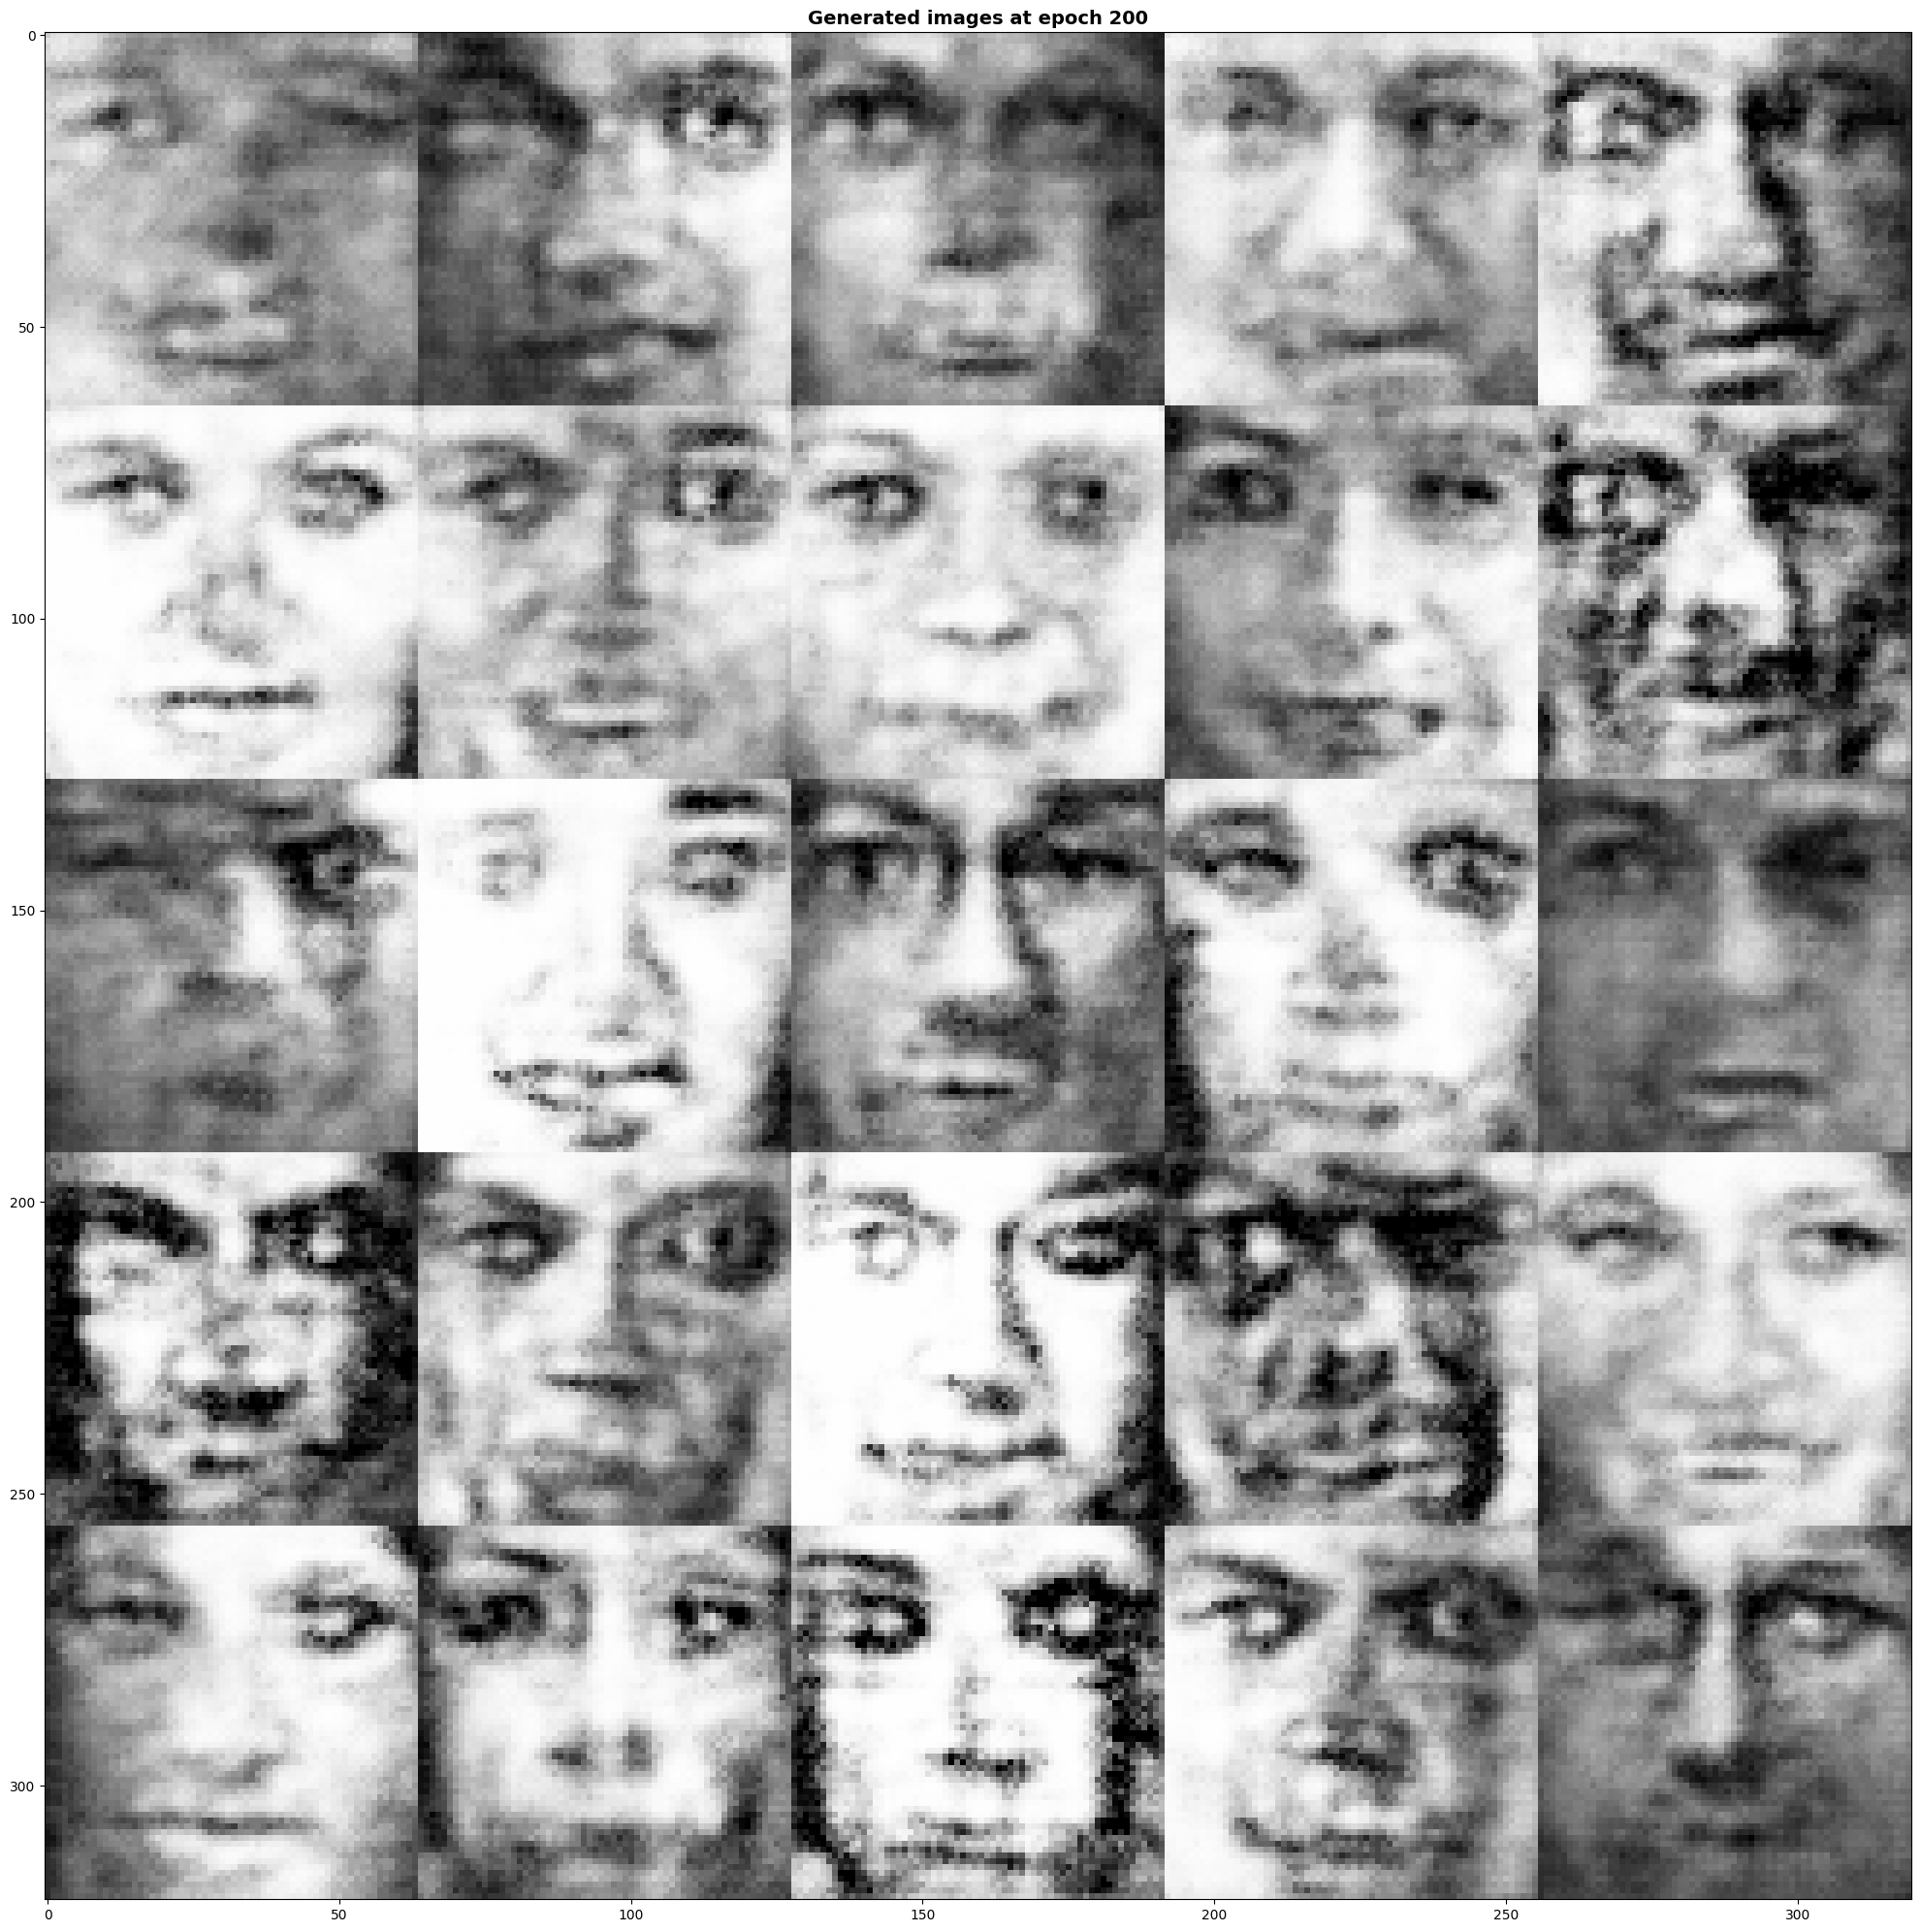

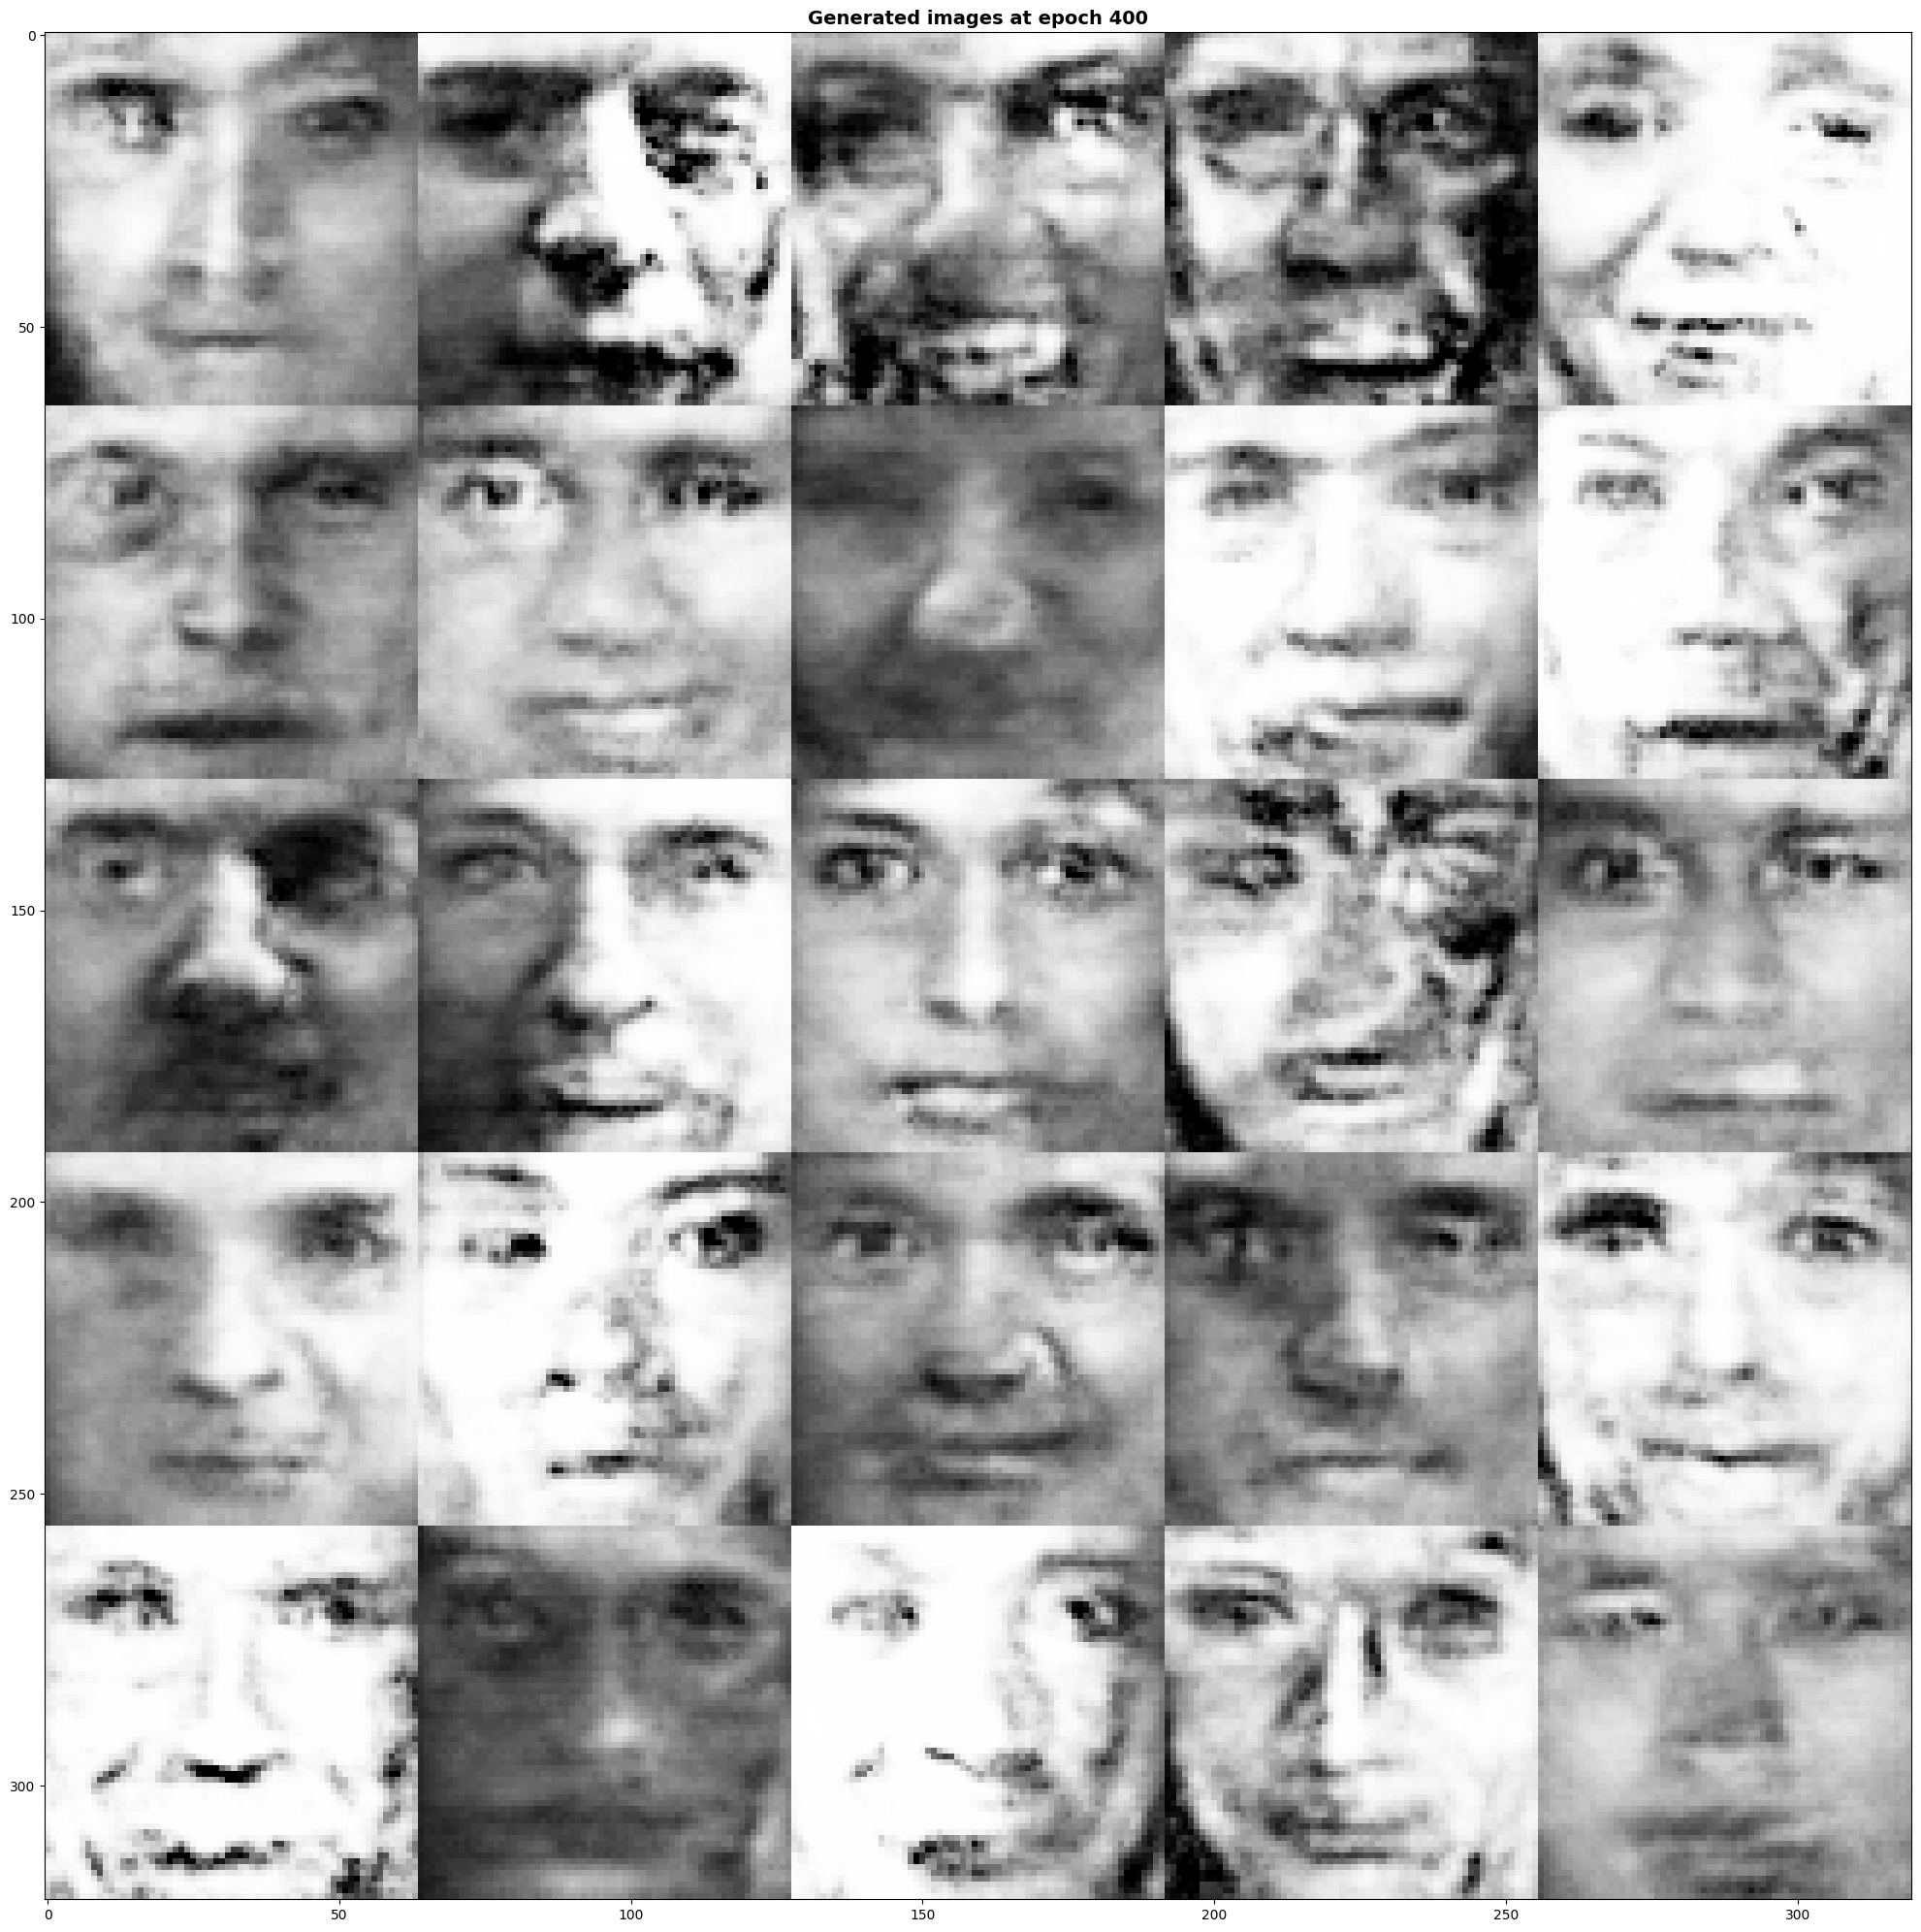

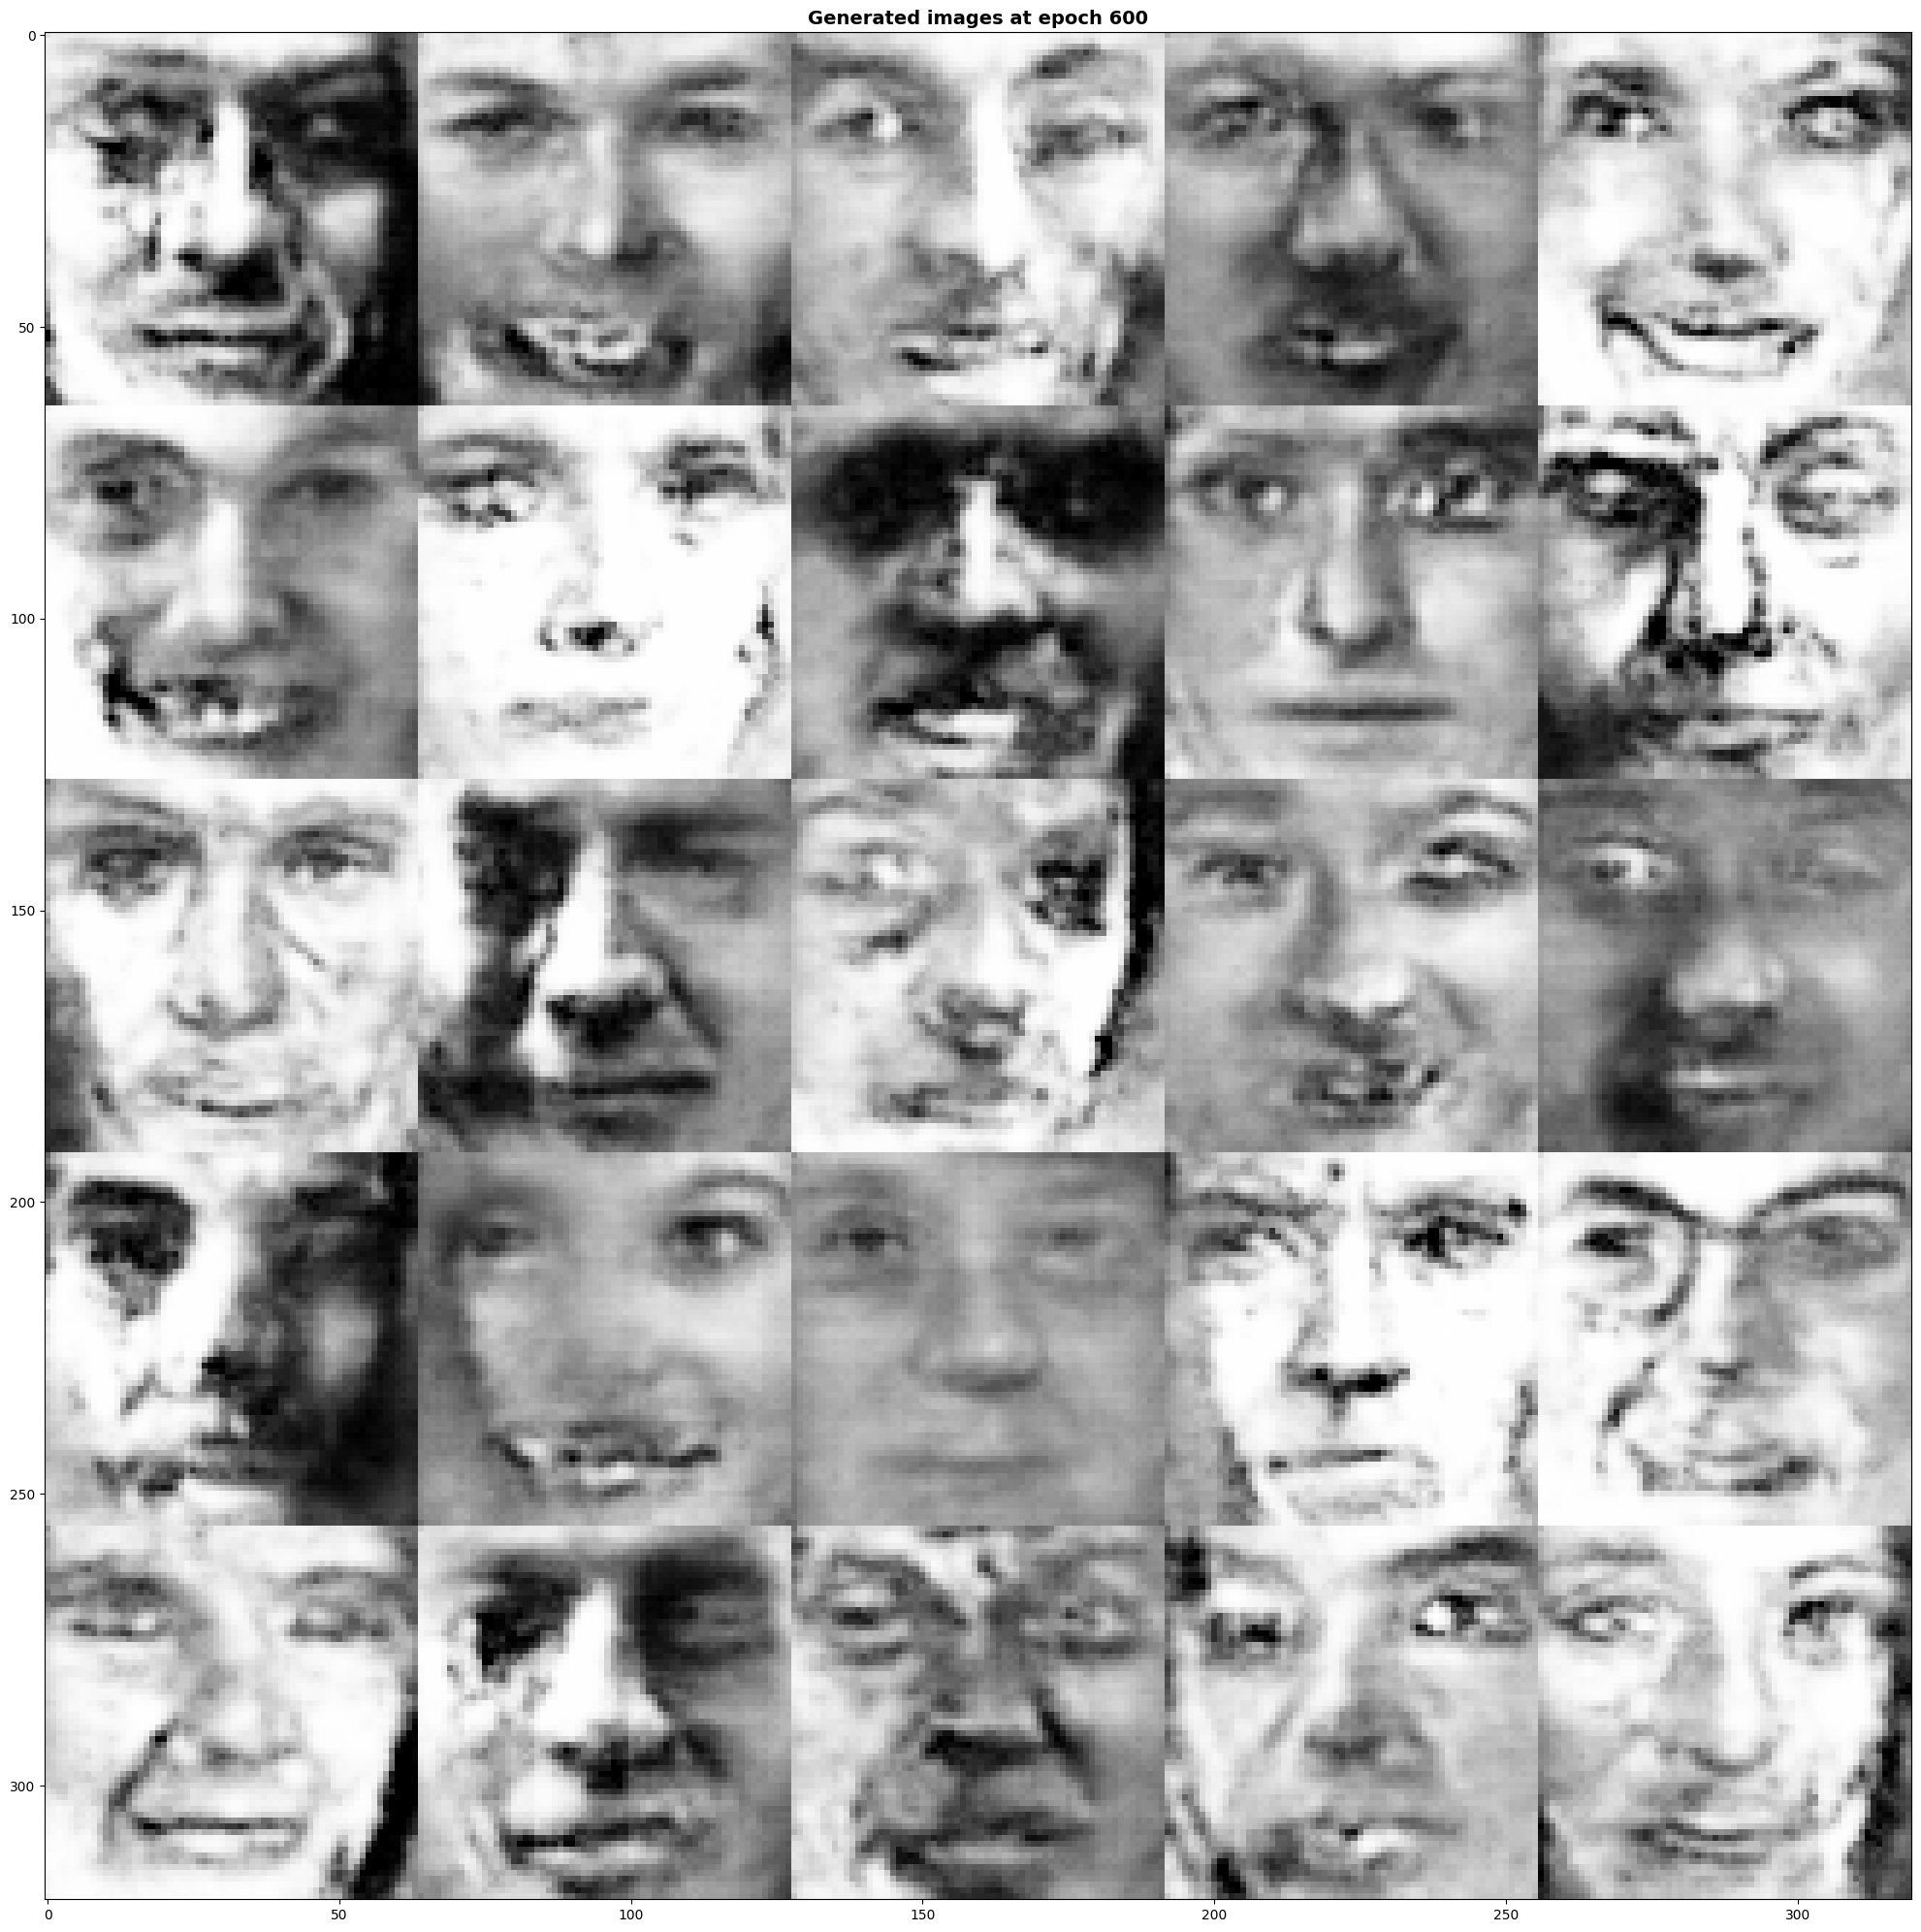

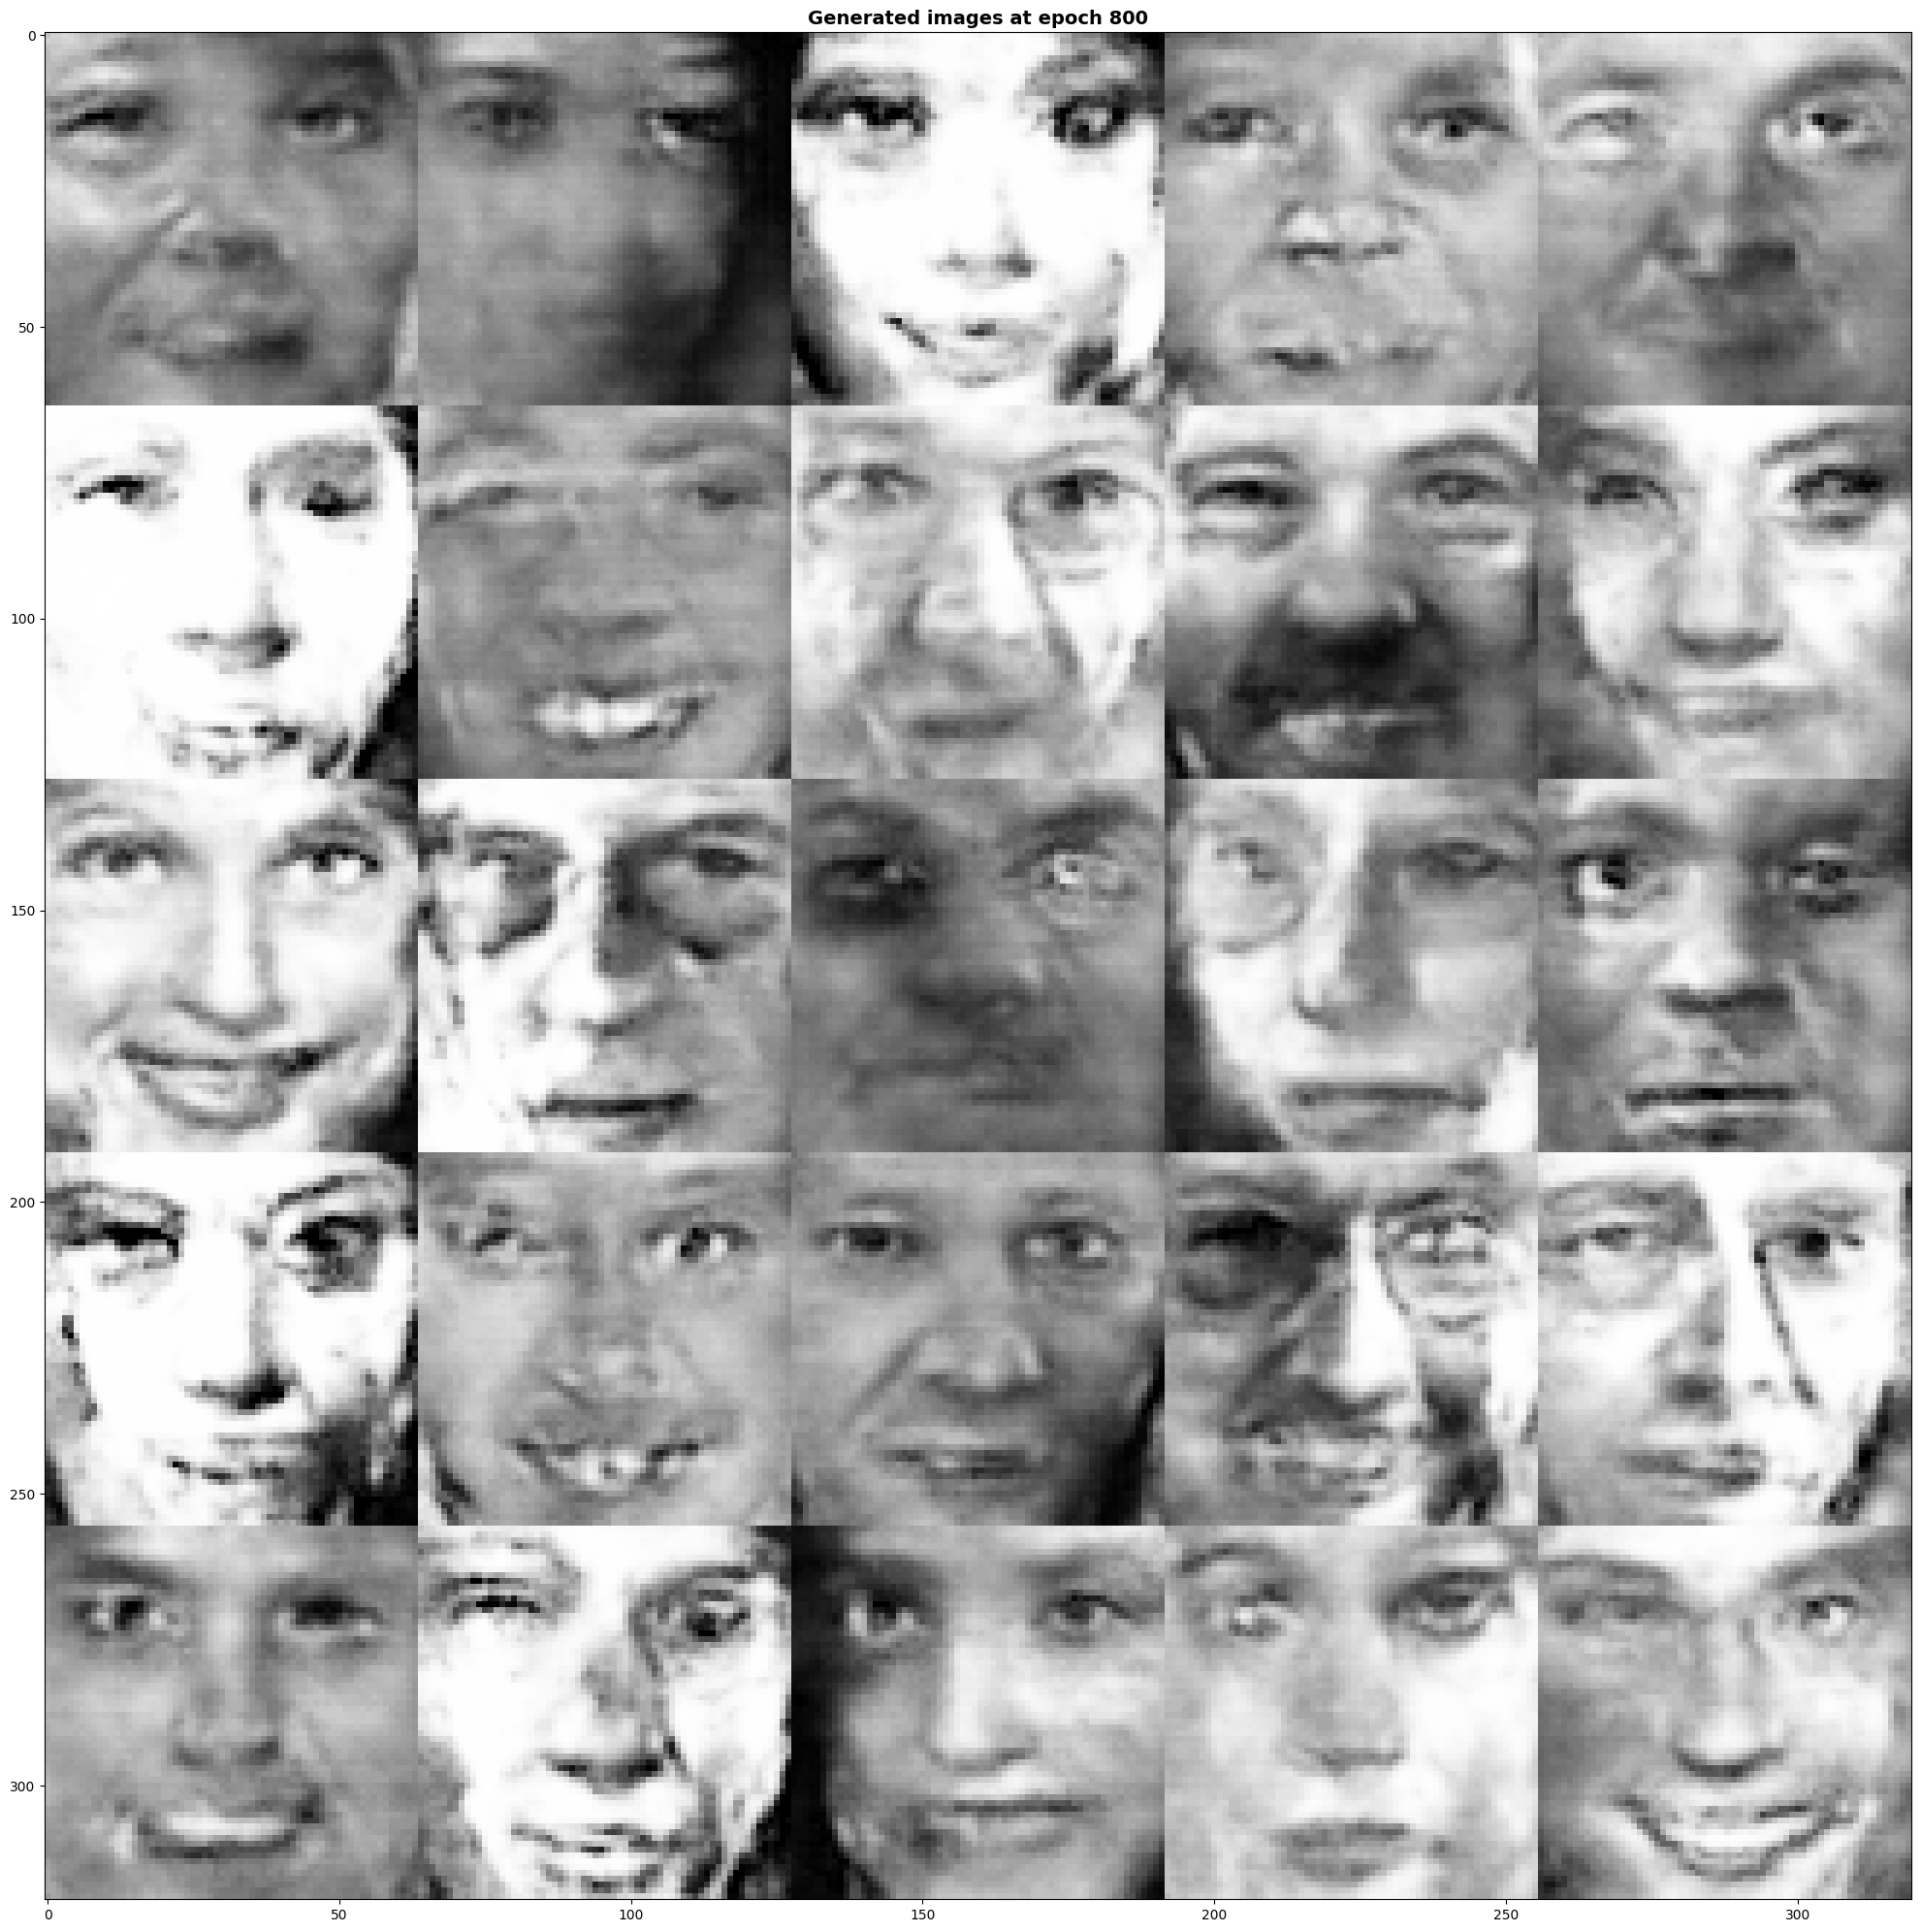

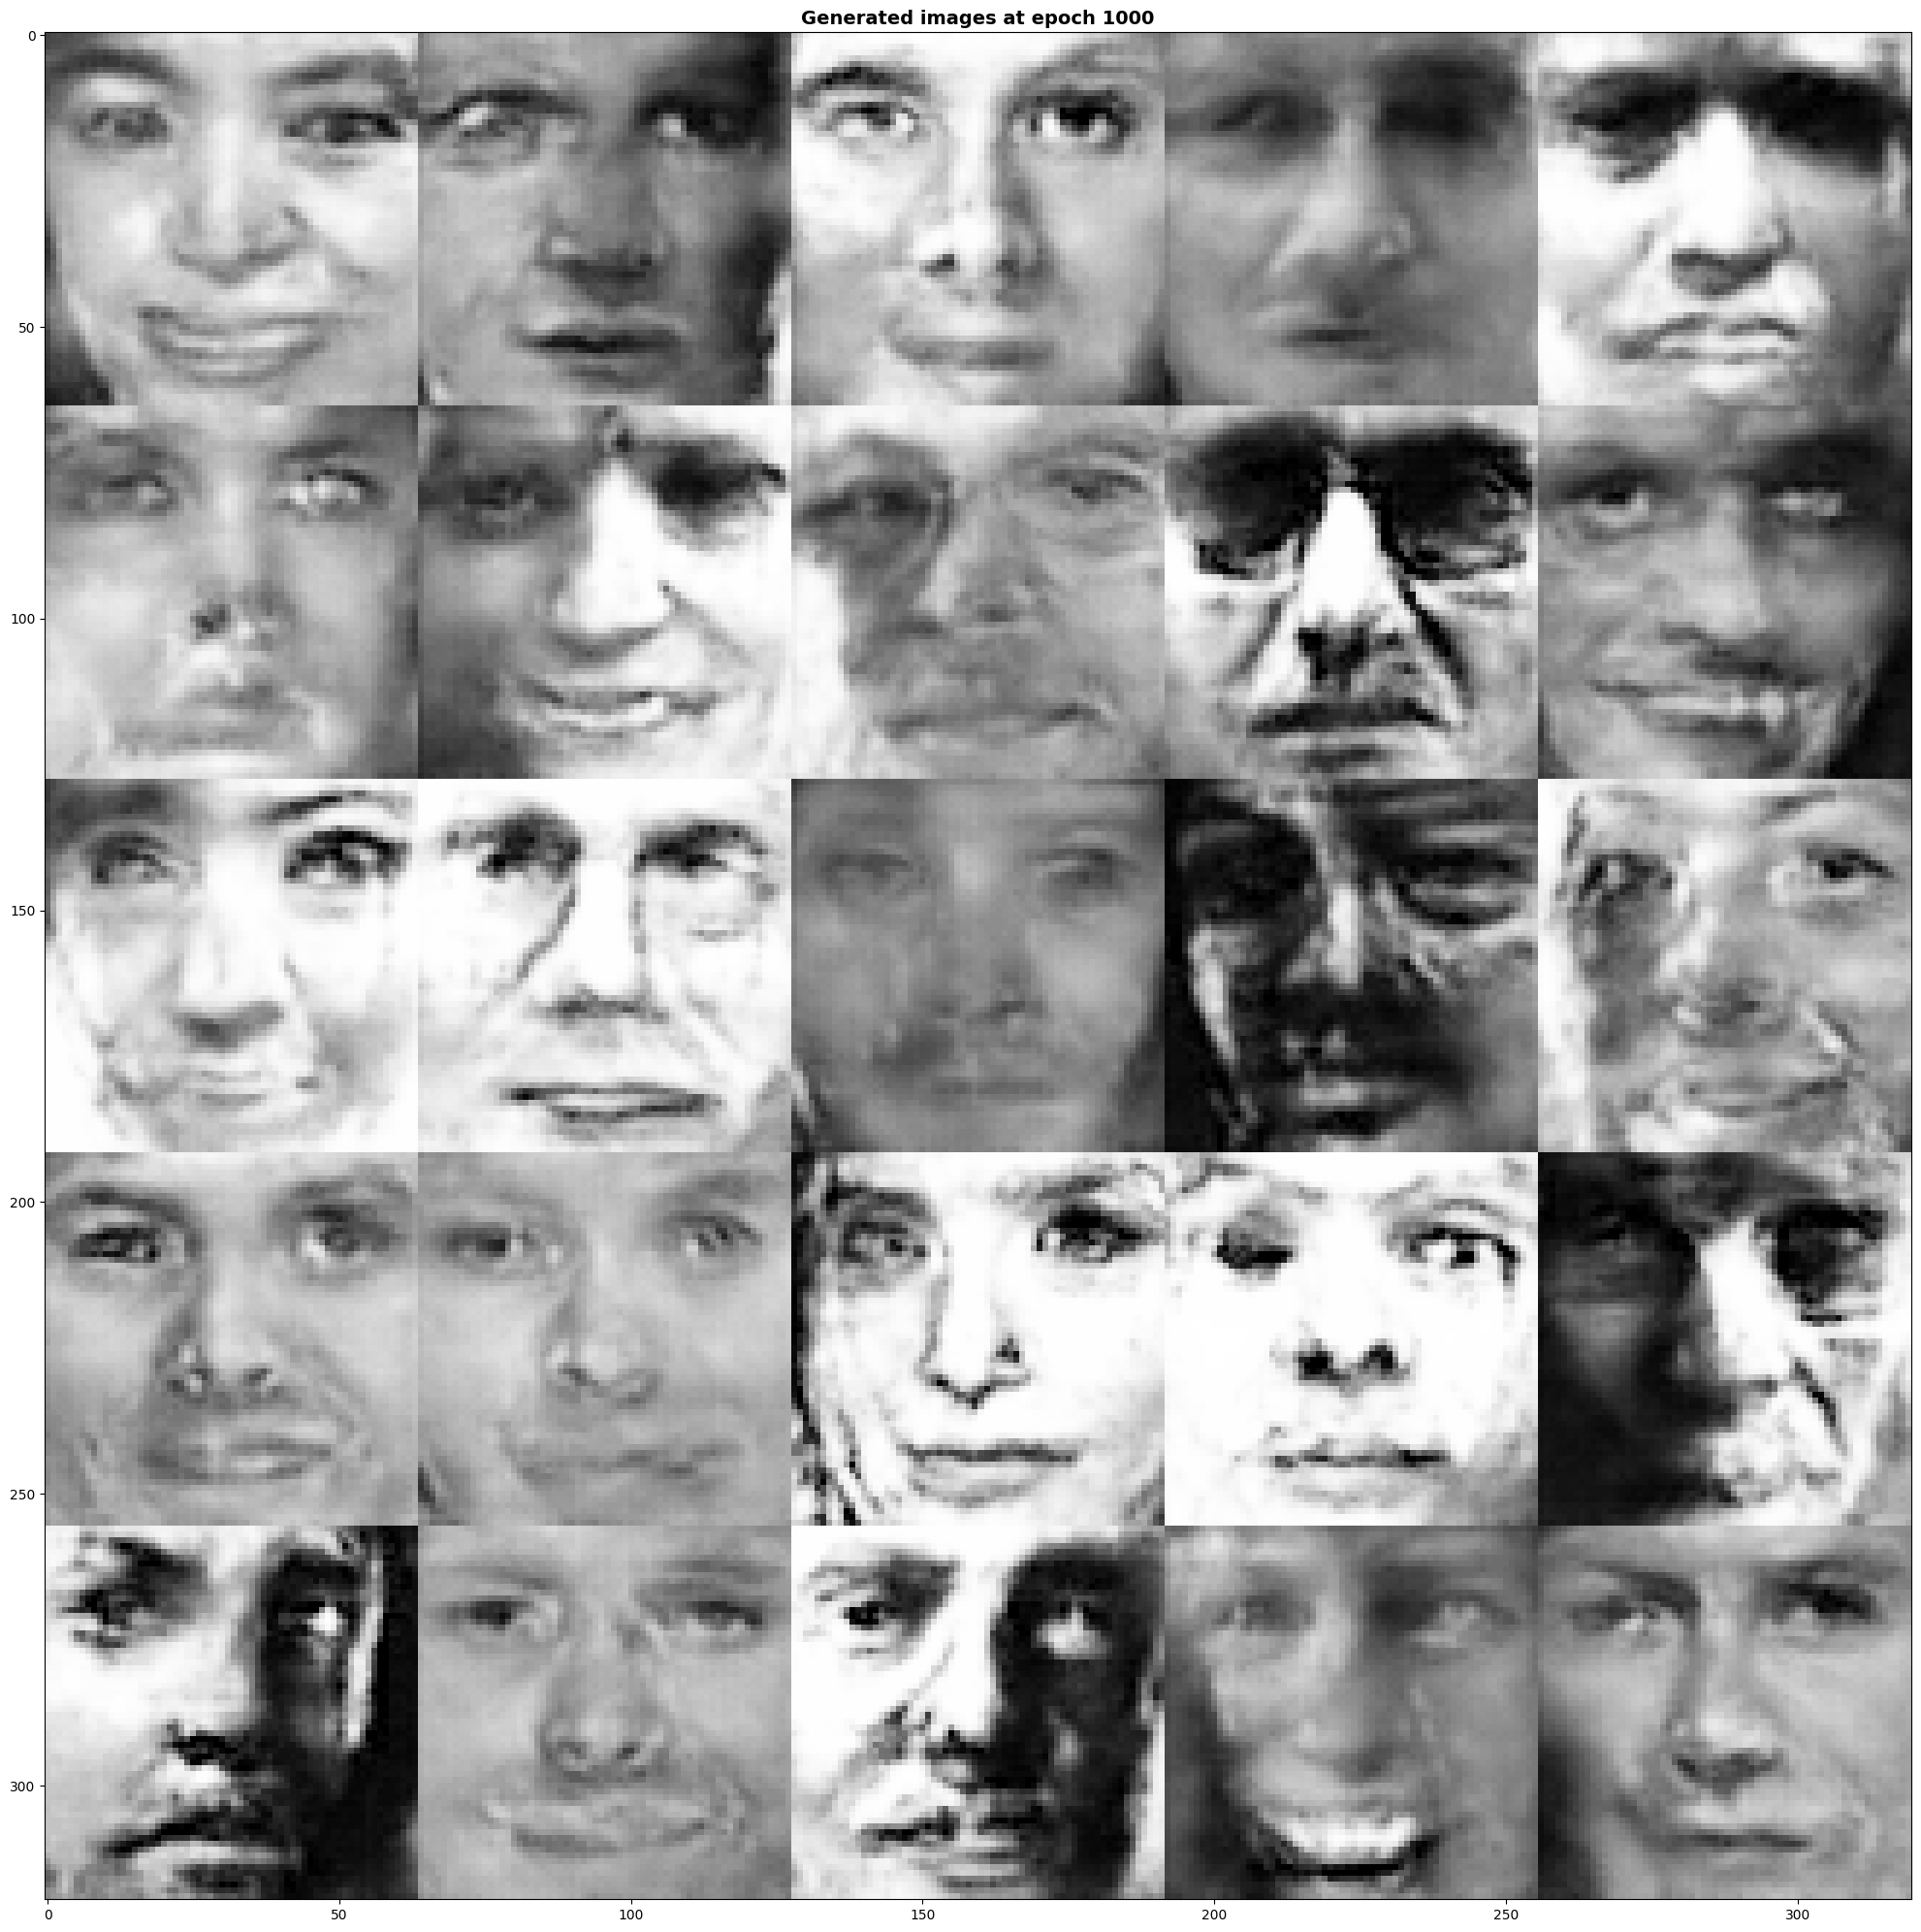

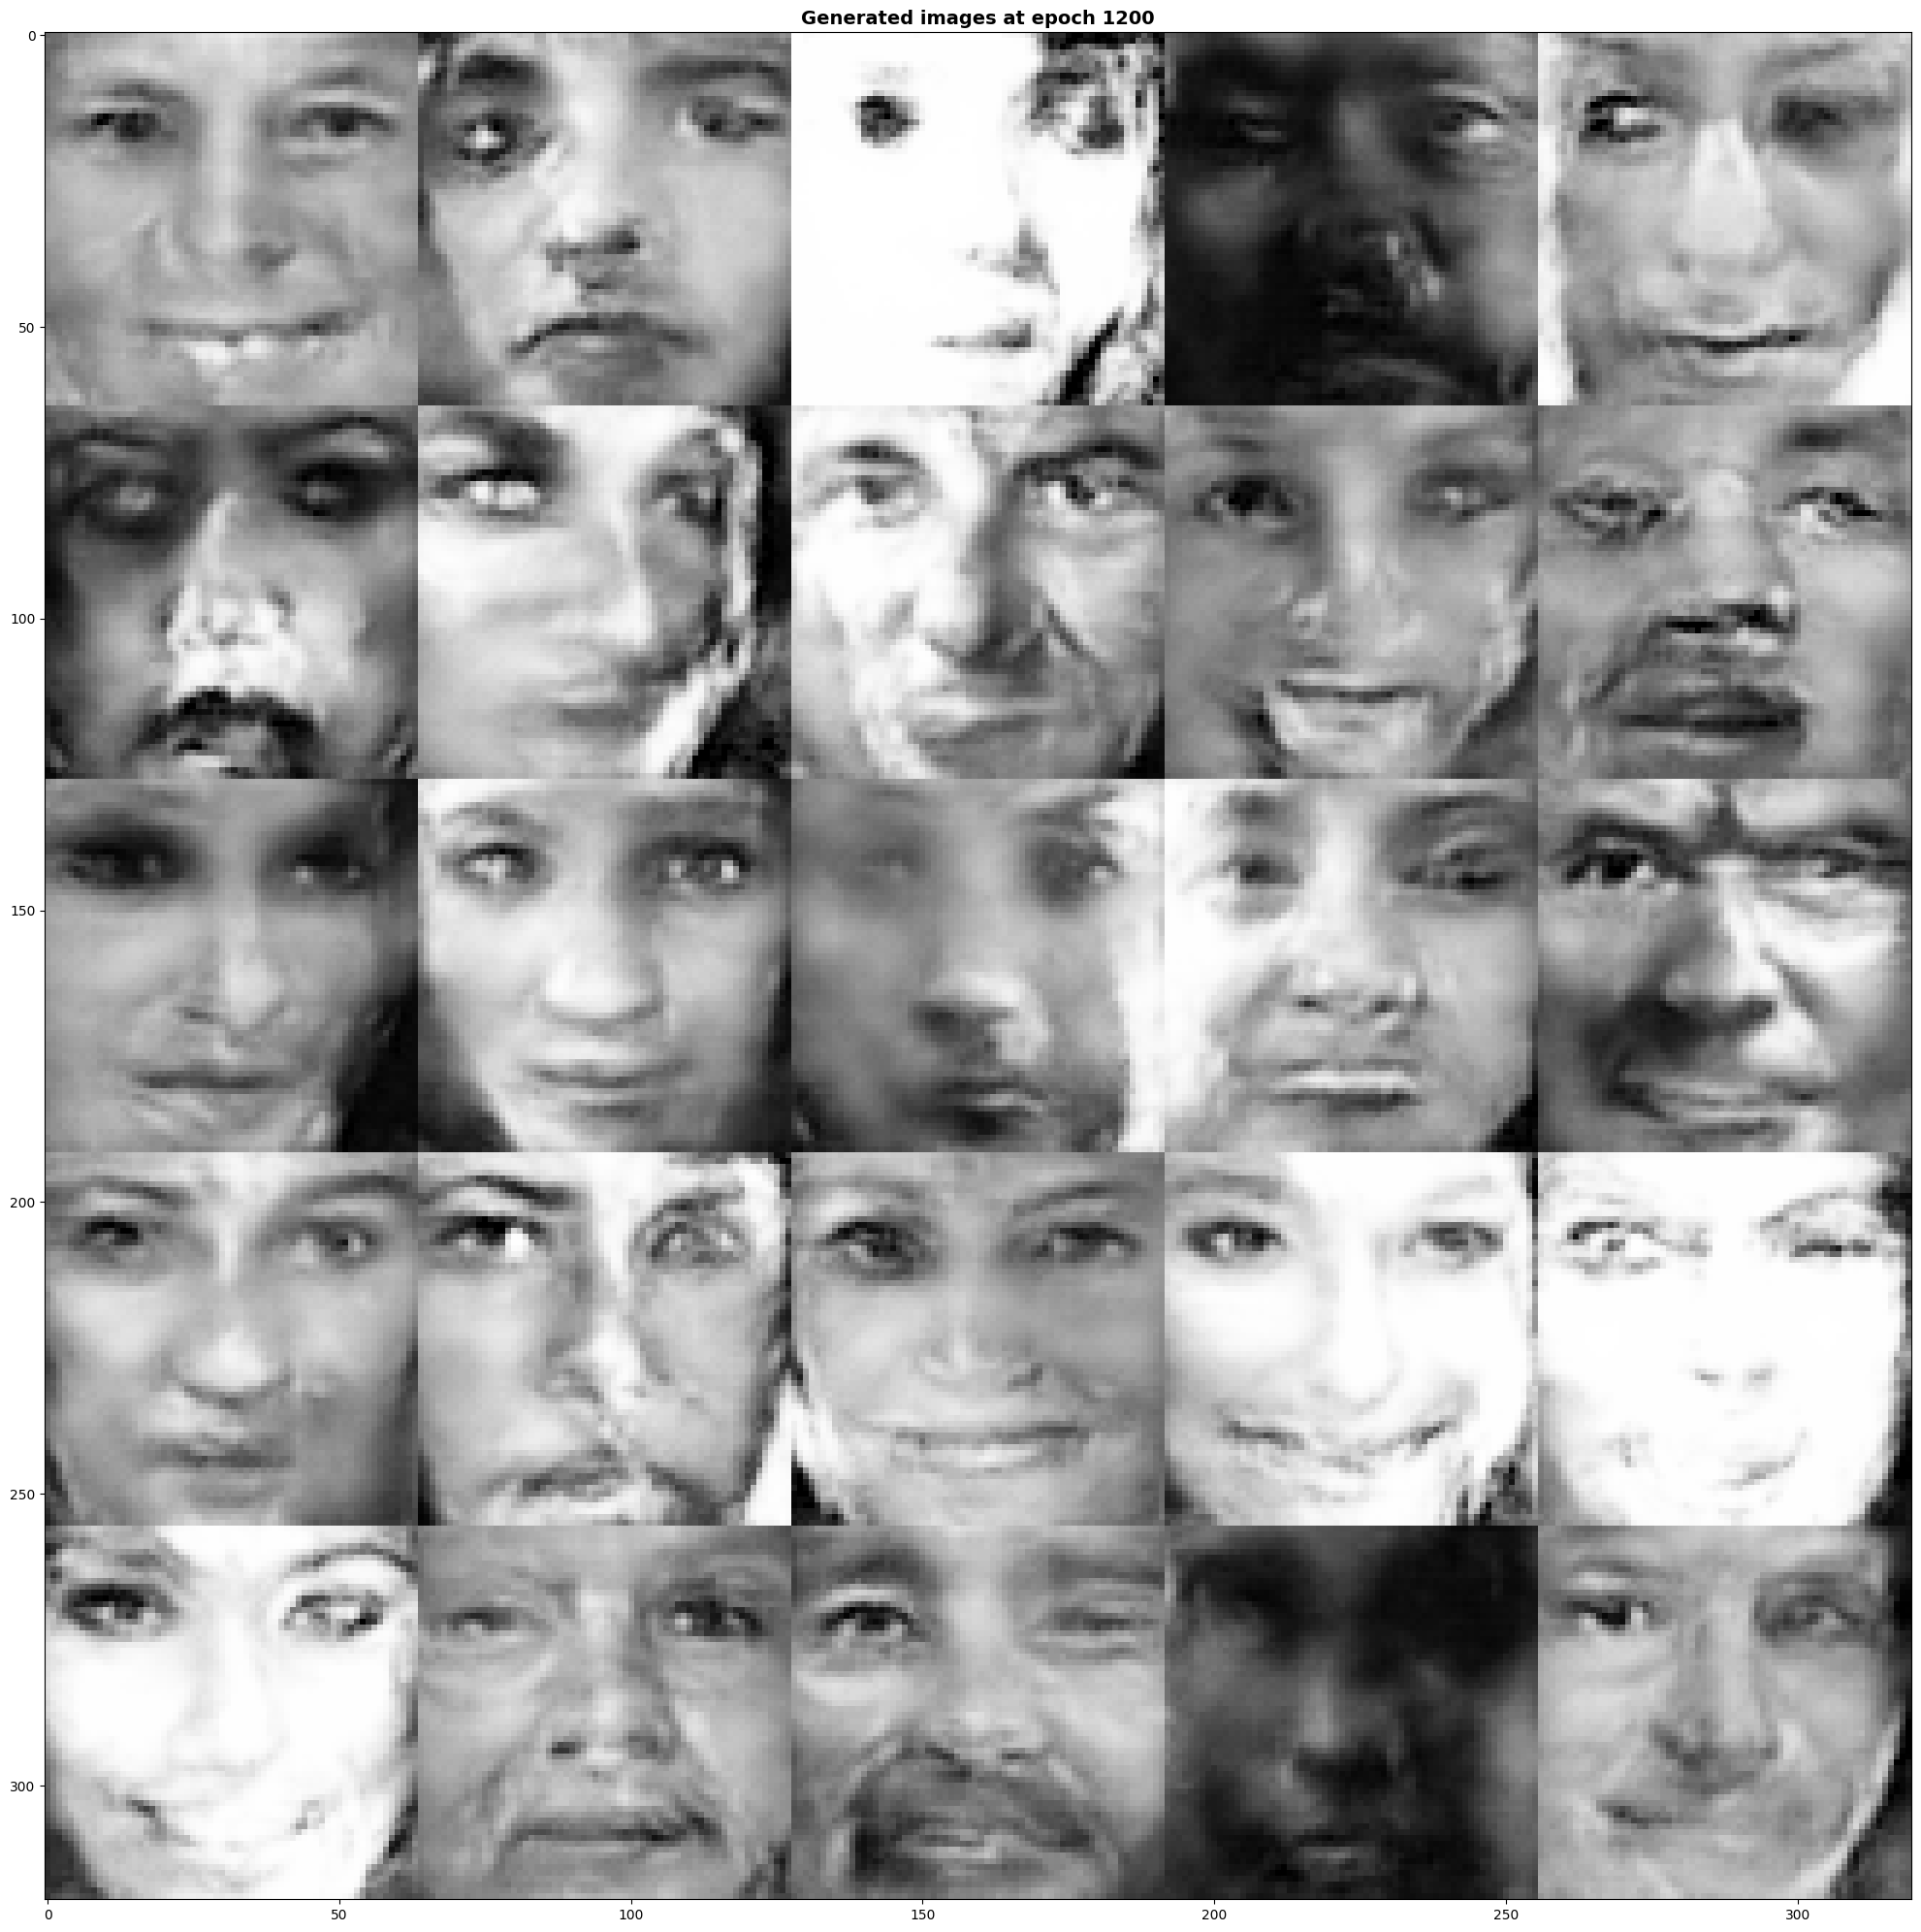

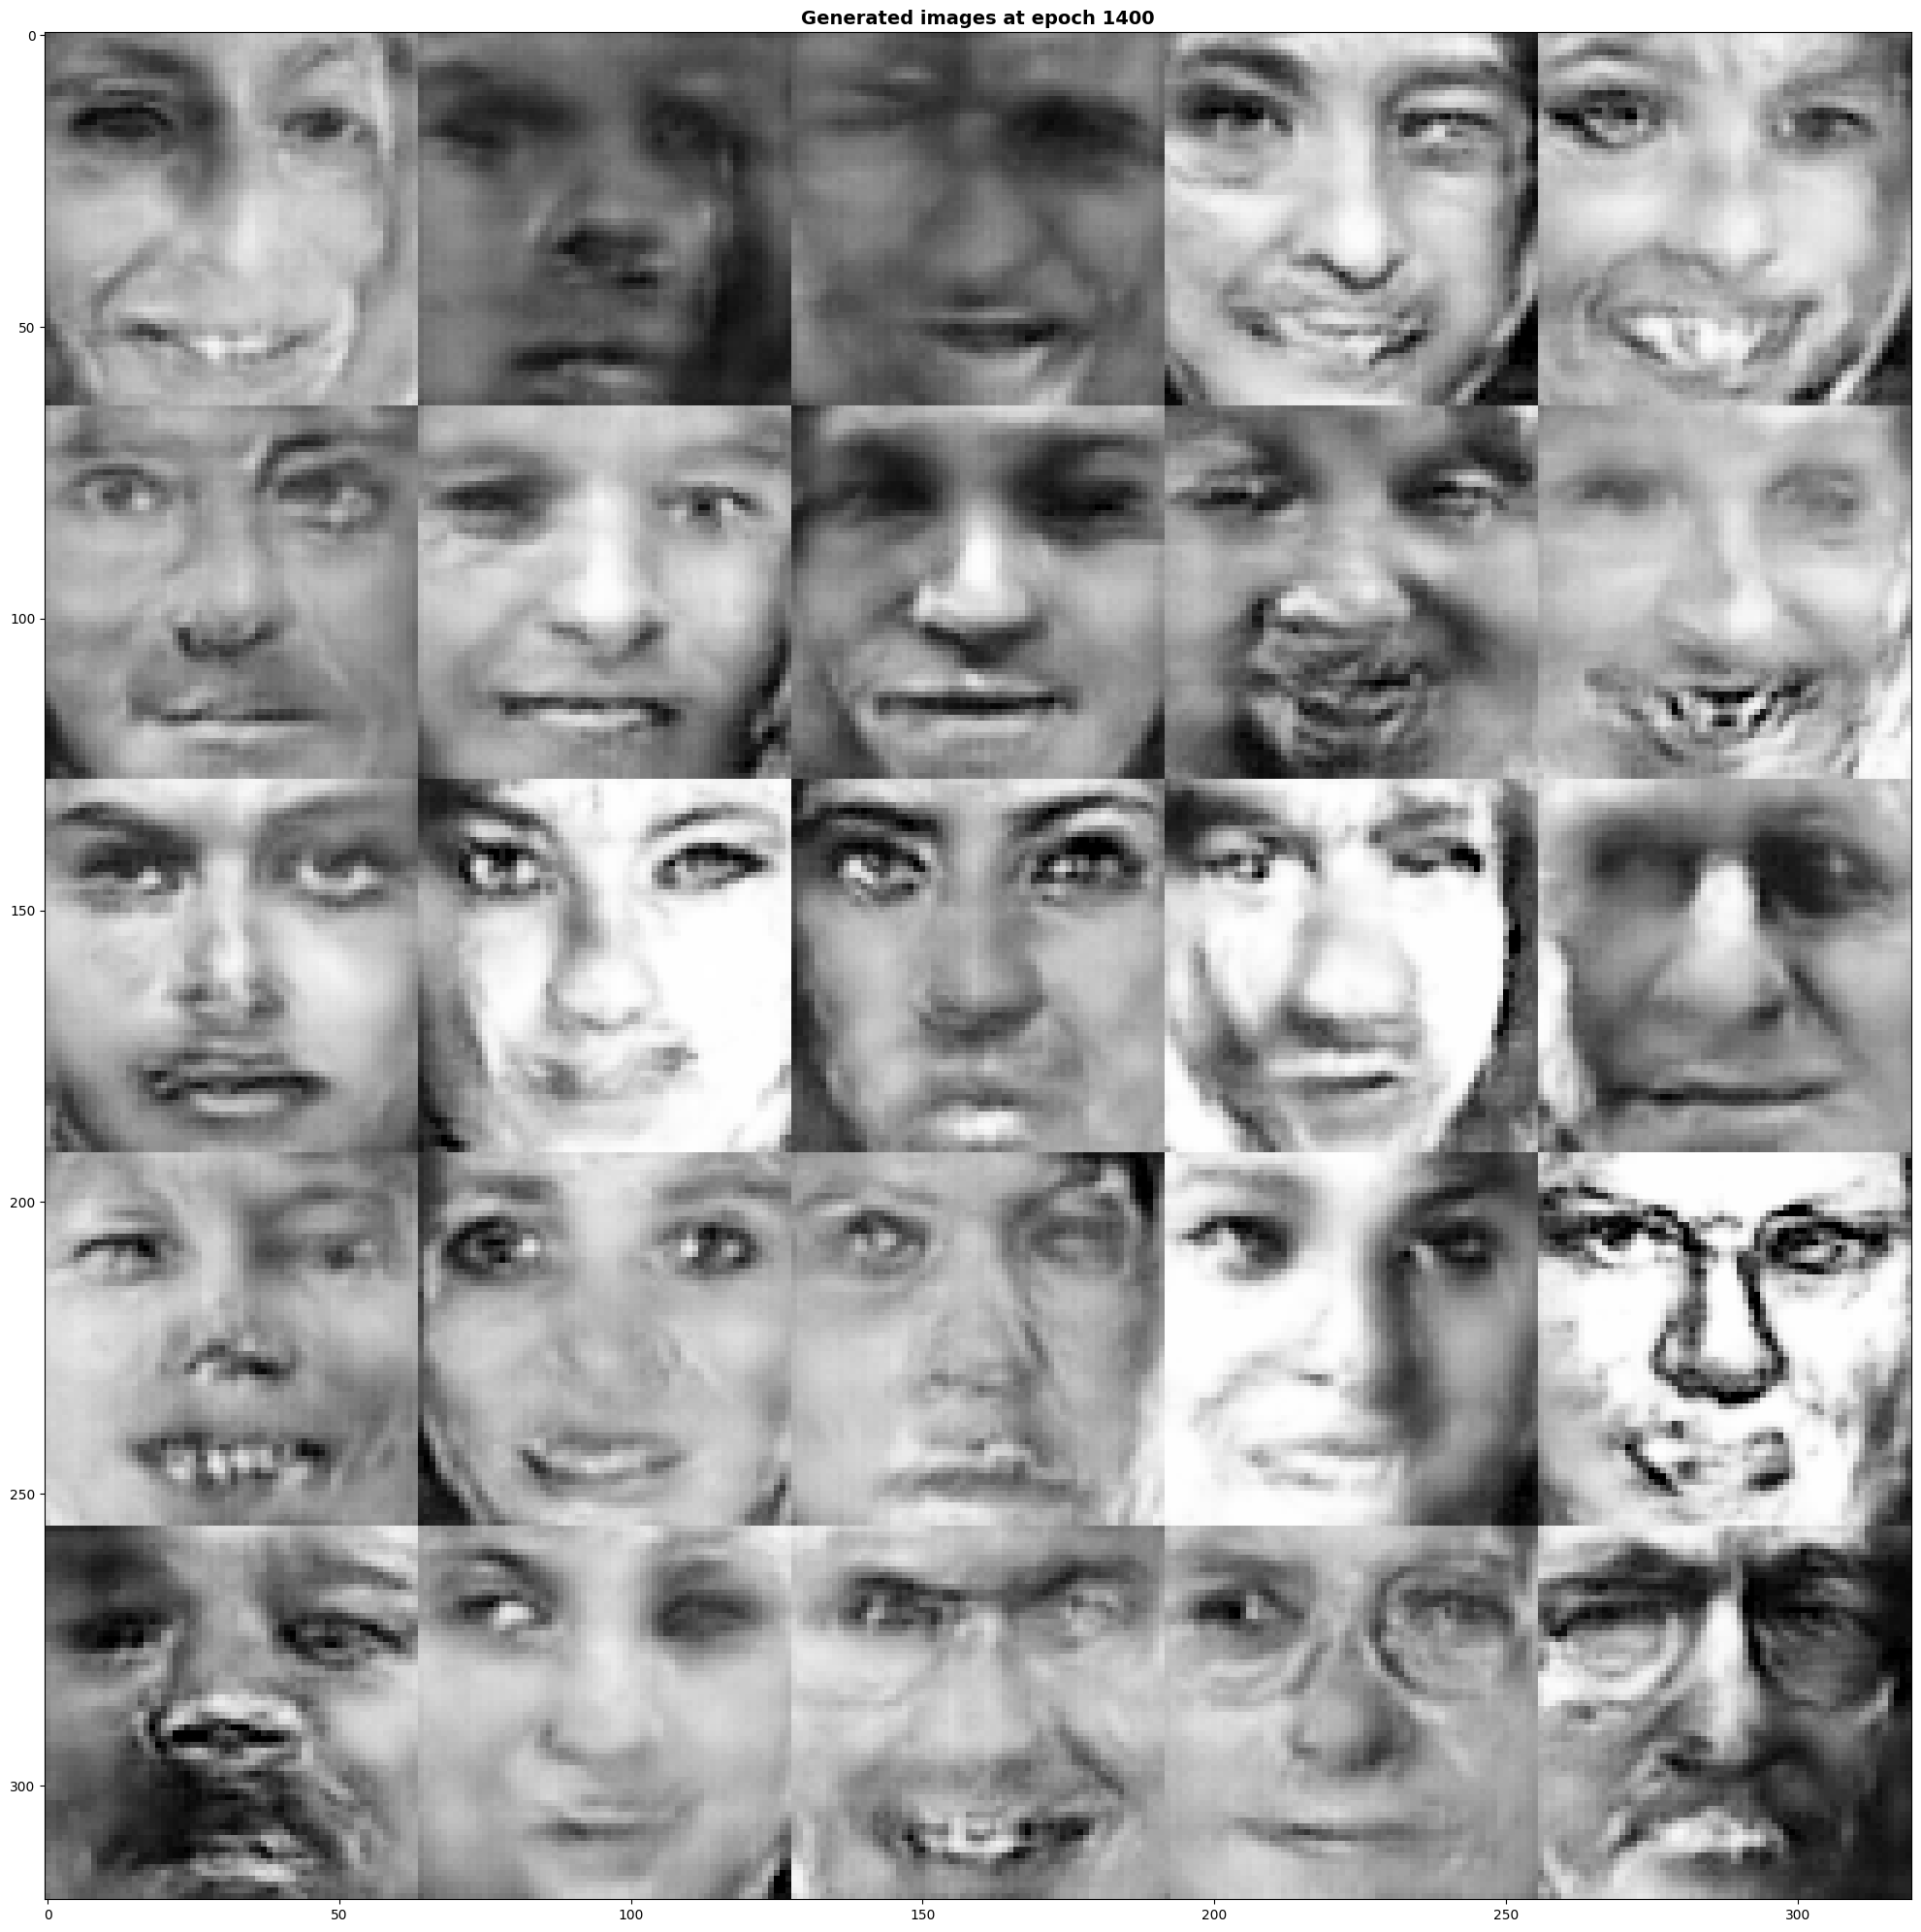

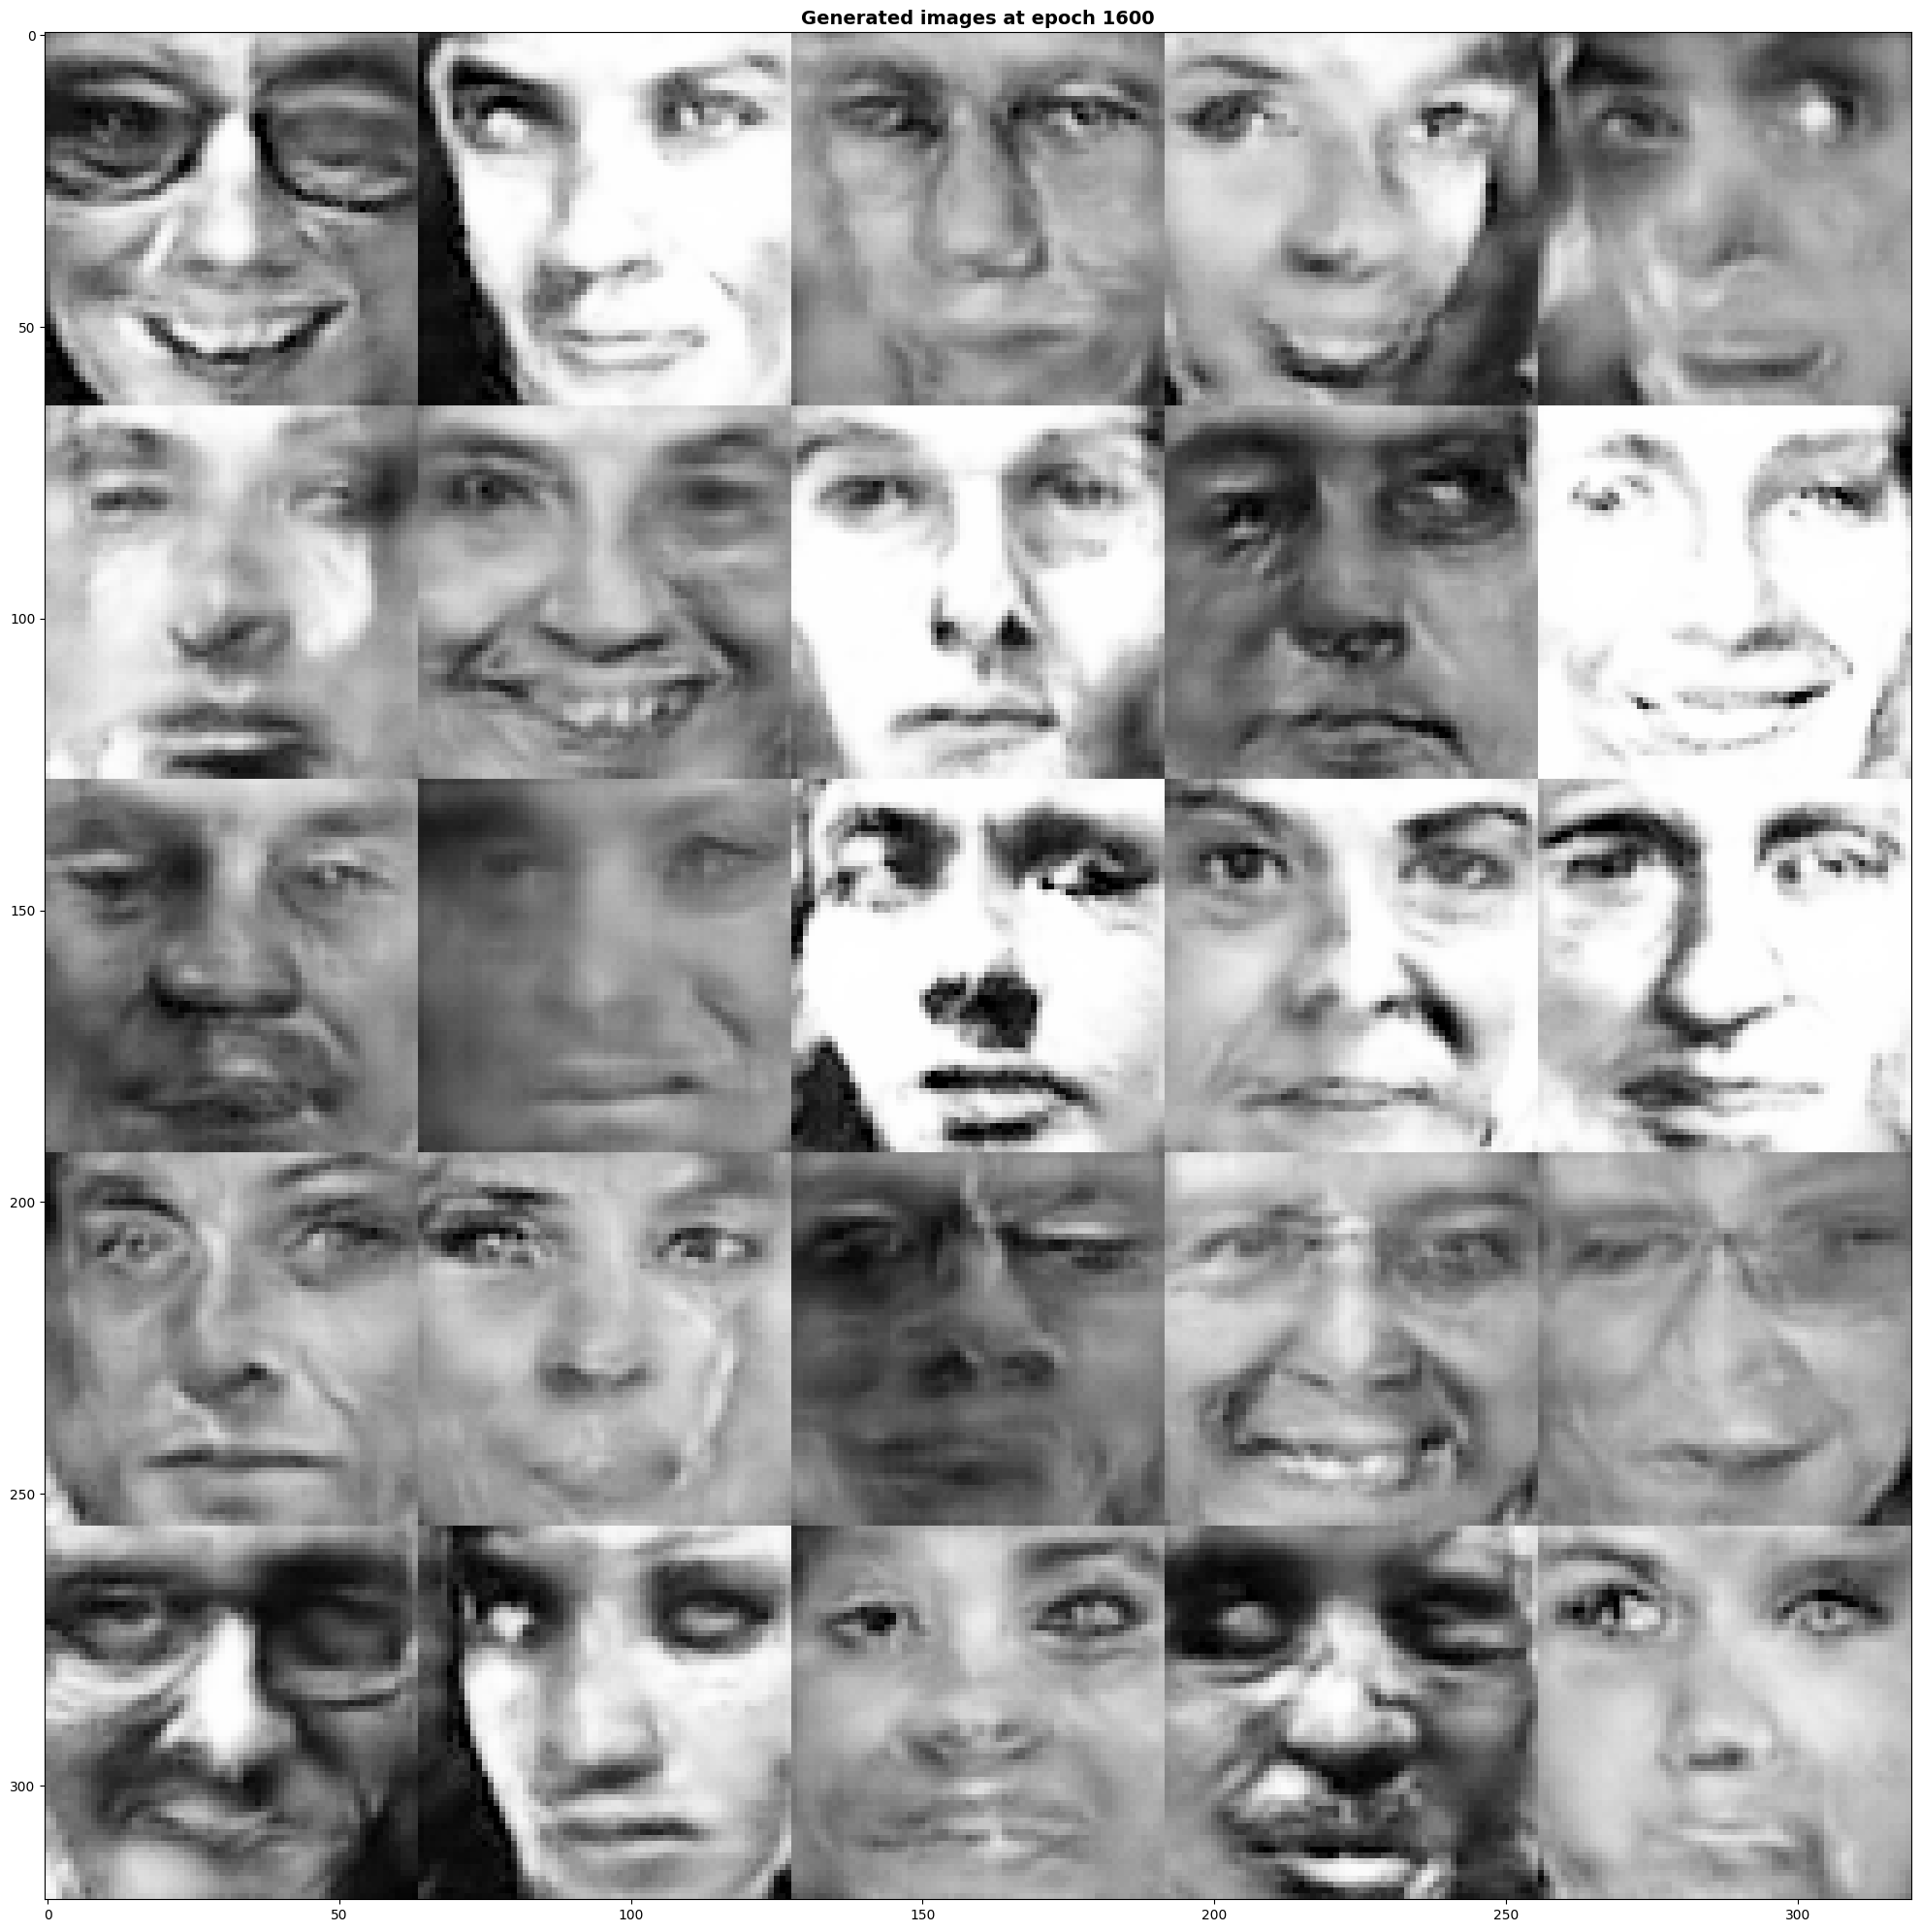

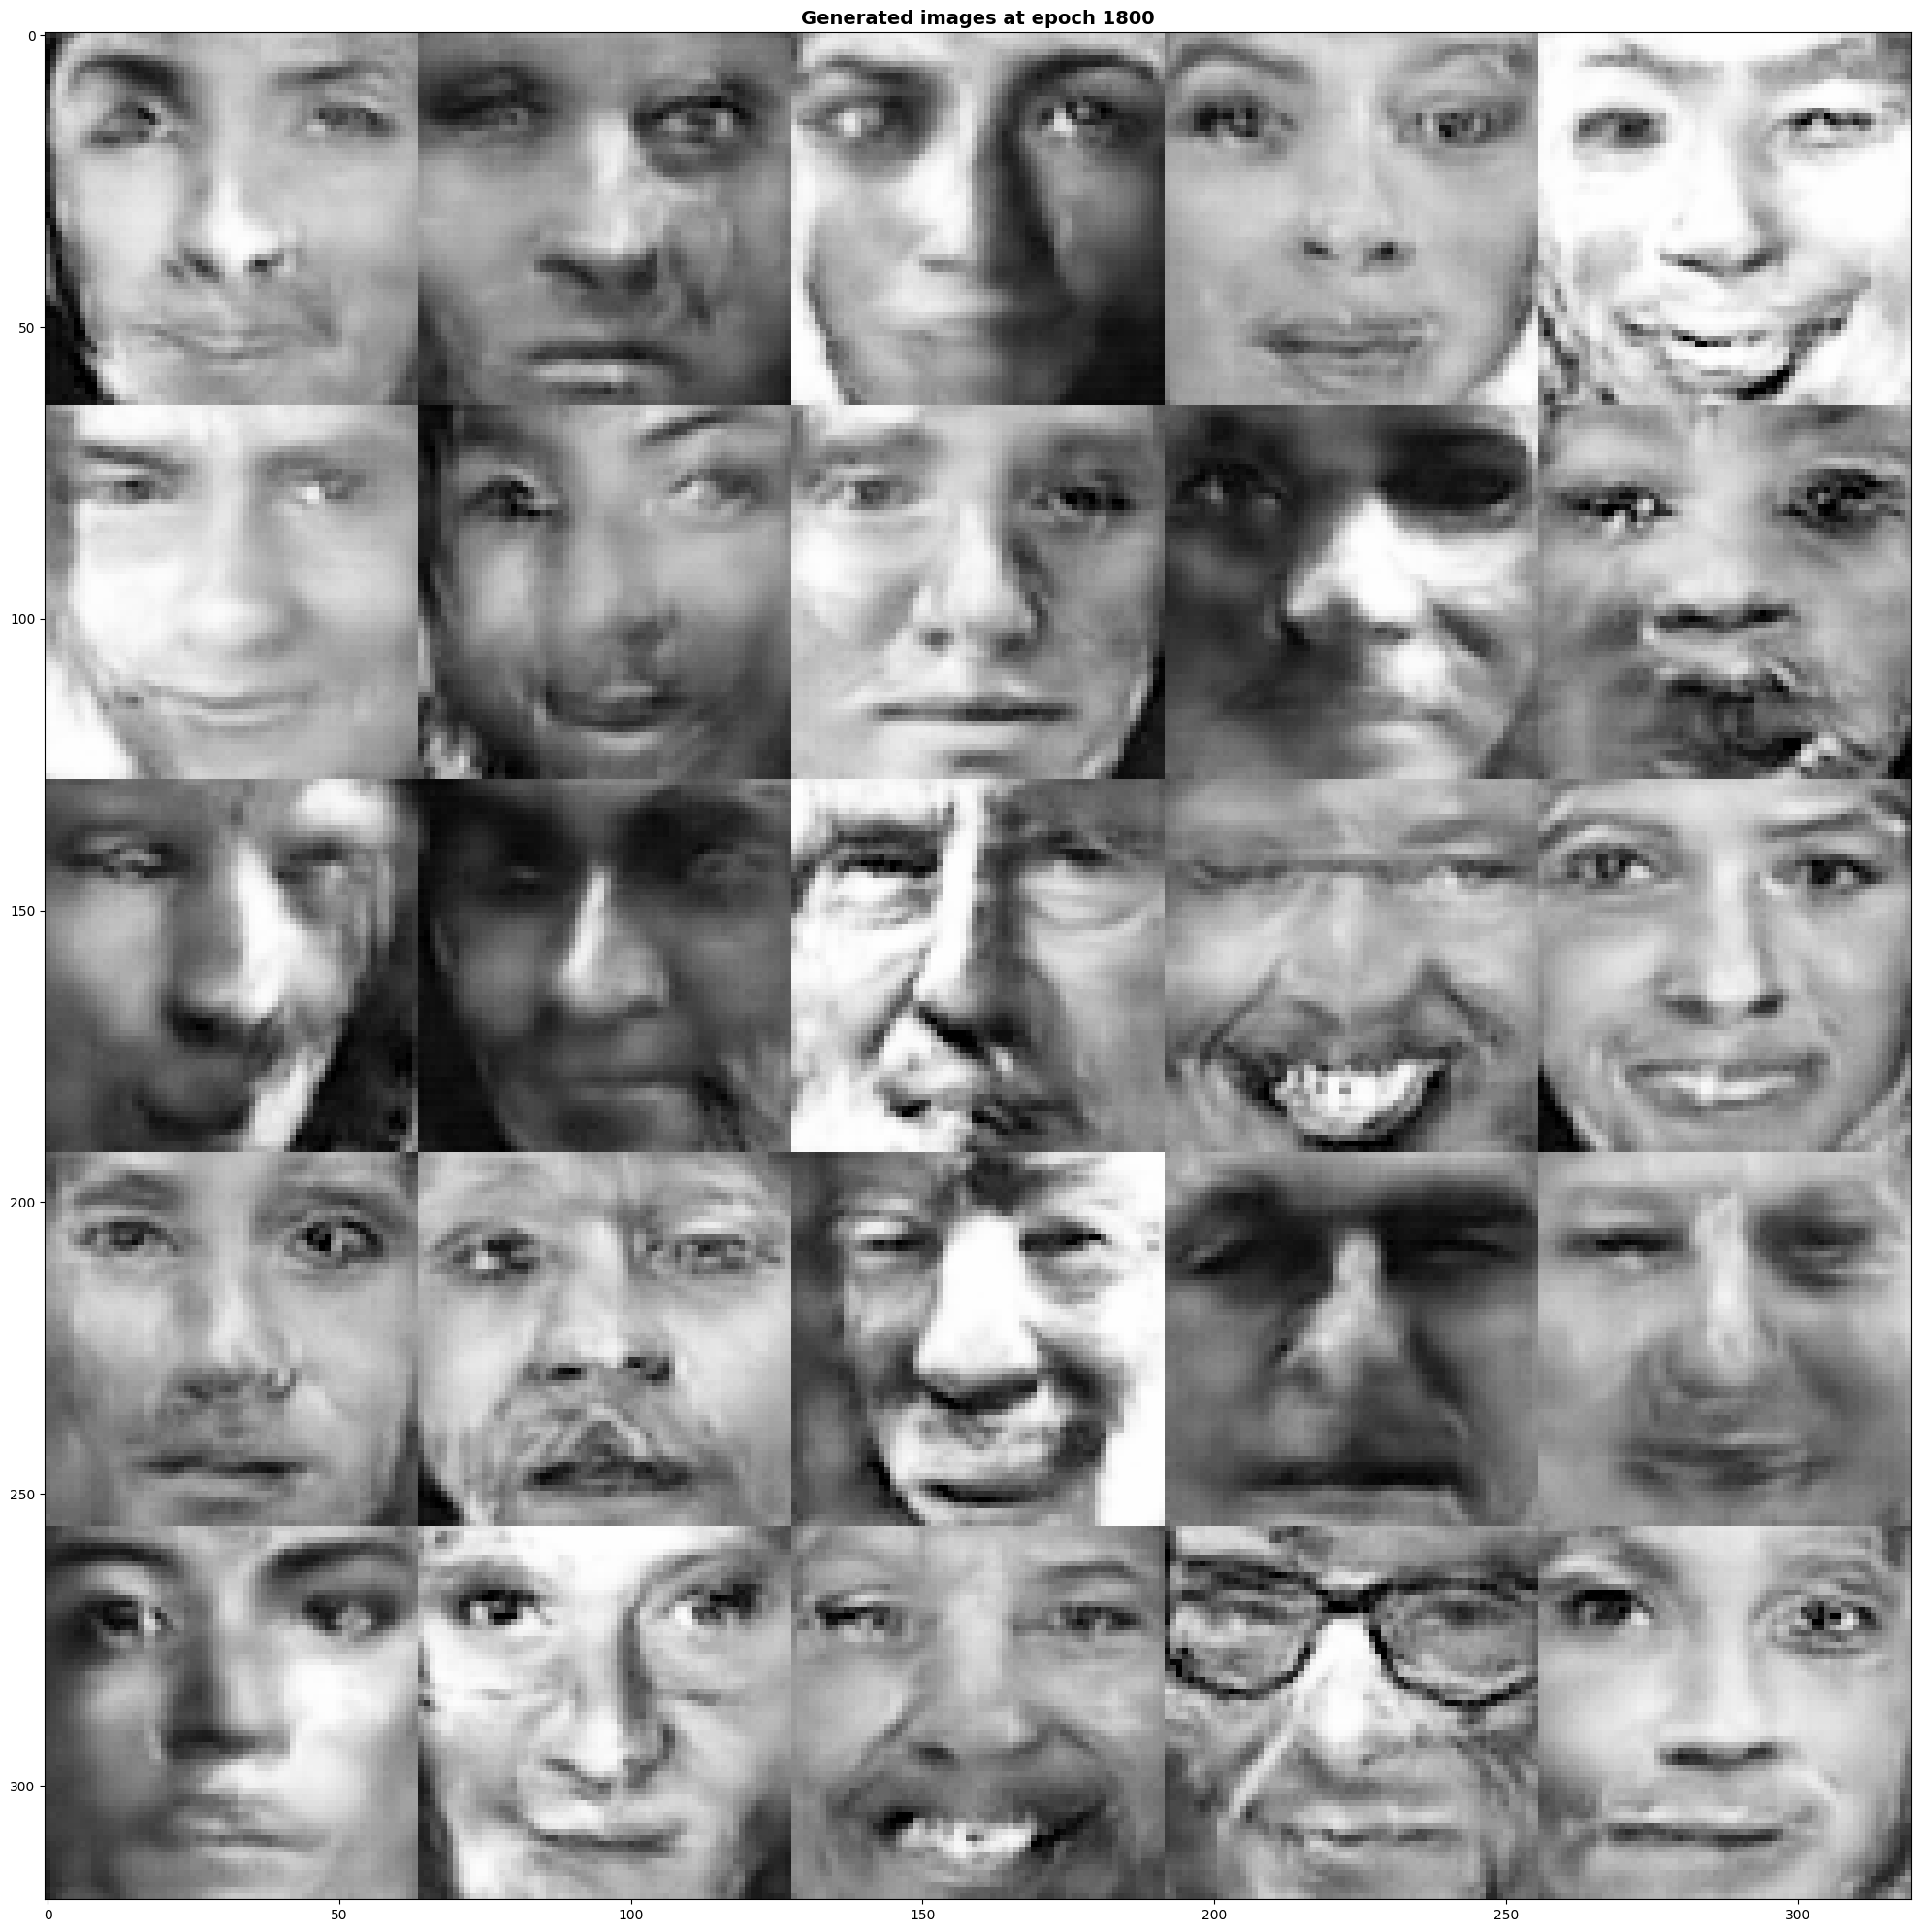

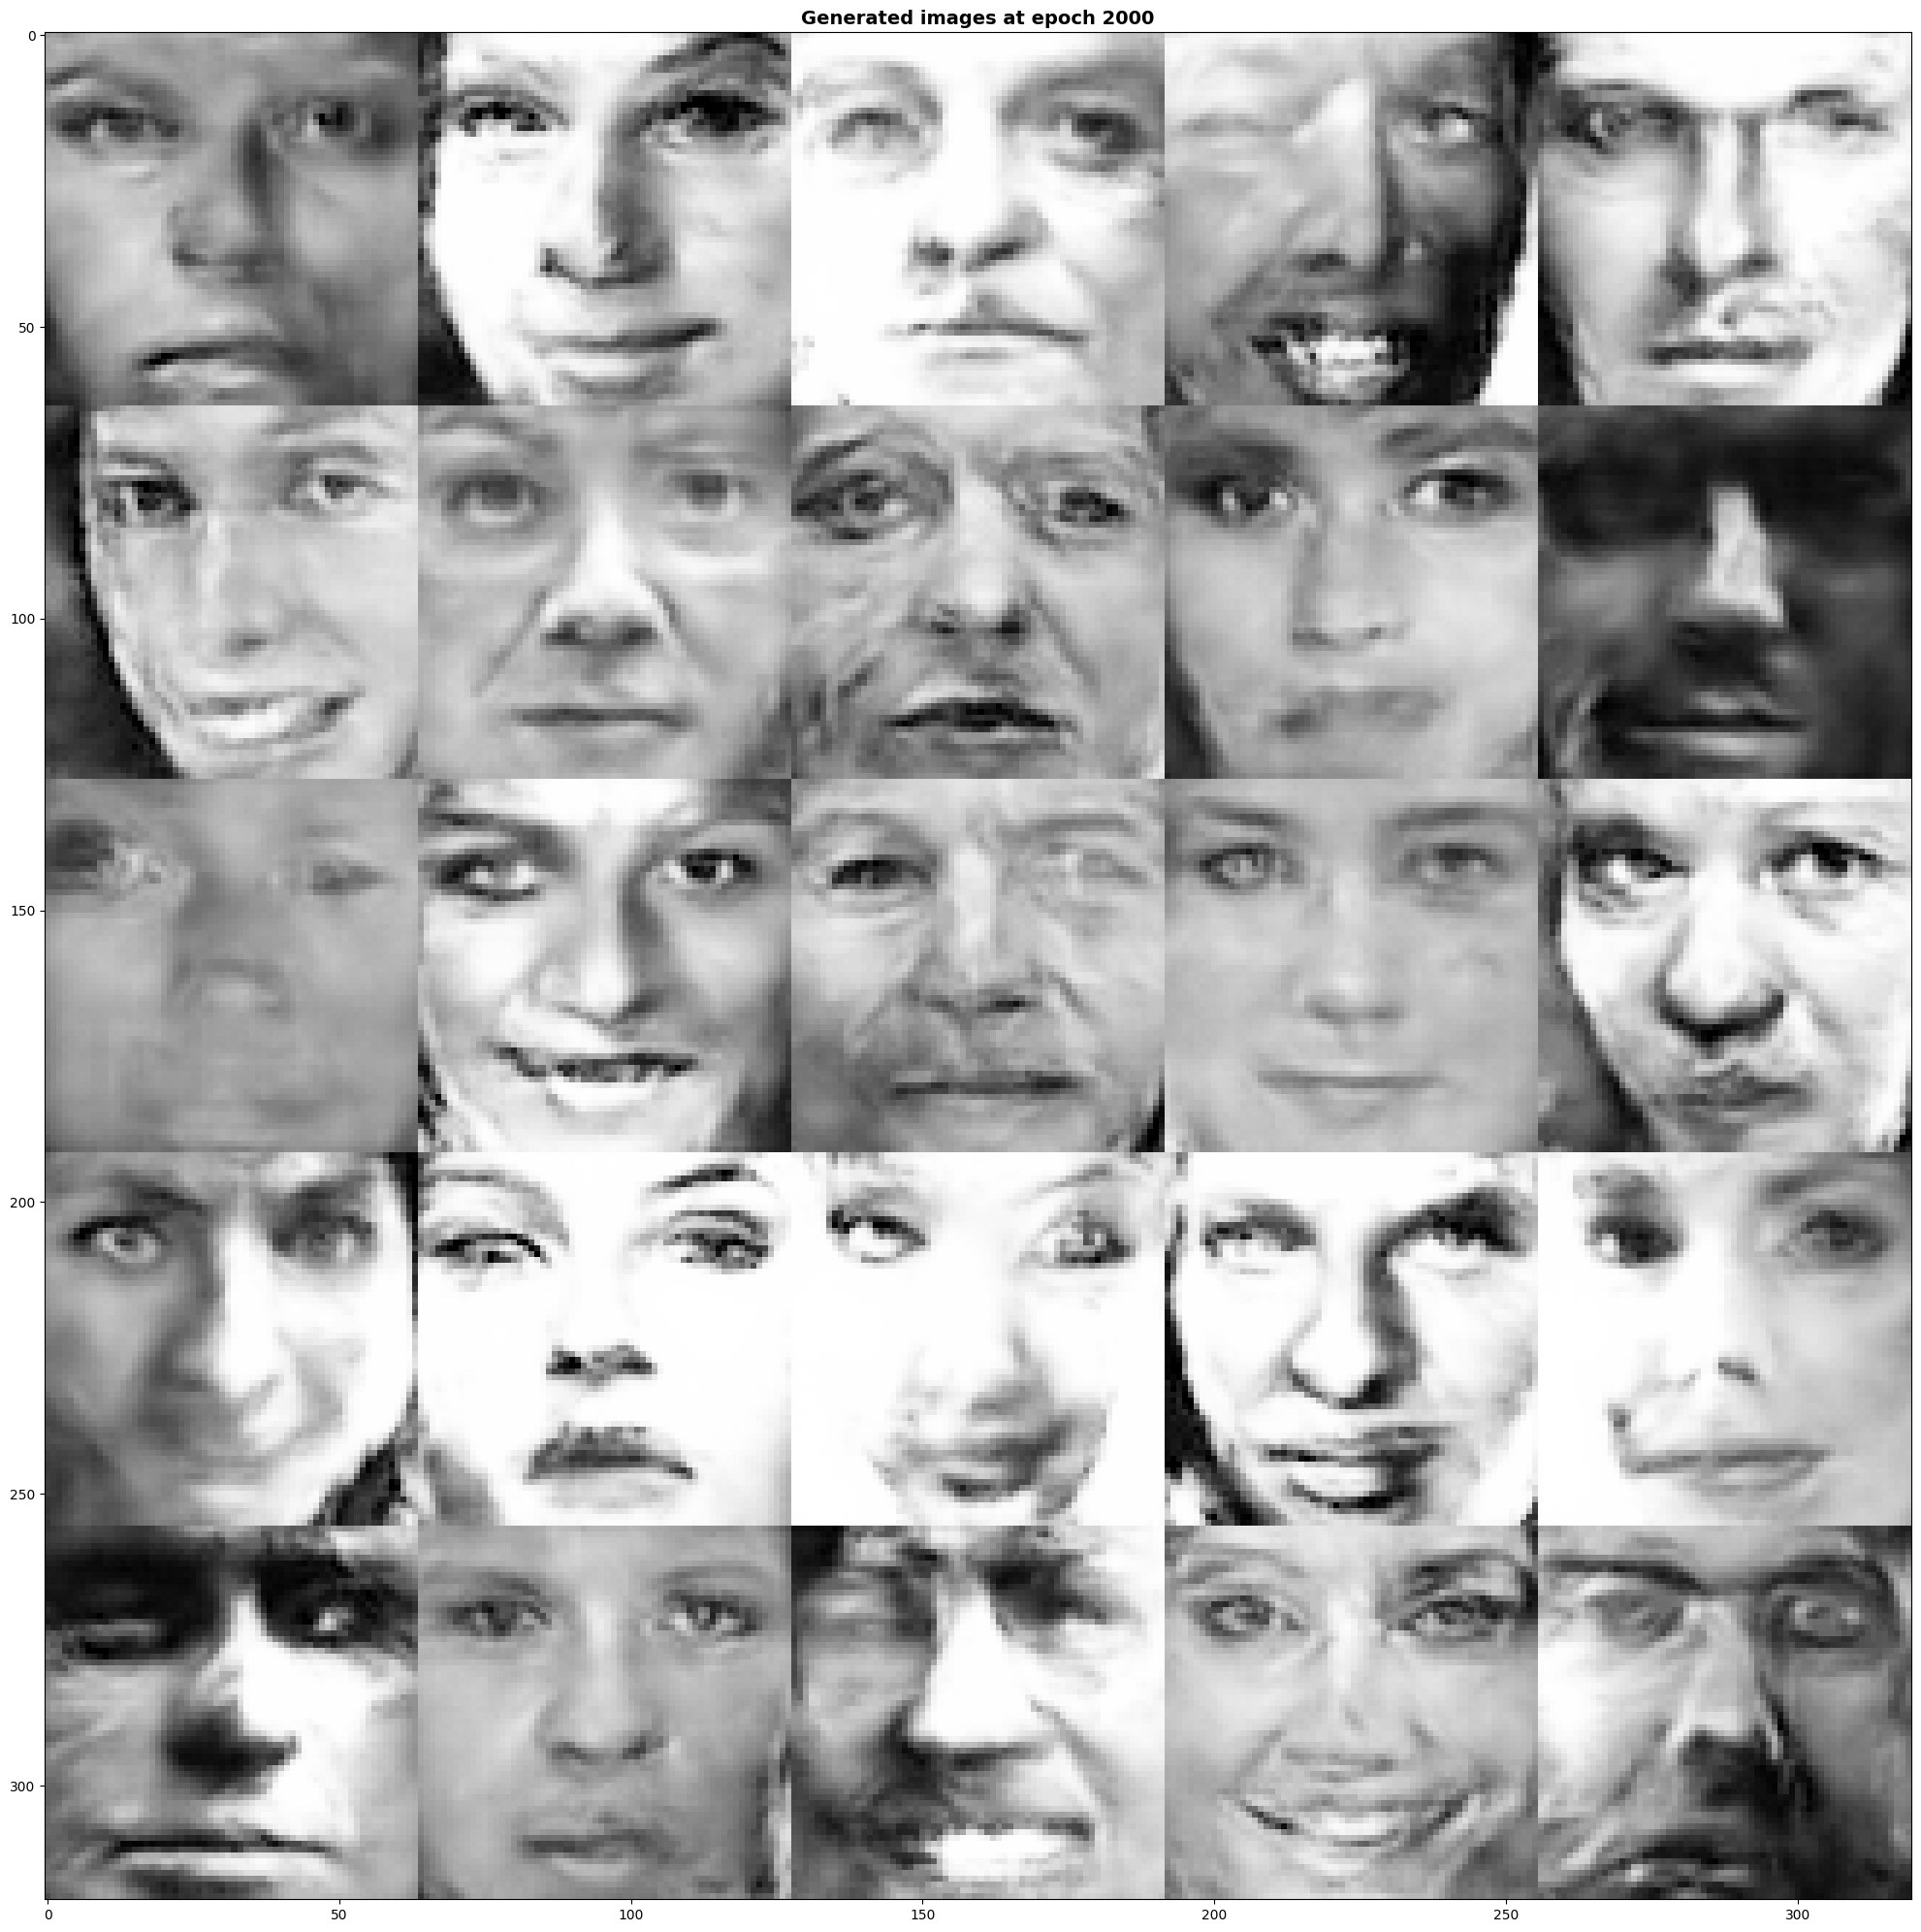

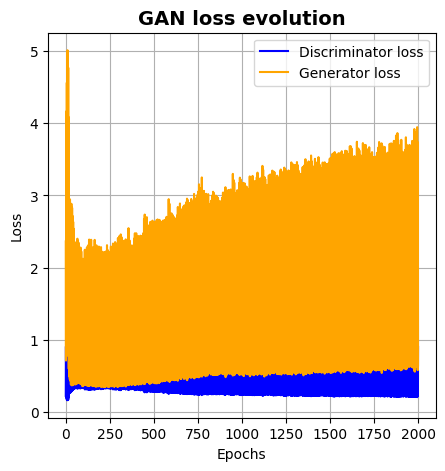

In [17]:
# Train the model
if train_gan:
    assert output_resolution == 64, "Using an image resolution of 32x32 requires a change in architectures/"

    # Define Geneartor and Discriminator networks
    gan = GAN(in_features=output_resolution)
    if load_gan_checkpoint:
        gan.load_state_dict(torch.load(f"{results_path}/{gan.name}_ck.ckpt"))

    #Initialize indepdent optimizer for both networks
    learning_rate_gen = .0002
    learning_rate_disc = .0002 
    optimizer_gen = torch.optim.Adam(gan.generator.parameters(), lr = learning_rate_gen, weight_decay=1e-5, betas=(0.5, 0.999))
    optimizer_disc = torch.optim.Adam(gan.discriminator.parameters(), lr = learning_rate_disc, weight_decay=1e-5, betas=(0.5, 0.999))

    print("\n\n#################### Training GAN ####################")
    # Train the GAN
    disc_loss_list, gen_loss_list = train_GAN(
        gan, train_loader, optimizer_gen, optimizer_disc,
        num_epochs=num_epochs, device=device, plot_every=plot_every
    )

    figure2 = plt.figure(figsize=(5, 5))
    plt.title("GAN loss evolution", fontsize=14, fontweight="bold")
    plt.plot(disc_loss_list, label="Discriminator loss", color="blue")
    plt.plot(gen_loss_list, label="Generator loss", color="orange")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid()
    plt.legend()
    
    if save_figure:
        plt.savefig(f"{results_path}/gan_loss_evolution.png", dpi=300)

    if not show_figure:
        plt.close()


if show_figure: 
    plt.show()
